In [22]:
import numpy as np
from numpy import matlib
import matplotlib.pyplot as plt
import scipy
import matplotlib
import tqdm
from scipy import integrate, fft, sparse
import pandas as pd
import seaborn as sns
import random
import anndata
import os
from sklearn.metrics import confusion_matrix
import loompy as lp

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics.pairwise import cosine_similarity


In [23]:
import sys
import importlib
sys.path.insert(0, '/home/tchari/monod/src/')

In [24]:
import monod
#importlib.reload(monod)
from monod import preprocess, extract_data, cme_toolbox, inference, analysis, mminference

In [25]:
import warnings
warnings.filterwarnings('ignore', category=PendingDeprecationWarning) 

## **Define Functions for Simulations**

In [26]:
class BurstModel():
    """
    This collection of convenience functions is placed in its own class mostly to avoid function name conflicts.
    """
    def __init__(self,seq_model='None',quad_method='fixed_quad',fixed_quad_T=10,quad_order=60,quad_vec_T=np.inf):
        self.seq_model = seq_model
        self.quad_method = quad_method
        self.fixed_quad_T = fixed_quad_T
        self.quad_order = quad_order
        self.quad_vec_T = quad_vec_T
        
    def burst_intfun(self, x, g, b, beta, gamma):
        if np.isclose(beta, gamma):
            c_1 = g[0]  
            c_2 = x * beta * g[1]
        else:
            f = beta / (beta - gamma)
            c_2 = g[1] * f
            c_1 = g[0] - c_2

        U = b * (np.exp(-beta * x) * c_1 + np.exp(-gamma * x) * c_2)
        return U / (1 - U)    
    
    def eval_model_pgf(self, p_, g):
        p = 10**p_
        b, beta, gamma = p

        
        fun = lambda x: self.burst_intfun(x, g, b, beta, gamma)
        if self.quad_method == "quad_vec":
            T = self.quad_vec_T * (1 / beta + 1 / gamma + 1)
            gf = scipy.integrate.quad_vec(fun, 0, T)[0]
        elif self.quad_method == "fixed_quad":
            T = self.fixed_quad_T * (1 / beta + 1 / gamma + 1)
            gf = scipy.integrate.fixed_quad(fun, 0, T, n=self.quad_order)[0]
        else:
            raise ValueError("Please use one of the specified quadrature methods.")
        return gf  # this is the log-generating function

    def get_Pss(self, p, limits, samp=None):
        u = []
        mx = np.copy(limits)
        mx[-1] = mx[-1] // 2 + 1
        for i in range(len(mx)):
            l = np.arange(mx[i])
            u_ = np.exp(-2j * np.pi * l / limits[i]) - 1
            u.append(u_)
        g = np.meshgrid(*[u_ for u_ in u], indexing="ij")
        for i in range(len(mx)):
            g[i] = g[i].flatten()
        g = np.asarray(g)[:, :, None]

        if self.seq_model == "Bernoulli":
            g *= np.asarray(samp)[:, None, None]
        elif self.seq_model == "Poisson":
            g = np.exp((np.power(10, samp))[:, None, None] * g) - 1

        gf = self.eval_model_pgf(p, g)
        gf = np.exp(gf)
        gf = gf.reshape(tuple(mx))
        
        
        Pss = scipy.fft.irfftn(gf, s=tuple(limits))
        
        
        Pss = np.abs(Pss) / np.sum(np.abs(Pss))
        
        Pss = Pss.squeeze()
        return Pss

In [27]:
def sample_from_p(num_data_points, Pss):
    mx = Pss.shape
    p_flat = Pss.flatten()
    x_N, x_M = np.arange(mx[0]), np.arange(mx[1])
    X_N, X_M = np.meshgrid(x_N, x_M, indexing='ij')    # get grid of possible values
    x_choices = np.arange(np.prod(mx))                 # represent each grid point as a point in a 1D vector
    
    samples = np.random.choice(x_choices, size=num_data_points, replace=True, p=p_flat)
    d_N, d_M = X_N.flatten()[samples], X_M.flatten()[samples]    
    return d_N, d_M

## **Generate Counts**

In [28]:
def make_params(clus,n_genes,lens_sub,samples,glob_samp,num_marks,p=1.0,loc=1.5,single_param=None):
    #For each gene set params (clus x n_genes x 6), use gene lens from transcriptome file + use same gene names 
    params = np.zeros((clus,n_genes,6)) #b,k,beta,gamma,samp_n,samp_m, ALL LOG10
    for g in range(n_genes):
        g_len = lens_sub[g]
        params[:,g,0] = samples[g,0] + np.random.randn()*0.05 #int(np.random.uniform(8,12)) #b
        params[:,g,1] = 0 #np.random.uniform(0.1,0.5) #k
        params[:,g,2] = samples[g,1] + np.random.randn()*0.05 #np.random.normal(2,0.1)  #beta
        params[:,g,3] = samples[g,2] + np.random.randn()*0.05 #np.random.normal(0.8,0.1) #gamma

        params[:,g,4] = (glob_samp[0]) + np.log10(g_len) #C_nL
        params[:,g,5] = (glob_samp[1]) #lam_m



    #For each clus, select num_marks unique markers, add noise to b (log10b)
    all_choices = np.random.choice(range(n_genes), num_marks*clus, replace=False)
    if num_marks > 0:
        for c in range(clus):
            marks = all_choices[c*num_marks:(c+1)*num_marks]

            #UPDATE to change either b or beta&gamma
            for m in marks:
                if np.random.rand() < p:
                    params[c,m,0] += loc+np.random.randn()*0.1 #np.random.normal(loc=loc, scale = 0.1) #Only in burst size
                elif single_param == 'beta':
                    params[c,m,2] -= loc+np.random.randn()*0.1
                elif single_param == 'gamma':
                    params[c,m,3] -= loc+np.random.randn()*0.1
                else: 
                    params[c,m,2] -= loc+np.random.randn()*0.1 #np.random.normal(loc=loc, scale = 0.1)
                    params[c,m,3] -= loc+np.random.randn()*0.1 #np.random.normal(loc=loc, scale = 0.1)

    return params,all_choices


In [29]:
def make_counts(clus,n_cells,n_genes,params):
    all_counts = np.zeros((clus*n_cells,n_genes,2))
    for c in range(clus):

        for g in range(n_genes):

            b = 10**params[c,g,0]
            k = 10**params[c,g,1]
            beta = 10**params[c,g,2]
            gamma = 10**params[c,g,3]

            lam_n = 10**params[c,g,4]
            lam_m = 10**params[c,g,5]

            p = np.log10(np.asarray([b,beta/k,gamma/k]))
            burst_model = BurstModel('Poisson')

            max_mean = b*np.asarray([lam_n/beta,lam_m/gamma]) #np.array(samp)*
            #max_std = np.sqrt(max_mean*(1+ b*np.asarray([1,beta/(beta+gamma)])))

            max_std = np.sqrt(max_mean*(1+np.asarray([lam_n*(1+b), lam_m*(1+b*beta/(beta+gamma))])))

            max_domain = np.maximum((max_mean + 4*max_std).astype(int),15)
            #max_domain = [int(i) for i in max_domain]

            Pss = burst_model.get_Pss(p,max_domain,np.log10([lam_n,lam_m]))

            #Get N and M count samples
            sampled = sample_from_p(n_cells, Pss)
            all_counts[c*n_cells:(c+1)*n_cells,g,0] = sampled[0]
            all_counts[c*n_cells:(c+1)*n_cells,g,1] = sampled[1]
            
    return all_counts

In [30]:
#No. of cells per k cell 'type'
n_cells = 500
clus = 3

In [31]:
n_genes = 100
num_marks = 10

In [32]:
#Technical sampling params
glob_samp = np.asarray([-7.157894736842105, -1.525])

In [33]:
transcriptome = pd.read_csv('/home/tchari/perturbCME/notebooks/gg_200525_genome_polyA_cum_3',delim_whitespace=True,header = None)
transcriptome.head()

0      1    2   3   4   5   6   7   8   9   ...  39  40  41  42  43  \
0    TNMD  14950   48  23  10   5   2   2   2   2  ...   0   0   0   0   0   
1    DPM1  23689   98  38  25  17  10   6   5   5  ...   0   0   0   0   0   
2   SCYL3  44637  132  51  20  13   9   7   6   4  ...   0   0   0   0   0   
3  TSPAN6  12884   43  18  13   8   3   2   2   1  ...   0   0   0   0   0   
4     FGR  23122   41  18   8   4   1   1   1   1  ...   0   0   0   0   0   

   44  45  46  47  48  
0   0   0   0   0   0  
1   0   0   0   0   0  
2   0   0   0   0   0  
3   0   0   0   0   0  
4   0   0   0   0   0  

[5 rows x 49 columns]

In [34]:
#Initialize params and correlations
np.random.seed(40)

mean = np.asarray([1.2, 0.2, 0.5, 5]) #b, beta, gamma, L .... b=1 before
std = np.asarray([0.6, 0.3, 0.5, 0.5]) # for b, was 0.6
var = std[:, None] * std[None, :]
rho = [0.8, 0.8, 0.8, -0.1, 0, 0] #Incorporate corrs b/w params
pairs = [[1, 2], [0, 1], [0, 2], [0, 3], [1, 3], [2, 3]]
for k, p in enumerate(pairs):
    var[p[0], p[1]] *= rho[k]
    var[p[1], p[0]] *= rho[k]
samples = np.random.multivariate_normal(mean, var, n_genes)


In [35]:
samples.shape

(100, 4)

In [36]:
#Select genes from real transcriptome

gene_names = np.array(transcriptome[0])

names_sub = gene_names[0:n_genes]
#lens_sub = gene_lens[choices]

transcriptome_sub = transcriptome[0:n_genes]
lens_sub = 10**samples[:,3]
transcriptome_sub[1] = [int(i) for i in lens_sub]
transcriptome_sub.head()

#make new transcriptome in same style
transcriptome_sub.to_csv('/home/tchari/perturbCME/notebooks/mmSim_genome_polyA_cum_3',sep=' ', index=False)

# # Test transcriptome looks ok
# df_read = pd.read_csv('/home/tchari/perturbCME/notebooks/mmSim_genome_polyA_cum_3', delim_whitespace=True)
# df_read


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [37]:
all_params = []
all_marks = []
ps = [(0,0),(1.0,1.0),(0.45,1.0),
      (0.1,1.5),(0.1,1.0),
      (0,1.5),(0,1.0)] #Test different simulation scenarios, (1.0,1.5),(0.45,1.5), too easy
sing_params = [None]*3+['beta']*4
for j in range(len(ps)):
    p = ps[j]
    if j == 0:
        out = make_params(clus,n_genes,lens_sub,samples,glob_samp,0,p=p[0],loc=p[1],single_param=sing_params[j])
    else:
        out = make_params(clus,n_genes,lens_sub,samples,glob_samp,num_marks,p=p[0],loc=p[1],single_param=sing_params[j])
    all_params += [out[0]]
    all_marks += [out[1]]


In [38]:
all_counts = []
for params in all_params:
    all_counts += [make_counts(clus,n_cells,n_genes,params)]

In [39]:
all_assigns = []
for c in range(clus):
    all_assigns += [c]*n_cells

**Make sure sims look ok**

Text(0, 0.5, 'log beta (beta)')

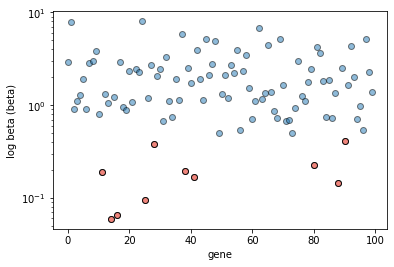

In [40]:
test_out = all_params[-1]
test_marks = all_marks[-1][0:num_marks]

plt.scatter(range(len(test_out[0,:,0])), 10**test_out[0,:,2],alpha=0.5,edgecolor='black')
plt.scatter(np.array(range(len(test_out[0,:,0])))[test_marks], 10**test_out[0,:,2][test_marks],color='salmon',alpha=0.9,edgecolor='black')
plt.yscale('log')
plt.xlabel('gene')
plt.ylabel('log beta (beta)')

Text(0, 0.5, 'log burst size (b)')

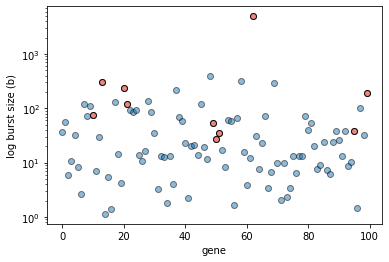

In [46]:
test_out = all_params[1]
test_marks = all_marks[1][0:num_marks]

plt.scatter(range(len(test_out[0,:,0])), 10**test_out[0,:,0],alpha=0.5,edgecolor='black')
plt.scatter(np.array(range(len(test_out[0,:,0])))[test_marks], 10**test_out[0,:,0][test_marks],color='salmon',alpha=0.9,edgecolor='black')
plt.yscale('log')
plt.xlabel('gene')
plt.ylabel('log burst size (b)')

[[1.        0.6751994]
 [0.6751994 1.       ]]


Text(0, 0.5, 'param mean U')

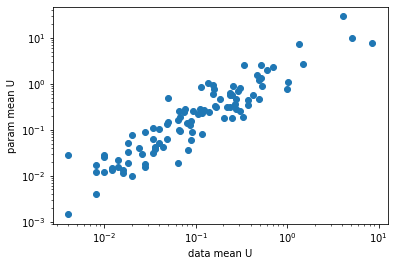

In [47]:
#Check relationship between means and means from params
k1 = all_counts[1][0:500,:,:]
k1.shape

sim_mean = test_out[0,:,0]+test_out[0,:,4]-test_out[0,:,1]
plt.scatter(np.mean(k1[:,:,0],axis=0),10**sim_mean )
print(np.corrcoef(np.mean(k1[:,:,0],axis=0),10**(sim_mean )))
plt.xscale("log")
plt.yscale("log")
plt.xlabel('data mean U')
plt.ylabel('param mean U')

In [48]:
test_cluster = all_counts[-3]

In [49]:
concat_types = np.concatenate((np.mean(test_cluster[0:500,:,:],axis=0),np.mean(test_cluster[500:1000,:,:],axis=0),
          np.mean(test_cluster[1000:1500,:,:],axis=0)),axis=1)


[Text(1, 0.5, '58'),
 Text(1, 1.5, '23'),
 Text(1, 2.5, '54'),
 Text(1, 3.5, '59'),
 Text(1, 4.5, '17'),
 Text(1, 5.5, '48'),
 Text(1, 6.5, '66'),
 Text(1, 7.5, '36'),
 Text(1, 8.5, '69'),
 Text(1, 9.5, '18'),
 Text(1, 10.5, '38'),
 Text(1, 11.5, '93'),
 Text(1, 12.5, '0'),
 Text(1, 13.5, '37'),
 Text(1, 14.5, '29'),
 Text(1, 15.5, '44'),
 Text(1, 16.5, '63'),
 Text(1, 17.5, '8'),
 Text(1, 18.5, '12'),
 Text(1, 19.5, '20'),
 Text(1, 20.5, '32'),
 Text(1, 21.5, '72'),
 Text(1, 22.5, '99'),
 Text(1, 23.5, '46'),
 Text(1, 24.5, '71'),
 Text(1, 25.5, '25'),
 Text(1, 26.5, '91'),
 Text(1, 27.5, '95'),
 Text(1, 28.5, '49'),
 Text(1, 29.5, '87'),
 Text(1, 30.5, '61'),
 Text(1, 31.5, '52'),
 Text(1, 32.5, '88'),
 Text(1, 33.5, '22'),
 Text(1, 34.5, '70'),
 Text(1, 35.5, '90'),
 Text(1, 36.5, '98'),
 Text(1, 37.5, '84'),
 Text(1, 38.5, '75'),
 Text(1, 39.5, '78'),
 Text(1, 40.5, '34'),
 Text(1, 41.5, '64'),
 Text(1, 42.5, '10'),
 Text(1, 43.5, '80'),
 Text(1, 44.5, '14'),
 Text(1, 45.5, '6'),
 

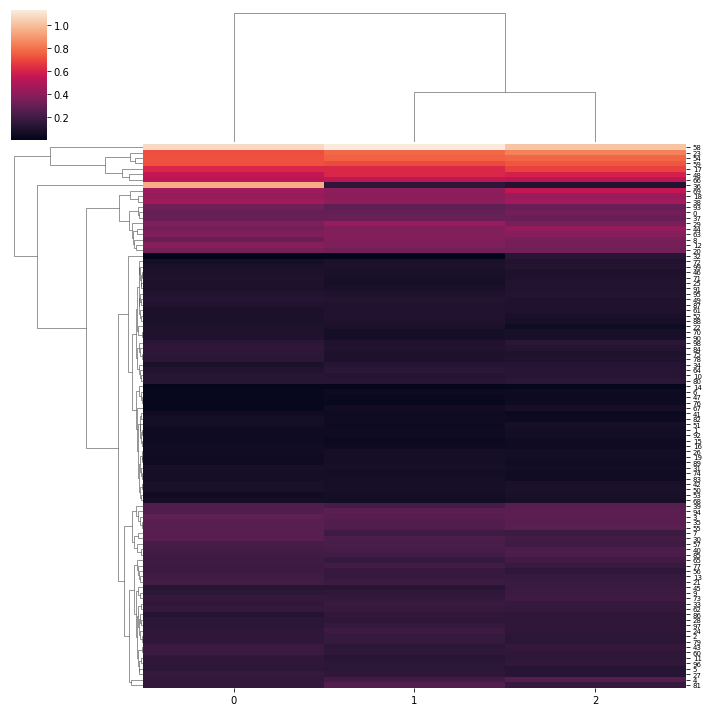

In [50]:
#How separated are clusters by 'DE genes,', Shows N and M
g = sns.clustermap(np.log1p(concat_types[:,[1,3,5]]),yticklabels=True)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 7)



[Text(1, 0.5, '37'),
 Text(1, 1.5, '13'),
 Text(1, 2.5, '59'),
 Text(1, 3.5, '88'),
 Text(1, 4.5, '89'),
 Text(1, 5.5, '8'),
 Text(1, 6.5, '77'),
 Text(1, 7.5, '63'),
 Text(1, 8.5, '9'),
 Text(1, 9.5, '28'),
 Text(1, 10.5, '48'),
 Text(1, 11.5, '7'),
 Text(1, 12.5, '32'),
 Text(1, 13.5, '42'),
 Text(1, 14.5, '30'),
 Text(1, 15.5, '57'),
 Text(1, 16.5, '65'),
 Text(1, 17.5, '97'),
 Text(1, 18.5, '70'),
 Text(1, 19.5, '72'),
 Text(1, 20.5, '4'),
 Text(1, 21.5, '12'),
 Text(1, 22.5, '91'),
 Text(1, 23.5, '16'),
 Text(1, 24.5, '47'),
 Text(1, 25.5, '26'),
 Text(1, 26.5, '33'),
 Text(1, 27.5, '93'),
 Text(1, 28.5, '67'),
 Text(1, 29.5, '87'),
 Text(1, 30.5, '84'),
 Text(1, 31.5, '45'),
 Text(1, 32.5, '79'),
 Text(1, 33.5, '24'),
 Text(1, 34.5, '22'),
 Text(1, 35.5, '68'),
 Text(1, 36.5, '49'),
 Text(1, 37.5, '0'),
 Text(1, 38.5, '85'),
 Text(1, 39.5, '1'),
 Text(1, 40.5, '35'),
 Text(1, 41.5, '36'),
 Text(1, 42.5, '53'),
 Text(1, 43.5, '6'),
 Text(1, 44.5, '54'),
 Text(1, 45.5, '46'),
 Text

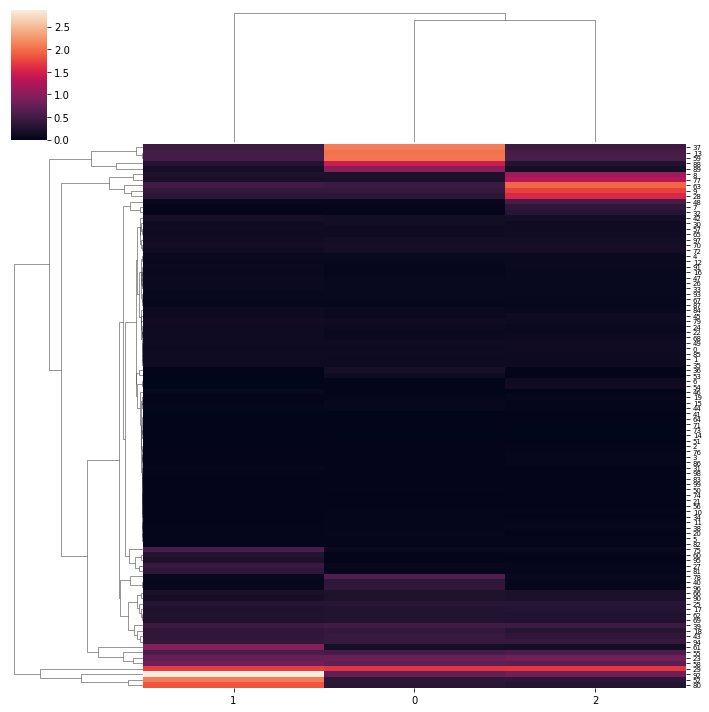

In [51]:
#How separated are clusters by 'DE genes,', Shows N and M
g = sns.clustermap(np.log1p(concat_types[:,[0,2,4]]),yticklabels=True)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 7)



Text(0, 0.5, 'Mature counts')

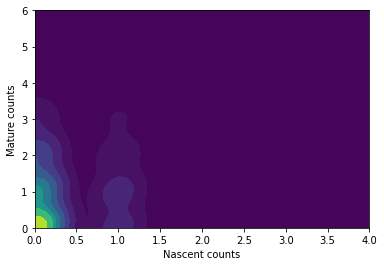

In [52]:
plt.figure()
test_gene = k1[:,50,:]
sns.kdeplot(x=test_gene[:,0], y=test_gene[:,1], cmap="viridis", shade=True, thresh=0)
plt.xlim(np.min(test_gene[:,0]),np.max(test_gene[:,0]))
plt.ylim(np.min(test_gene[:,1]),np.max(test_gene[:,1]))
plt.xlabel('Nascent counts')
plt.ylabel('Mature counts')


In [53]:
np.max(k1)

55.0

**Save count matrices for Monod**

In [85]:
!mkdir ~/counts/mixMod_sims
!mkdir ~/counts/mixMod_sims/loom/

mkdir: cannot create directory ‘/home/tchari/counts/mixMod_sims’: File exists
mkdir: cannot create directory ‘/home/tchari/counts/mixMod_sims/loom/’: File exists


In [54]:
out_names = ['single_clus_test','lowest_b_sim','lowest_b_beta_g_sim',
             'beta90_sim','lowest_beta90_sim',
             'beta100_sim','lowest_beta100_sim'] 

In [55]:
#And save clus labels for cells + barcodes for each cell in metadata + loom
out_path = '/home/tchari/counts/mixMod_sims/loom/'
geneNames = names_sub
for ind in range(len(out_names)):
    U = all_counts[ind][:,:,0]
    S = all_counts[ind][:,:,1]
    
    bars = [str(i) for i in range(n_cells*clus)]

    fname = out_path+out_names[ind]+'.loom'

    print('Making Loom')
    #Make loom of U/S
    retAdata = anndata.AnnData(
                X=sparse.csr_matrix(S),
                layers={
                    'spliced': sparse.csr_matrix(S),
                    'unspliced': sparse.csr_matrix(U),
                },
                obs=pd.DataFrame({'barcode': np.array(bars)},index=np.array(bars)),
                var=pd.DataFrame({'gene_name': geneNames},index=geneNames)
            )

    retAdata.write_loom(fname)
    print(fname)


Making Loom
/home/tchari/counts/mixMod_sims/loom/single_clus_test.loom
Making Loom
/home/tchari/counts/mixMod_sims/loom/lowest_b_sim.loom
Making Loom
/home/tchari/counts/mixMod_sims/loom/lowest_b_beta_g_sim.loom
Making Loom


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


/home/tchari/counts/mixMod_sims/loom/beta90_sim.loom
Making Loom
/home/tchari/counts/mixMod_sims/loom/lowest_beta90_sim.loom
Making Loom
/home/tchari/counts/mixMod_sims/loom/beta100_sim.loom
Making Loom
/home/tchari/counts/mixMod_sims/loom/lowest_beta100_sim.loom


In [56]:
#----- EXTRA CONTROL: Make loom with just one cluster, for comparing to Monod fits -----
out_path = '/home/tchari/counts/mixMod_sims/loom/'
U = all_counts[1][0:n_cells,:,0]
S = all_counts[1][0:n_cells,:,1]
geneNames = names_sub
bs = [str(i) for i in range(n_cells)]

fname = out_path+'oneClus_lowest_b_sim.loom'

print('Making Loom')
#Make loom of U/S
retAdata = anndata.AnnData(
			X=sparse.csr_matrix(S),
			layers={
				'spliced': sparse.csr_matrix(S),
				'unspliced': sparse.csr_matrix(U),
			},
			obs=pd.DataFrame({'barcode': np.array(bs)},index=np.array(bs)),
			var=pd.DataFrame({'gene_name': geneNames},index=geneNames)
		)

retAdata.write_loom(fname)
print(fname)

Making Loom
/home/tchari/counts/mixMod_sims/loom/oneClus_lowest_b_sim.loom


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


In [57]:
#----- EXTRA CONTROL: Make loom with just one cluster, for comparing to Monod fits, for b,beta and gamma sim -----
out_path = '/home/tchari/counts/mixMod_sims/loom/'
U = all_counts[2][0:n_cells,:,0]
S = all_counts[2][0:n_cells,:,1]
geneNames = names_sub
bs = [str(i) for i in range(n_cells)]

fname = out_path+'oneClus_lowest_b_beta_g_sim.loom'

print('Making Loom')
#Make loom of U/S
retAdata = anndata.AnnData(
			X=sparse.csr_matrix(S),
			layers={
				'spliced': sparse.csr_matrix(S),
				'unspliced': sparse.csr_matrix(U),
			},
			obs=pd.DataFrame({'barcode': np.array(bs)},index=np.array(bs)),
			var=pd.DataFrame({'gene_name': geneNames},index=geneNames)
		)

retAdata.write_loom(fname)
print(fname)

Making Loom
/home/tchari/counts/mixMod_sims/loom/oneClus_lowest_b_beta_g_sim.loom


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


In [102]:
out_path = '/home/tchari/counts/mixMod_sims/loom/'
U = all_counts[3][0:n_cells,:,0]
S = all_counts[3][0:n_cells,:,1]
geneNames = names_sub
bs = [str(i) for i in range(n_cells)]

fname = out_path+'oneClus_beta90_sim.loom'

print('Making Loom')
#Make loom of U/S
retAdata = anndata.AnnData(
			X=sparse.csr_matrix(S),
			layers={
				'spliced': sparse.csr_matrix(S),
				'unspliced': sparse.csr_matrix(U),
			},
			obs=pd.DataFrame({'barcode': np.array(bs)},index=np.array(bs)),
			var=pd.DataFrame({'gene_name': geneNames},index=geneNames)
		)

retAdata.write_loom(fname)
print(fname)

Making Loom
/home/tchari/counts/mixMod_sims/loom/oneClus_beta90_sim.loom


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


In [351]:
# #Check loom ok
# ds = lp.connect('/home/tchari/counts/mixMod_sims/loom/b_sim.loom')

In [352]:
# ds

In [353]:
# ds.close()

## **Run Inference**

In [103]:
rep_data = list(np.repeat(out_names,5))+['oneClus_lowest_b_sim']+['oneClus_lowest_b_beta_g_sim']+['oneClus_beta90_sim']
ks = [1,2,3,4,5]*len(out_names)+[1,1,1]

dataset_meta = rep_data #['burst_mark_sim','oneClus_burst_mark_sim']
print('dataset_meta: ', dataset_meta)
print()


cluster_names = []

d_names = []
for i in range(len(ks)):
    d_names += [rep_data[i]+'_k'+str(ks[i])]
    
dataset_names = d_names  #To save
print('dataset_names: ', dataset_names)
print('len(dataset_names): ',len(dataset_names))
print()

raw_data_locations = rep_data 
transcriptome_filepath = '/home/tchari/perturbCME/notebooks/mmSim_genome_polyA_cum_3' #'gg_200525_genome_polyA_cum_3'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

loom_filepaths = ['/home/tchari/counts/mixMod_sims/loom/'+x+'.loom' for x in raw_data_locations] 
print('loom_filepaths: ',loom_filepaths)

n_datasets = len(loom_filepaths)

dataset_meta:  ['single_clus_test', 'single_clus_test', 'single_clus_test', 'single_clus_test', 'single_clus_test', 'lowest_b_sim', 'lowest_b_sim', 'lowest_b_sim', 'lowest_b_sim', 'lowest_b_sim', 'lowest_b_beta_g_sim', 'lowest_b_beta_g_sim', 'lowest_b_beta_g_sim', 'lowest_b_beta_g_sim', 'lowest_b_beta_g_sim', 'beta90_sim', 'beta90_sim', 'beta90_sim', 'beta90_sim', 'beta90_sim', 'lowest_beta90_sim', 'lowest_beta90_sim', 'lowest_beta90_sim', 'lowest_beta90_sim', 'lowest_beta90_sim', 'beta100_sim', 'beta100_sim', 'beta100_sim', 'beta100_sim', 'beta100_sim', 'lowest_beta100_sim', 'lowest_beta100_sim', 'lowest_beta100_sim', 'lowest_beta100_sim', 'lowest_beta100_sim', 'oneClus_lowest_b_sim', 'oneClus_lowest_b_beta_g_sim', 'oneClus_beta90_sim']

dataset_names:  ['single_clus_test_k1', 'single_clus_test_k2', 'single_clus_test_k3', 'single_clus_test_k4', 'single_clus_test_k5', 'lowest_b_sim_k1', 'lowest_b_sim_k2', 'lowest_b_sim_k3', 'lowest_b_sim_k4', 'lowest_b_sim_k5', 'lowest_b_beta_g_sim_k1'

In [104]:
print(n_datasets)

38


Dataset single_clus_test. 
	1500 barcodes in loom, 0 pass filter. 1500 in annotations; of these, 1500 in loom and 0 in filtered loom.
	Keep All: 1500 cells in annotations. 1500 in loom. 1500 pass filter.
Dataset single_clus_test. 
	1500 barcodes in loom, 0 pass filter. 1500 in annotations; of these, 1500 in loom and 0 in filtered loom.
	Keep All: 1500 cells in annotations. 1500 in loom. 1500 pass filter.
Dataset single_clus_test. 
	1500 barcodes in loom, 0 pass filter. 1500 in annotations; of these, 1500 in loom and 0 in filtered loom.
	Keep All: 1500 cells in annotations. 1500 in loom. 1500 pass filter.
Dataset single_clus_test. 
	1500 barcodes in loom, 0 pass filter. 1500 in annotations; of these, 1500 in loom and 0 in filtered loom.
	Keep All: 1500 cells in annotations. 1500 in loom. 1500 pass filter.
Dataset single_clus_test. 
	1500 barcodes in loom, 0 pass filter. 1500 in annotations; of these, 1500 in loom and 0 in filtered loom.
	Keep All: 1500 cells in annotations. 1500 in loom

/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


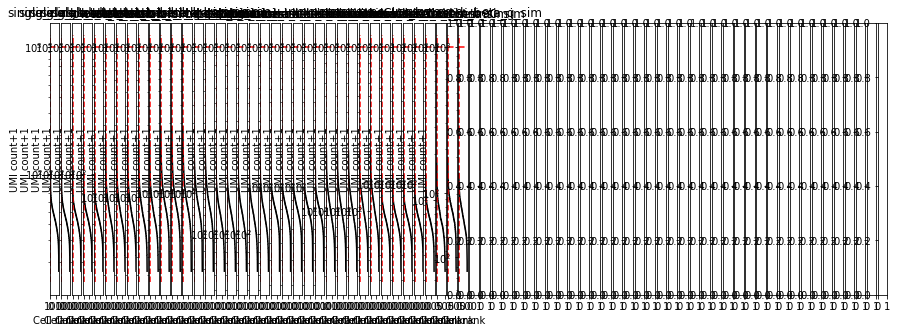

In [105]:
#Not filtering cells for now
cf = []
thr_lb = [1e3]*len(dataset_meta)*2

fig1,ax1 = plt.subplots(1,len(dataset_meta)*2,figsize=(15,5))

for k in range(len(dataset_meta)):
    filename = loom_filepaths[k]
    dataset_name = raw_data_locations[k]
    
    with lp.connect(filename,mode='r') as ds:
        S = ds.layers[spliced_layer][:]
        U = ds.layers[unspliced_layer][:]
        gene_names = ds.ra[gene_attr]
        bcs = ds.ca[cell_attr]
        cells = S.shape[1]
        monod.preprocess.knee_plot(S+U,ax1[k],viz=True,thr=thr_lb[k])
        cf_ = ((S+U).sum(0)>thr_lb[k])
        
        n_annot_bcs = len(bcs)
        annot_bcs_in_loom = len(bcs)
        annot_bcs_in_filt_loom = cf_.sum()
        print(f'Dataset {dataset_name}. \n\t{len(bcs)} barcodes in loom, {cf_.sum()} pass filter. {n_annot_bcs} in annotations; of these, {annot_bcs_in_loom} in loom and {annot_bcs_in_filt_loom} in filtered loom.')
        
        #if k==0:
        #for subcluster in subcluster_names:
        subcluster = 'Keep All'
        annot_bcs = bcs
        #cf.append(np.isin(bcs,annot_bcs) & cf_)
        cf.append(np.isin(bcs,annot_bcs))
        print(f'\t{subcluster}: {len(annot_bcs)} cells in annotations. {np.isin(bcs,annot_bcs).sum()} in loom. {cf[-1].sum()} pass filter.')



    ax1[k].set_title(dataset_name)
    
!mkdir ./figs    
fig_dir = './figs/'
fig_string = fig_dir + 'kneeplots_burst_mark_sim_forMM.png'
fig1.tight_layout()
plt.savefig(fig_string,dpi=450)

In [106]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)

In [107]:
#Define bounds, from 20220930_normanfit_monod.ipynb
phys_lb = [-2.0, -1.8, -1.8 ] #-1.0, -1.8, -1.8
phys_ub = [4.2, 2.5, 2.5] #4.2, 2.5, 3.5
samp_lb = [-7.157894736842105, -1.525] #-7.5, -2
samp_ub = [-7.157894736842105, -1.525] #-5.5, 0
# gridsize = [5,6]
gridsize = [1,1]


(array([ 5.,  6., 11., 18., 19., 12., 11., 13.,  2.,  3.]),
 array([-4.42100252e-05,  2.63758273e-01,  5.27560756e-01,  7.91363240e-01,
         1.05516572e+00,  1.31896821e+00,  1.58277069e+00,  1.84657317e+00,
         2.11037566e+00,  2.37417814e+00,  2.63798062e+00]),
 <BarContainer object of 10 artists>)

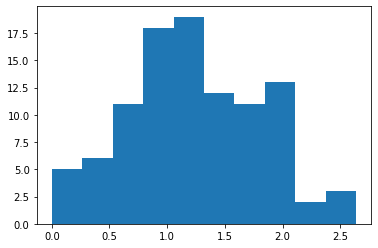

In [64]:
plt.hist((params[0,:,0]))

In [35]:
# k=3
# epochs=10

INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1 already exists.
INFO:root:Dataset: single_clus_test_k1
INFO:root:1500 cells detected.
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:28 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/single_clus_test_k1 already exists.
INFO:root:Dataset: single_clus_test_k2
INFO:root:1500 cells detected.
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:28 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/single_clus_test_k2 already exists.
INFO:root:Dataset: single_clus_test_k3
INFO:root:1500 cells detected.
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:28 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/single_clus_test_k3 already e

/home/tchari/monod/src/monod/preprocess.py:193: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig1, ax1 = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))


INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/lowest_beta90_sim_k5 already exists.
INFO:root:Dataset: beta100_sim_k1
INFO:root:1500 cells detected.
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:33 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/beta100_sim_k1 already exists.
INFO:root:Dataset: beta100_sim_k2
INFO:root:1500 cells detected.
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:33 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/beta100_sim_k2 already exists.
INFO:root:Dataset: beta100_sim_k3
INFO:root:1500 cells detected.
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:33 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/beta100_sim_k3 already exists.
INFO:root:Dataset: beta100_sim_k4
INFO:root:1500 cells d

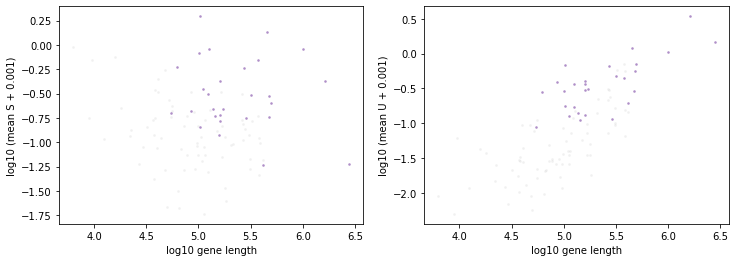

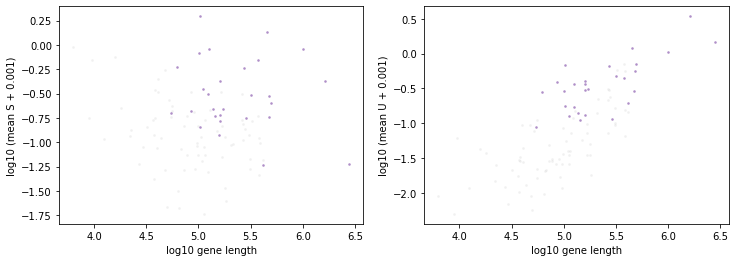

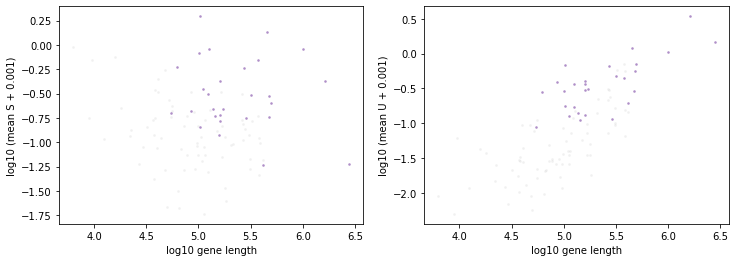

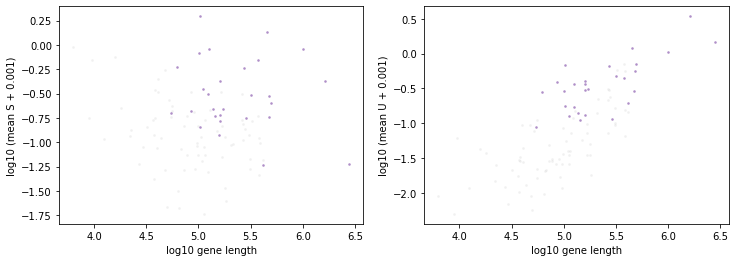

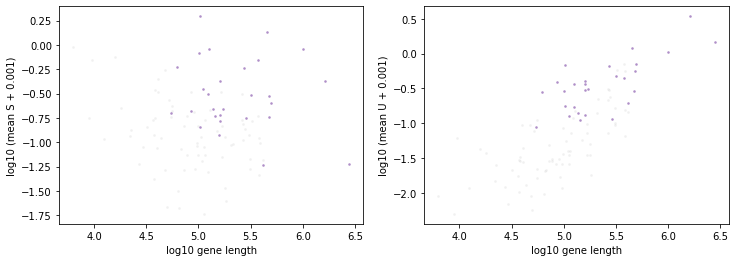

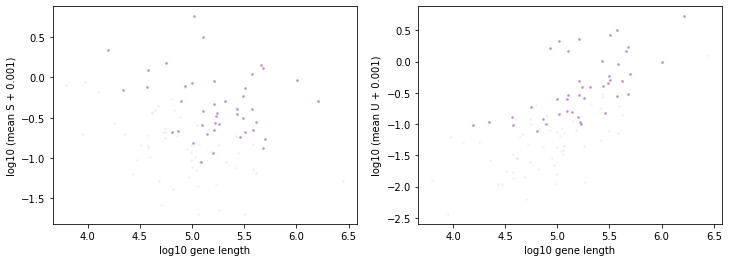

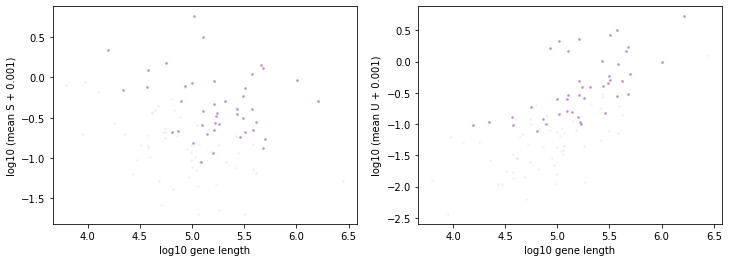

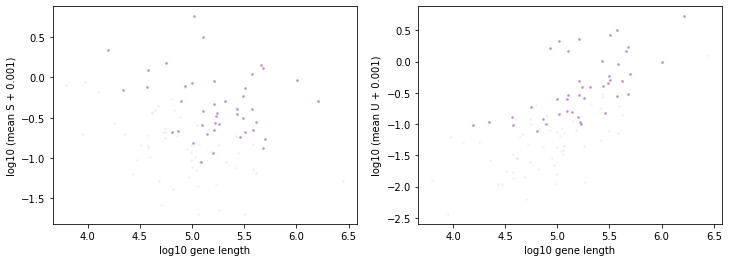

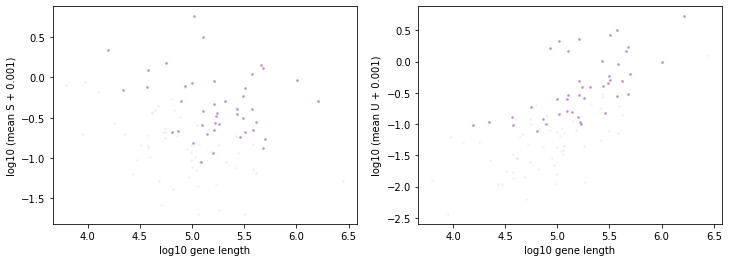

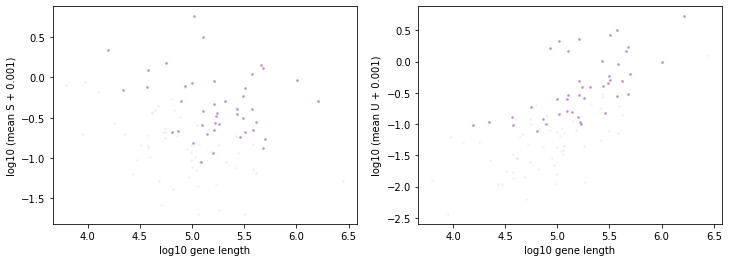

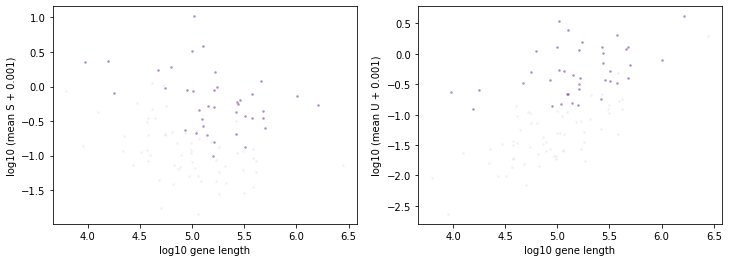

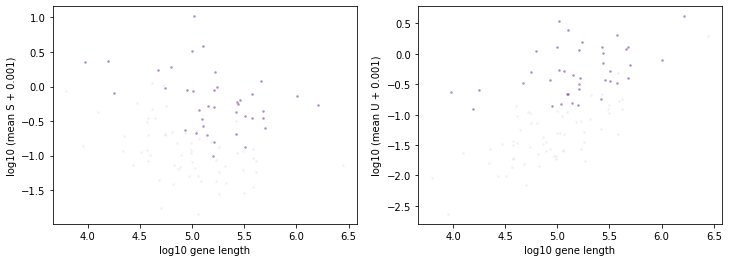

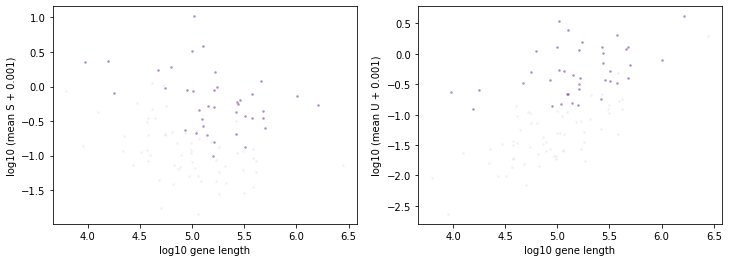

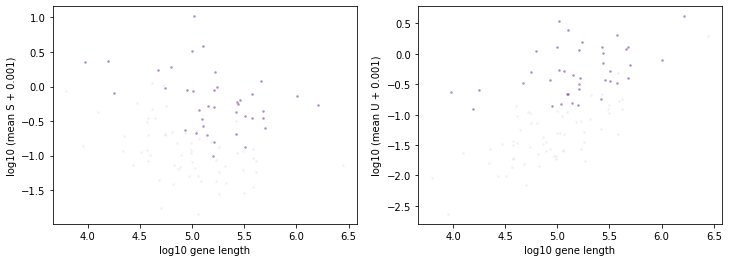

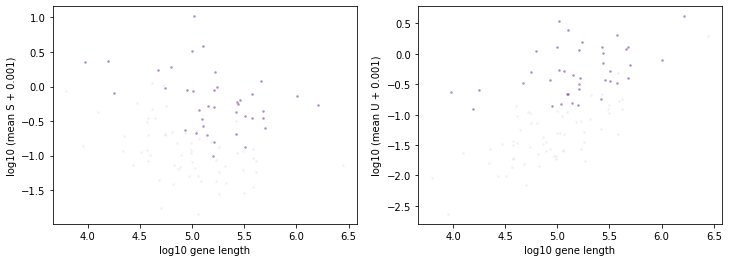

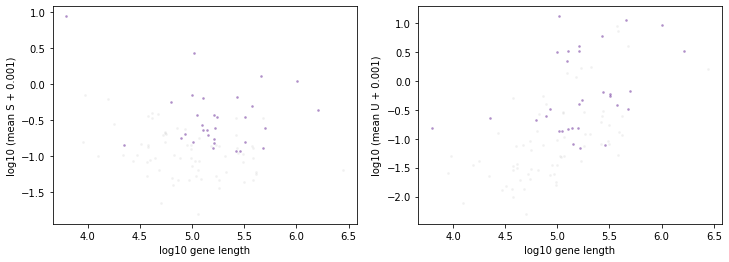

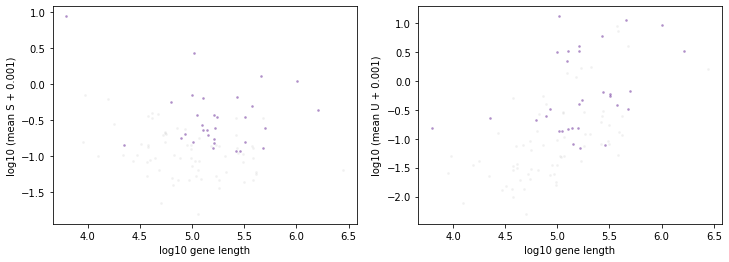

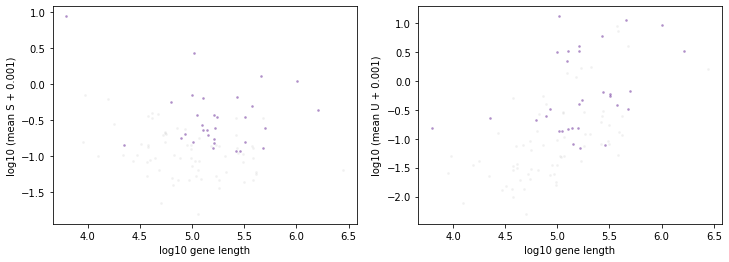

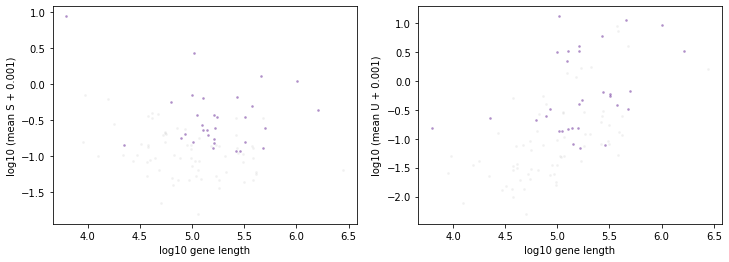

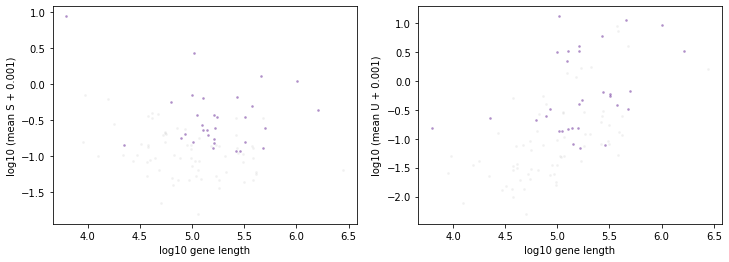

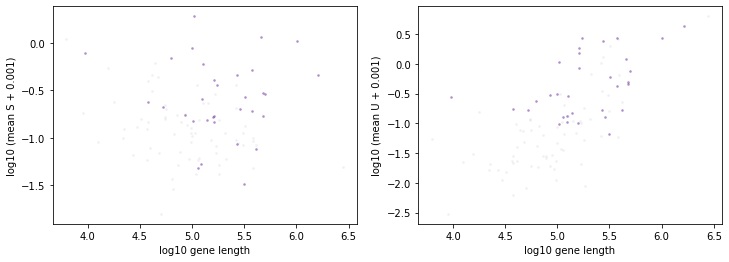

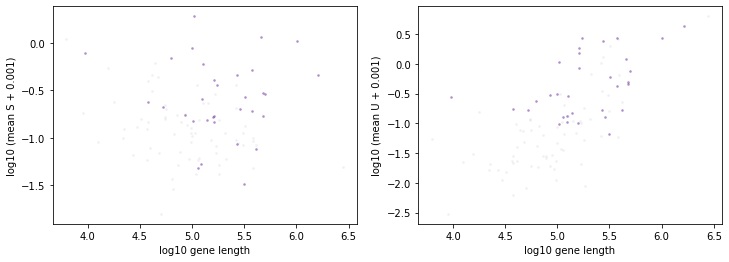

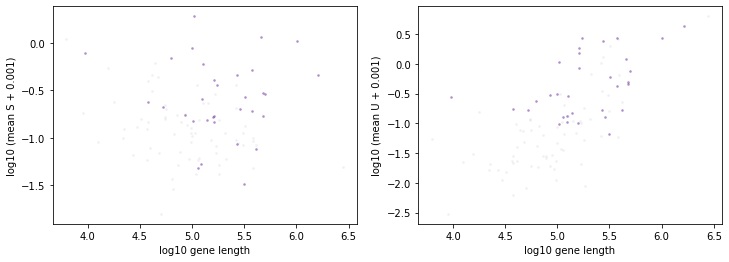

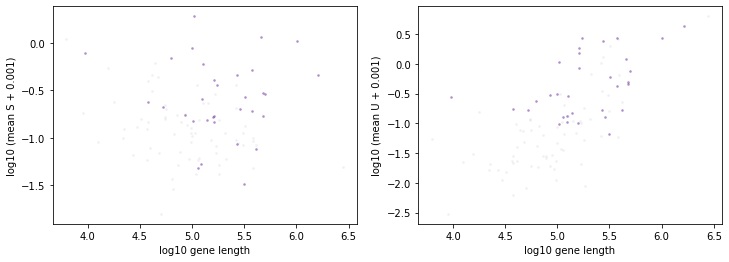

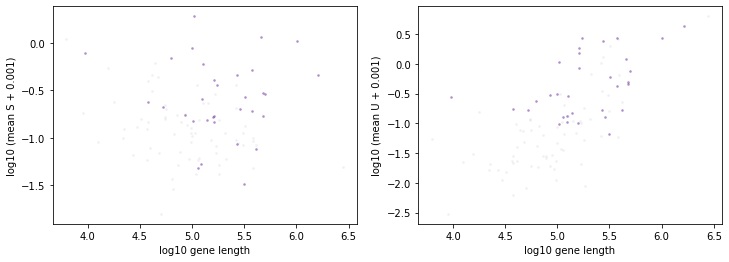

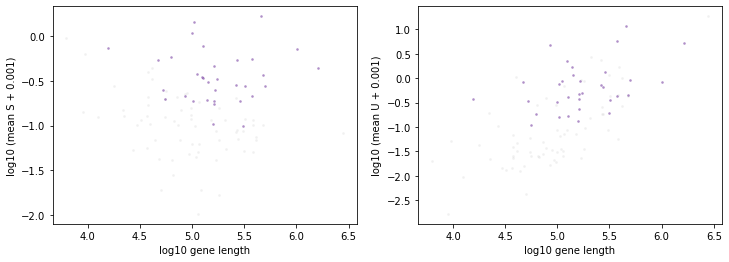

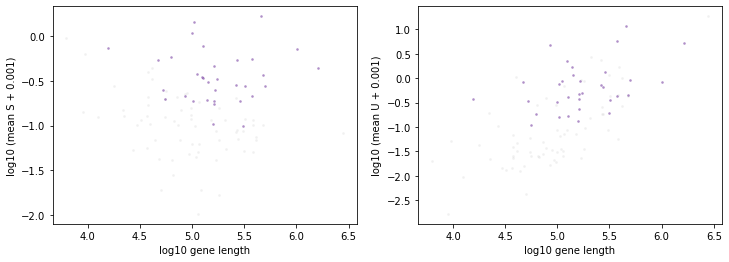

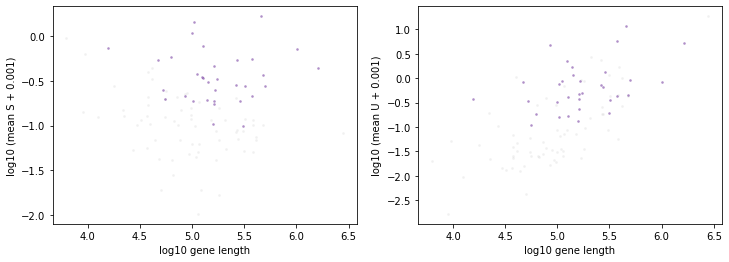

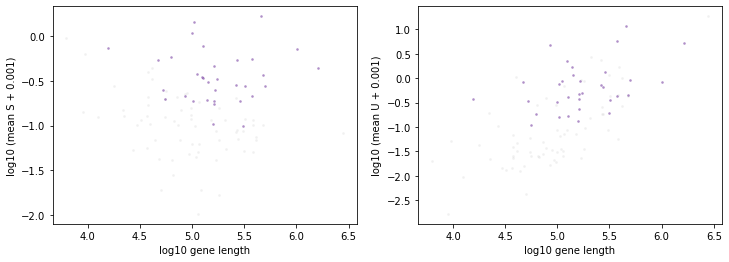

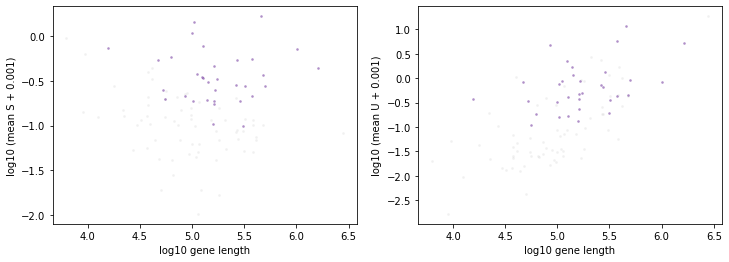

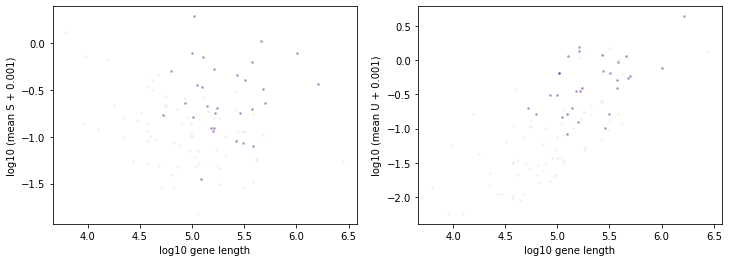

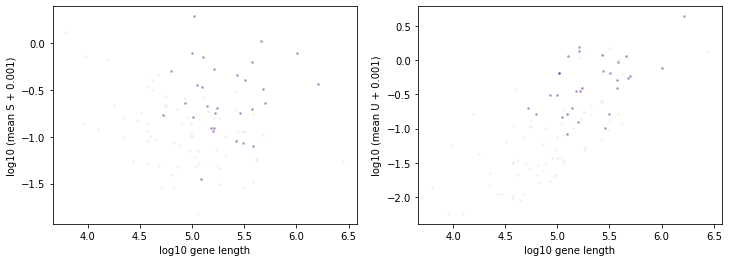

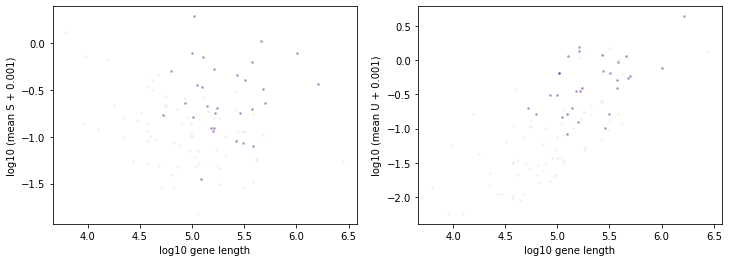

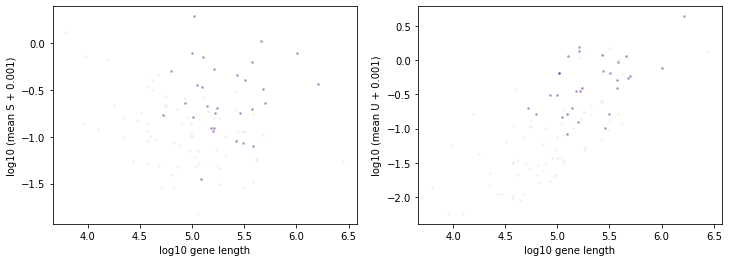

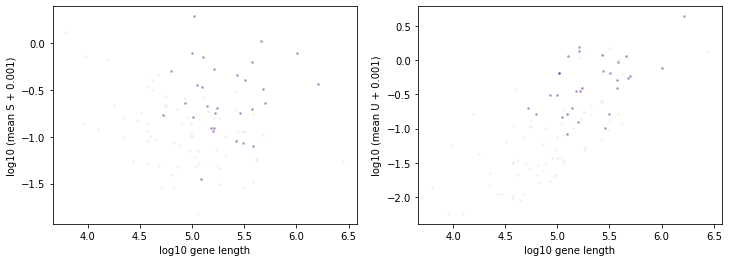

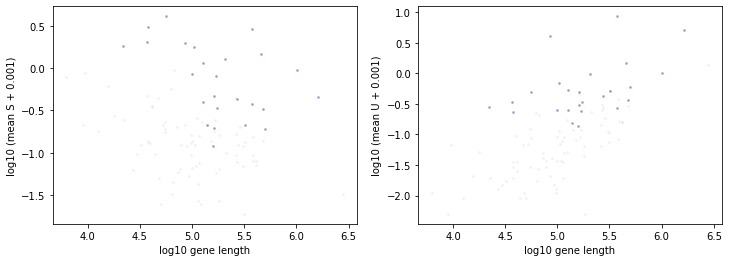

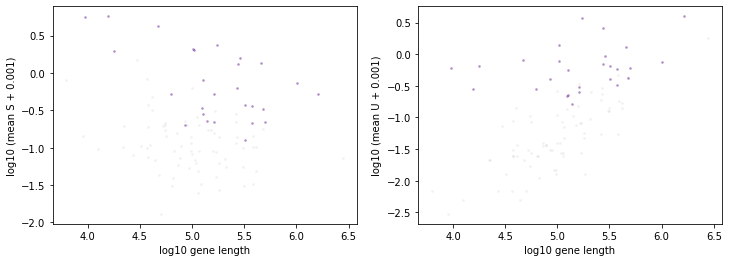

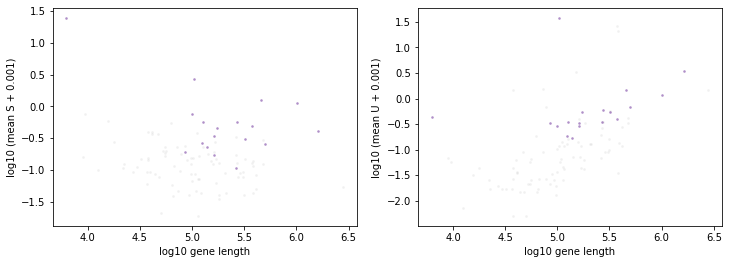

In [108]:
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='simTests_MM',batch_id=1,\
                                             datestring='230412', n_genes=100,exp_filter_threshold=None,cf=cf) #230411

**Control test with standard Monod fit on first, known cluster of cells**

INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/oneClus_lowest_b_sim_k1/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230412_025_simTests_MM_1/oneClus_lowest_b_sim_k1/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: oneClus_lowest_b_sim_k1
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/oneClus_lowest_b_sim_k1/diagnostic_figures already exists.
INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/oneClus_lowest_b_sim_k1/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.20s/it]

INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/oneClus_lowest_b_sim_k1/Bursty_Poisson_1x1/analysis_figures already exists.
INFO:root:Runtime: 2.8 seconds.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/oneClus_lowest_b_beta_g_sim_k1/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230412_025_simTests_MM_1/oneClus_lowest_b_beta_g_sim_k1/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: oneClus_lowest_b_beta_g_sim_k1
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.


INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/oneClus_lowest_b_beta_g_sim_k1/diagnostic_figures already exists.
INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/oneClus_lowest_b_beta_g_sim_k1/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.44s/it]

INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/oneClus_lowest_b_beta_g_sim_k1/Bursty_Poisson_1x1/analysis_figures already exists.
INFO:root:Runtime: 3.0 seconds.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/oneClus_beta90_sim_k1/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230412_025_simTests_MM_1/oneClus_beta90_sim_k1/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: oneClus_beta90_sim_k1
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/oneClus_beta90_sim_k1/diagnostic_figures created.


INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/oneClus_beta90_sim_k1/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.30s/it]

INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/oneClus_beta90_sim_k1/Bursty_Poisson_1x1/analysis_figures created.
INFO:root:Runtime: 2.8 seconds.


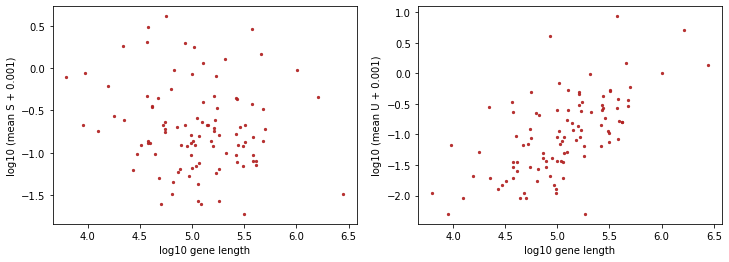

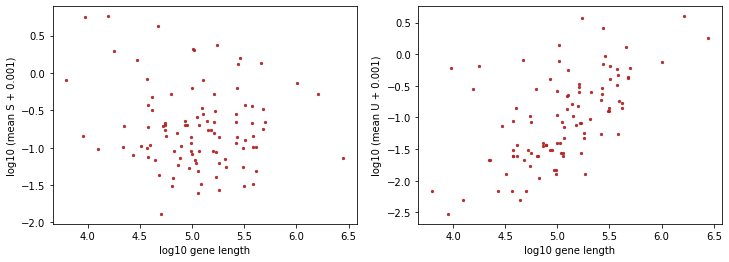

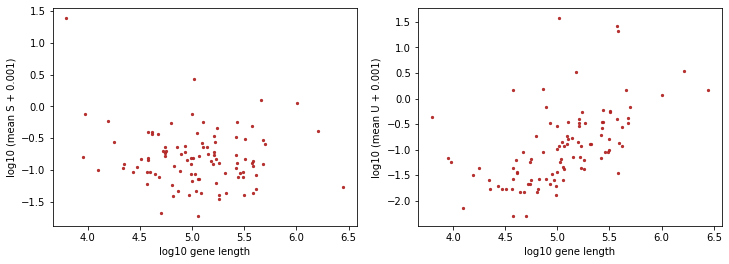

In [109]:
#Control test with standard Monod fit on first, known cluster of cells
result_strings = []
#for i in range(1,2): #n_datasets
for i in range(len(ks)-3,len(ks)):

    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')

    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = True,
                gradient_params = {'max_iterations':20,'init_pattern':'moments','num_restarts':1})

    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, dataset_attr_names=attribute_names,cf=cf[i])

    full_result_string = inference_parameters.fit_all_grid_points(30,search_data)

    result_strings.append(full_result_string)

In [110]:
sr = [monod.analysis.load_search_results(i) for i in result_strings]
sr

INFO:root:Grid scan results loaded from ./fits/gg_230412_025_simTests_MM_1/oneClus_lowest_b_sim_k1/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230412_025_simTests_MM_1/oneClus_lowest_b_beta_g_sim_k1/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230412_025_simTests_MM_1/oneClus_beta90_sim_k1/Bursty_Poisson_1x1/grid_scan_results.res.


**Run Mixture Model on all cells**

In [68]:
epochs=20

Show k-means inits

INFO:root:Beginning data extraction.
INFO:root:Dataset: single_clus_test_k1
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/single_clus_test_k1/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: single_clus_test_k2
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/single_clus_test_k2/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: single_clus_test_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/single_clus_test_k3/raw.sd.
INFO

/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_beta90_sim_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/lowest_beta90_sim_k3/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_beta90_sim_k4
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/lowest_beta90_sim_k4/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_beta90_sim_k5
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/lowest_beta90_sim_k5/raw.sd

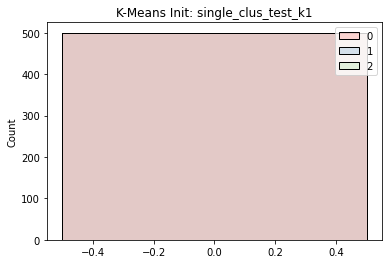

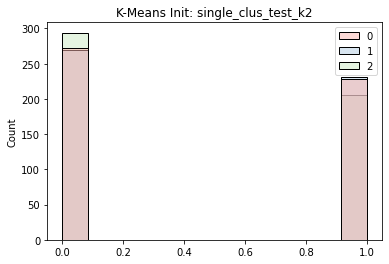

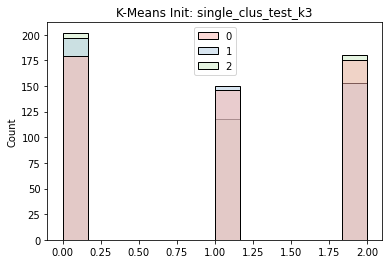

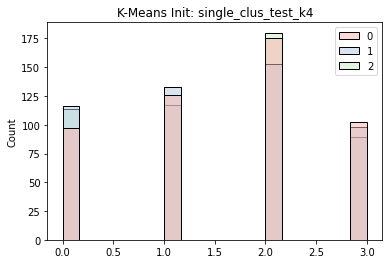

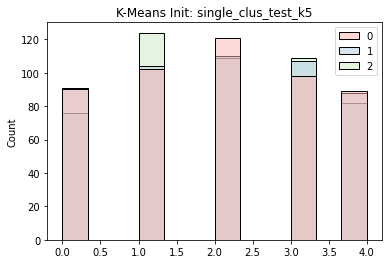

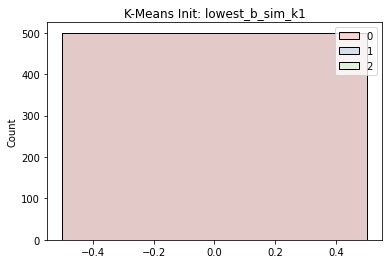

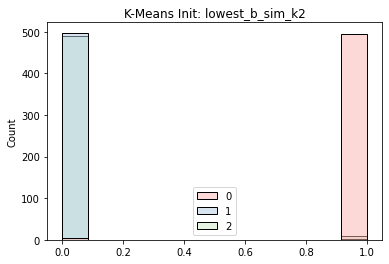

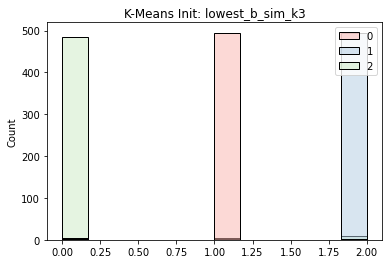

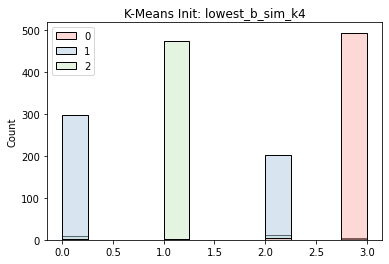

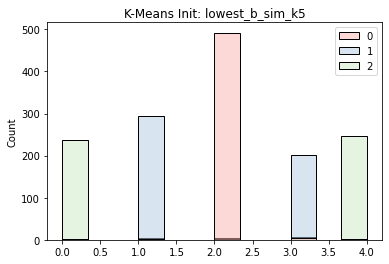

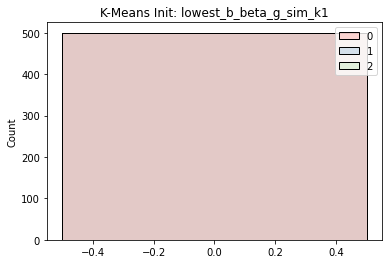

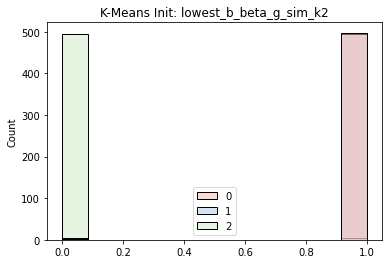

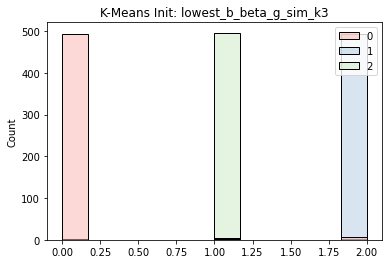

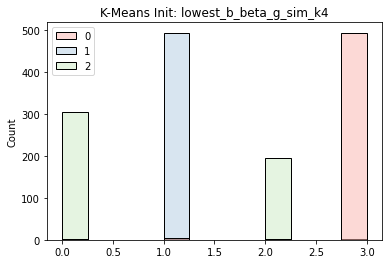

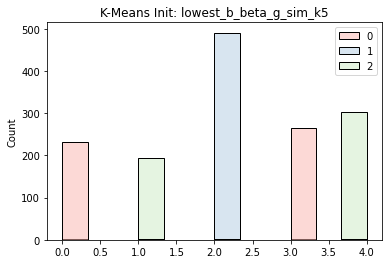

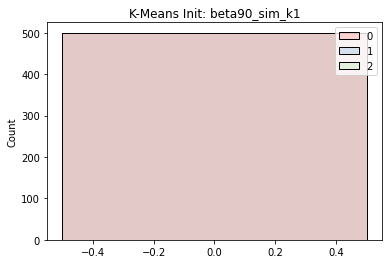

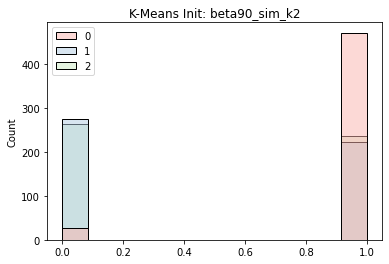

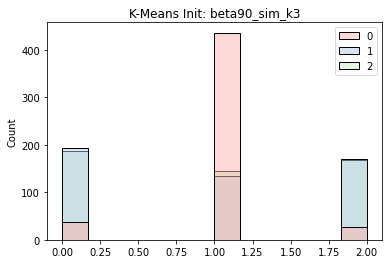

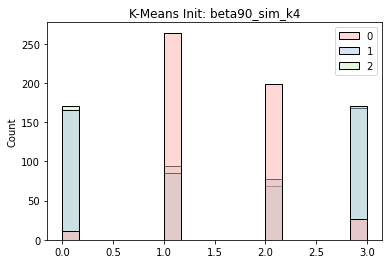

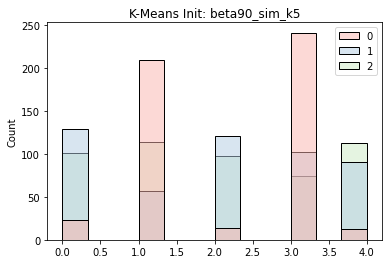

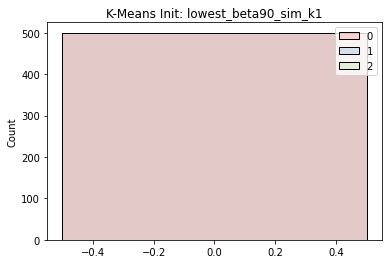

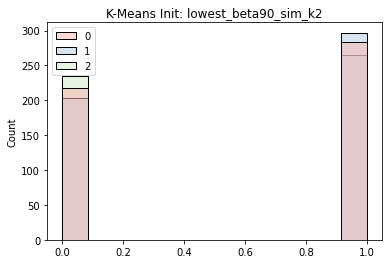

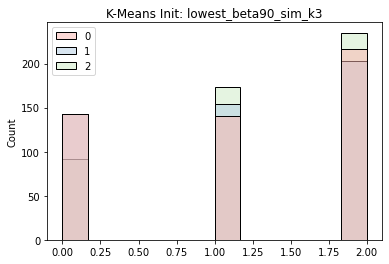

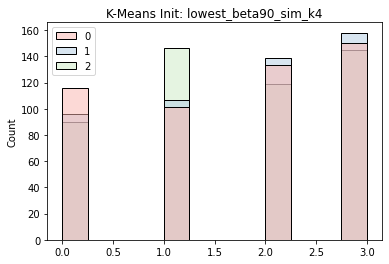

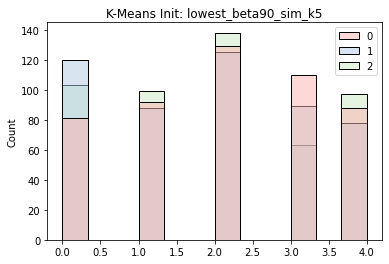

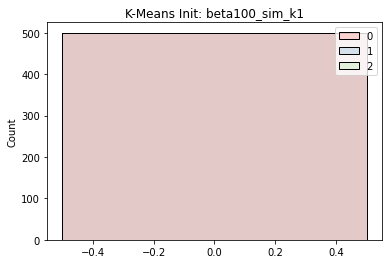

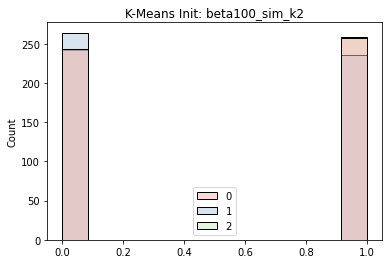

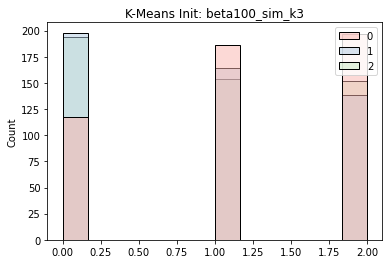

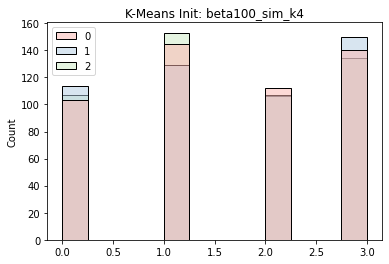

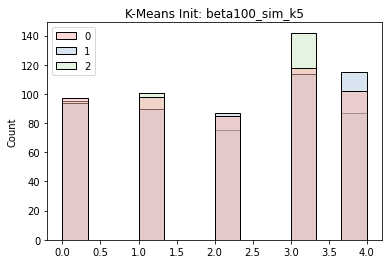

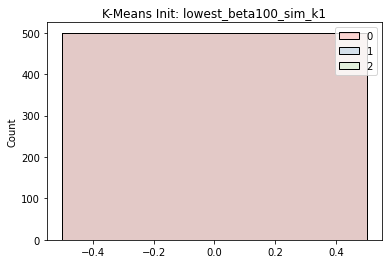

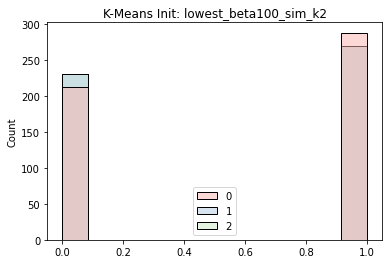

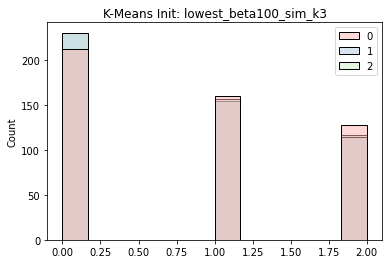

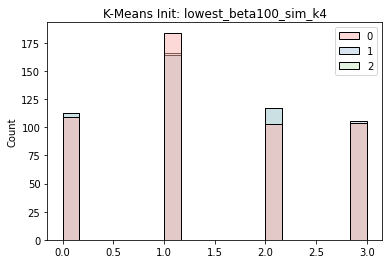

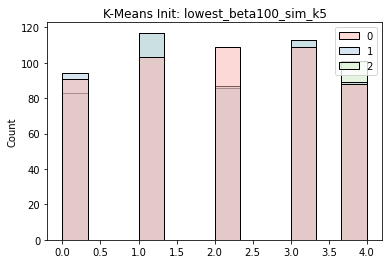

In [69]:
for i in range(len(ks)-3):
    which = i
    search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
                dataset_strings[which], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[which])
    
    S = search_data.layers[1,:,:]
    S_t = S.T
    tots = np.sum(S_t,axis=1)
    divids = (1e4/tots)[:,None]
    S_t = S_t*divids
    S_t = np.log1p(S_t)

    kmeans = KMeans(n_clusters=ks[i], random_state=0).fit(S_t)
    labs = kmeans.labels_

    labels = labs
    plt.figure()
    sns.histplot(x=labels,hue=pd.Categorical([0]*500+[1]*500+[2]*500), kde=False,palette='Pastel1')
    plt.title('K-Means Init: '+dataset_names[i])

    
    

INFO:root:Beginning data extraction.
INFO:root:Dataset: single_clus_test_k1
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/single_clus_test_k1/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: single_clus_test_k2
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/single_clus_test_k2/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: single_clus_test_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/single_clus_test_k3/raw.sd.
INFO

/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_beta90_sim_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/lowest_beta90_sim_k3/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_beta90_sim_k4
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/lowest_beta90_sim_k4/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_beta90_sim_k5
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/lowest_beta90_sim_k5/raw.sd

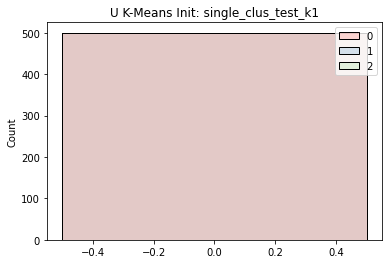

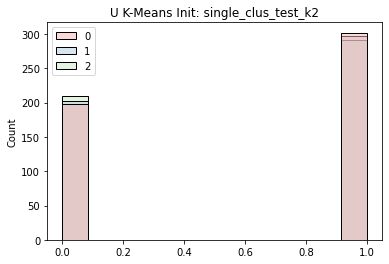

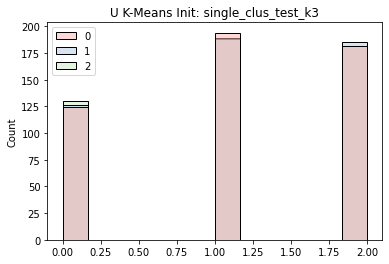

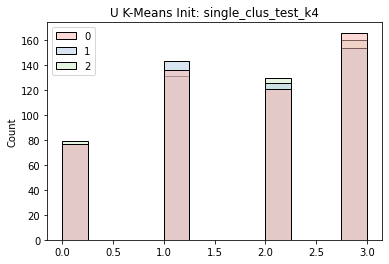

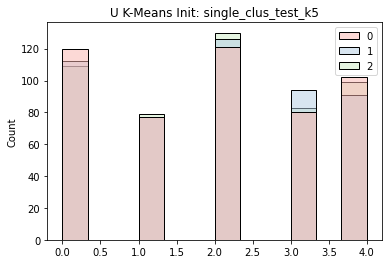

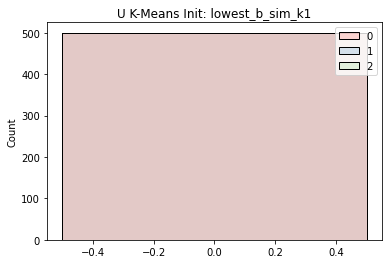

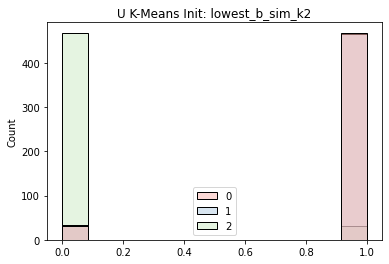

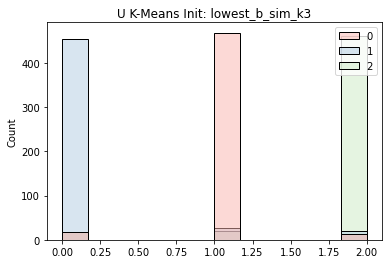

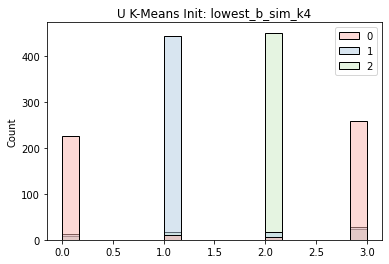

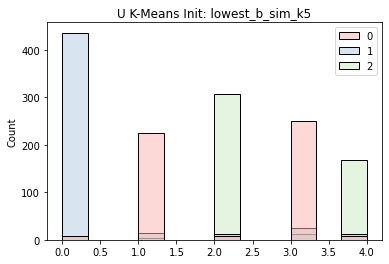

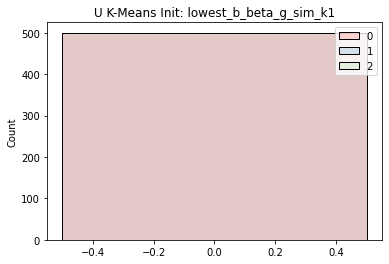

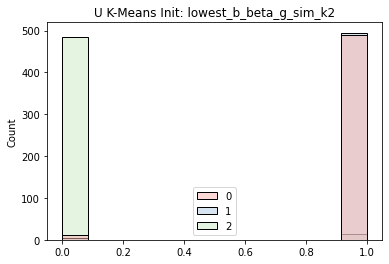

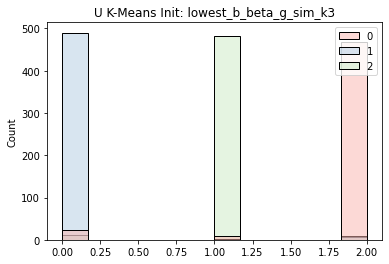

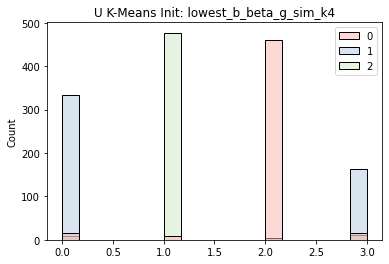

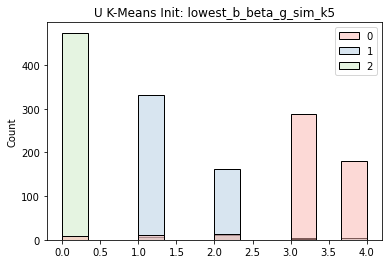

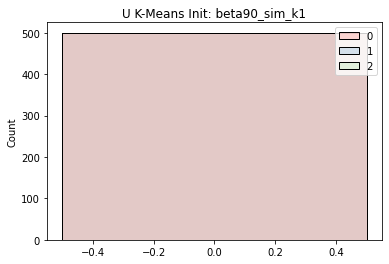

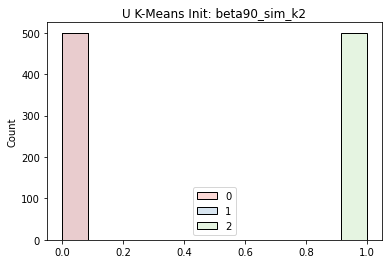

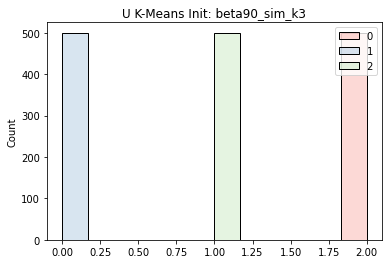

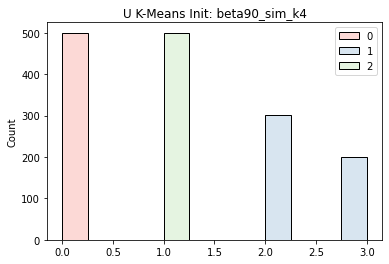

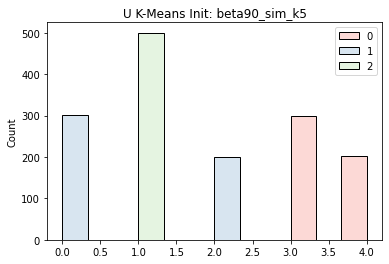

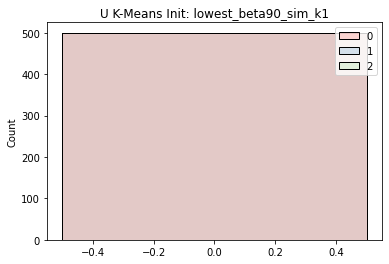

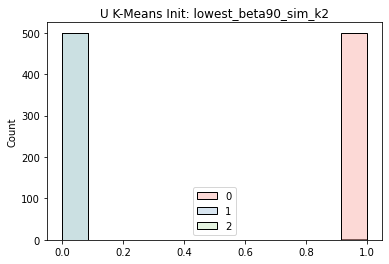

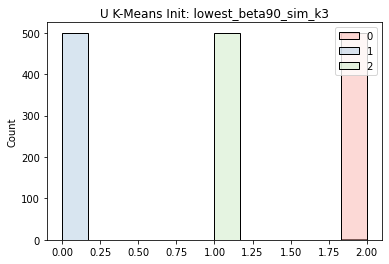

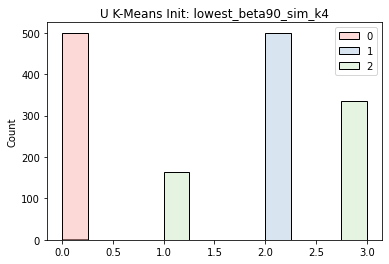

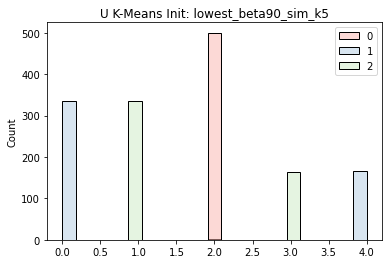

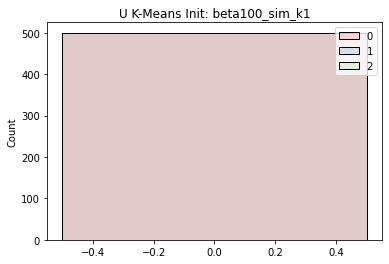

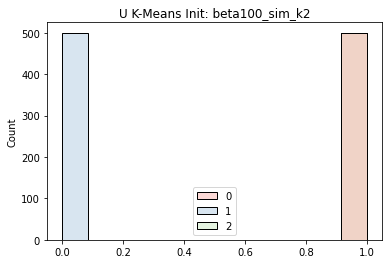

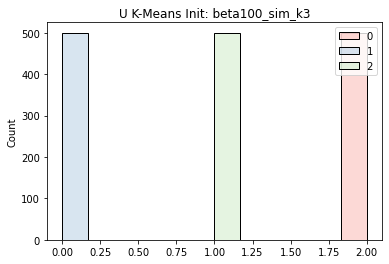

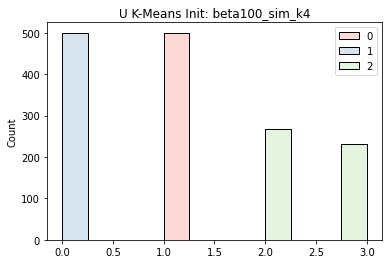

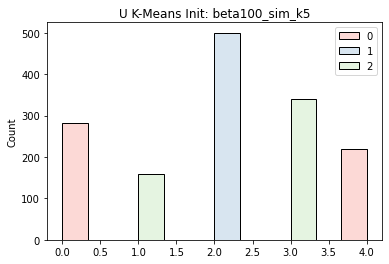

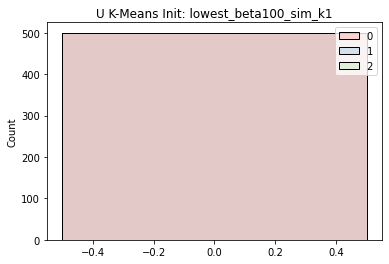

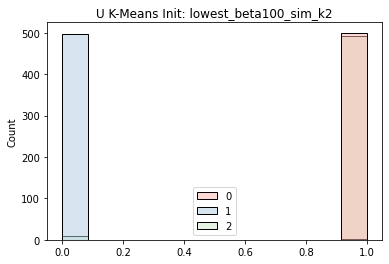

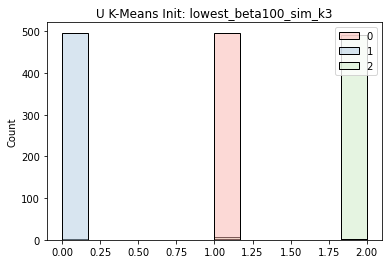

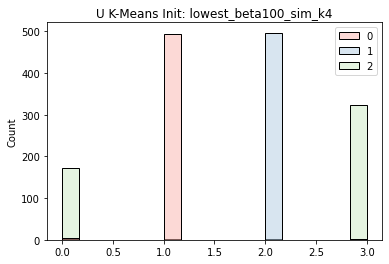

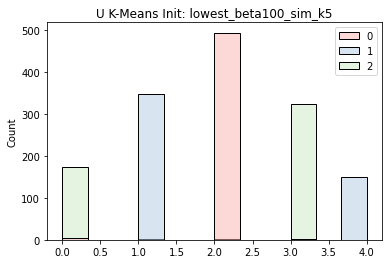

In [87]:
for i in range(len(ks)-3):
    which = i
    search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
                dataset_strings[which], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[which])
    
    S = search_data.layers[0,:,:]
    S_t = S.T
    tots = np.sum(S_t,axis=1)
    divids = (1e4/tots)[:,None]
    S_t = S_t*divids
    S_t = np.log1p(S_t)

    kmeans = KMeans(n_clusters=ks[i], random_state=0).fit(S_t)
    labs = kmeans.labels_

    labels = labs
    plt.figure()
    sns.histplot(x=labels,hue=pd.Categorical([0]*500+[1]*500+[2]*500), kde=False,palette='Pastel1')
    plt.title('U K-Means Init: '+dataset_names[i])

    
    

INFO:root:Beginning data extraction.
INFO:root:Dataset: single_clus_test_k1
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/single_clus_test_k1/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: single_clus_test_k2
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/single_clus_test_k2/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: single_clus_test_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/single_clus_test_k3/raw.sd.
INFO

/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_beta90_sim_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/lowest_beta90_sim_k3/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_beta90_sim_k4
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/lowest_beta90_sim_k4/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_beta90_sim_k5
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/lowest_beta90_sim_k5/raw.sd

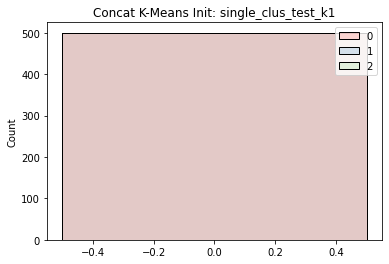

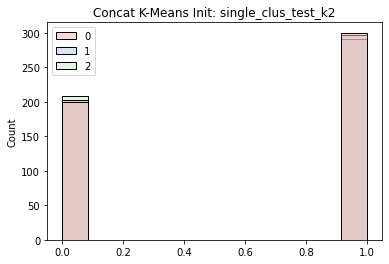

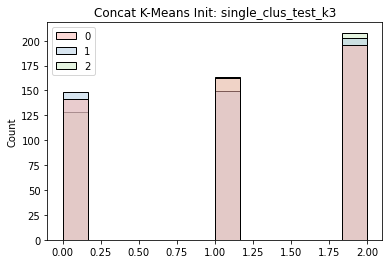

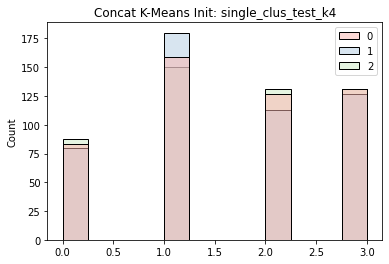

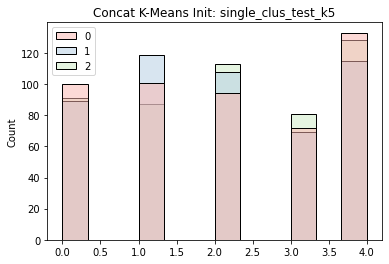

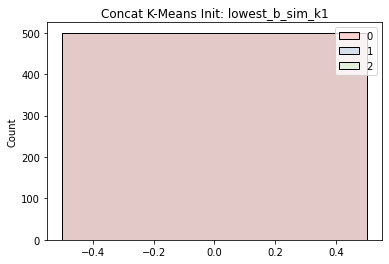

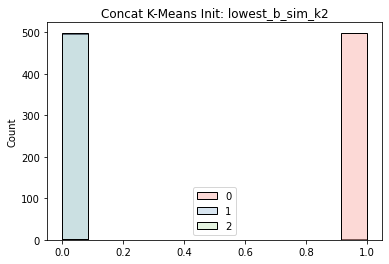

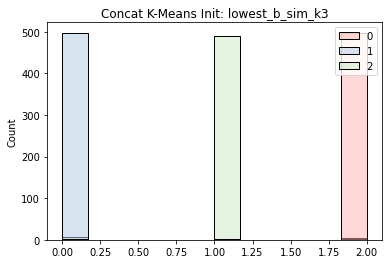

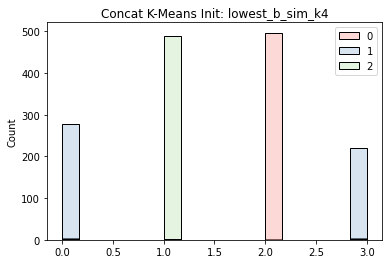

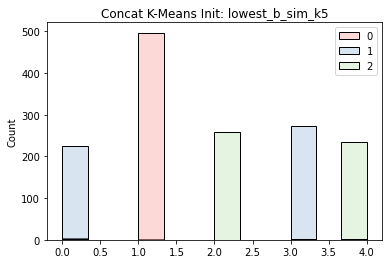

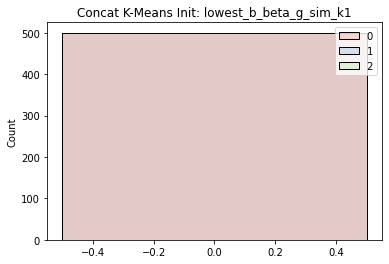

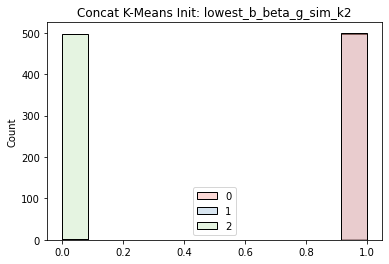

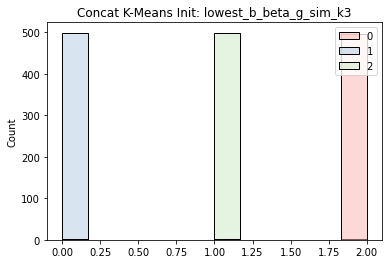

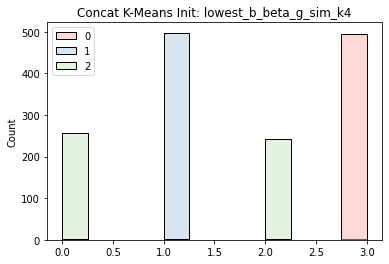

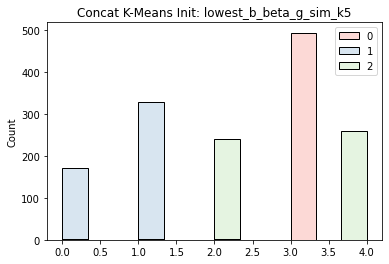

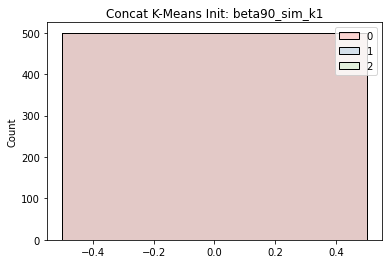

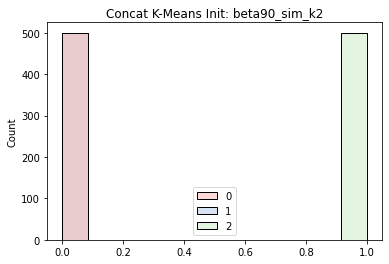

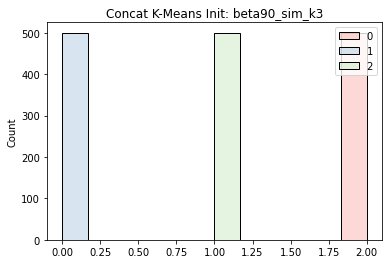

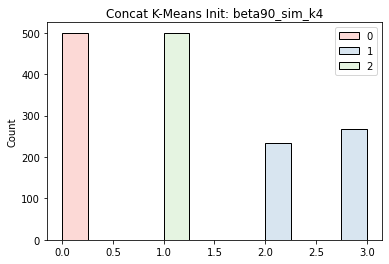

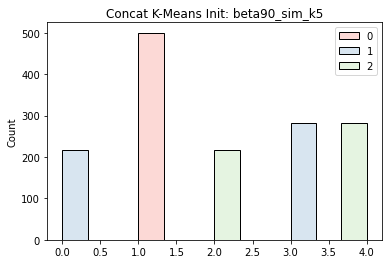

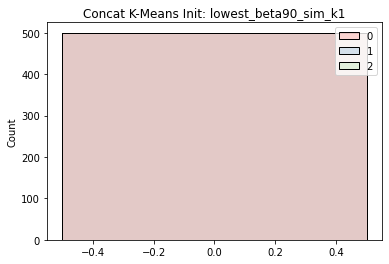

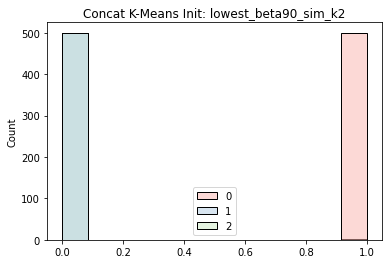

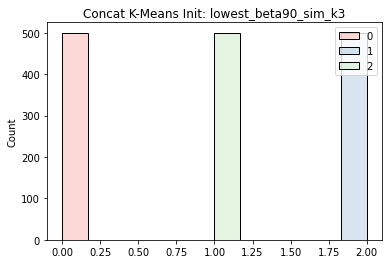

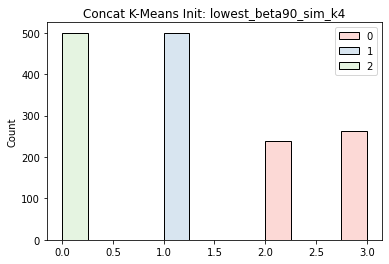

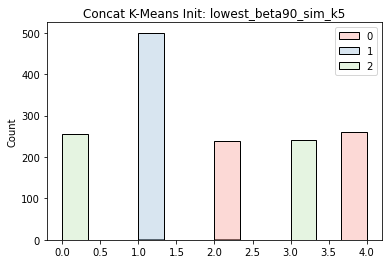

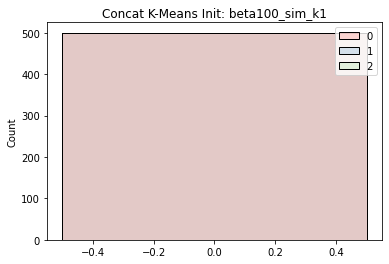

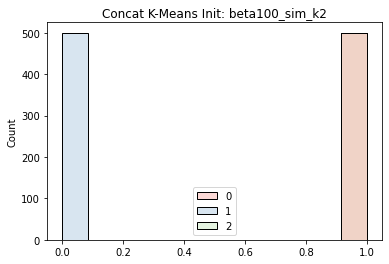

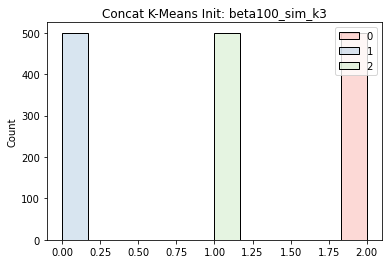

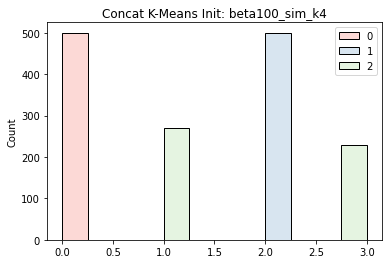

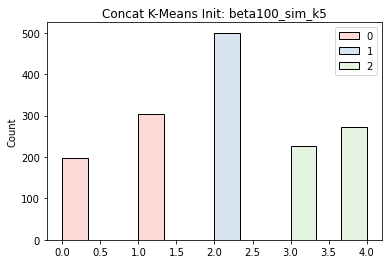

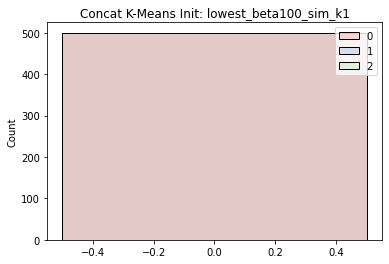

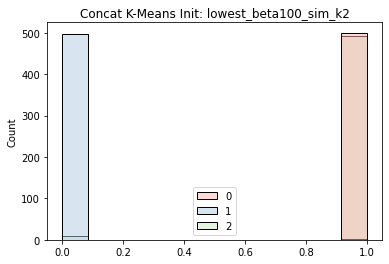

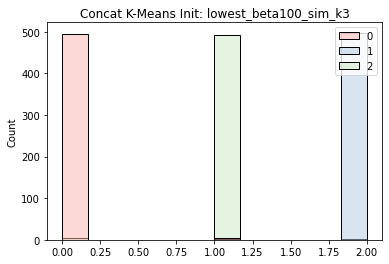

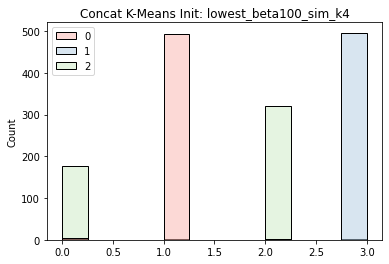

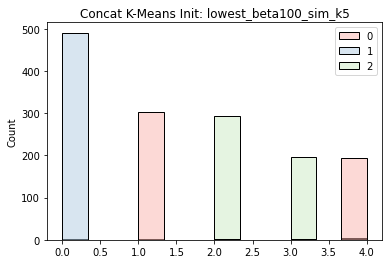

In [89]:
for i in range(len(ks)-3):
    which = i
    search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
                dataset_strings[which], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[which])
    
    U = search_data.layers[0,:,:]
    U_t = U.T
    S = search_data.layers[1,:,:]
    S_t = S.T
    
    concat = np.concatenate((U_t, S_t), axis=1)

    tots = np.sum(concat,axis=1)
    divids = (1e4/tots)[:,None]
    concat = concat*divids
    concat = np.log1p(concat)

    
    
    kmeans = KMeans(n_clusters=ks[i], random_state=0).fit(concat)
    labs = kmeans.labels_

    labels = labs
    plt.figure()
    sns.histplot(x=labels,hue=pd.Categorical([0]*500+[1]*500+[2]*500), kde=False,palette='Pastel1')
    plt.title('Concat K-Means Init: '+dataset_names[i])

    
    

RUN MIXTURE MODEL

In [70]:

result_strings = []
for i in range(len(ks)-3): #range(len(ks)-2): #n_datasets, running data with all clusters
    
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')
    
    inference_parameters = monod.mminference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,k=ks[i],epochs=epochs,use_lengths = True,
                gradient_params = {'max_iterations':20,'init_pattern':'moments','num_restarts':1})
    
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[i])
    
    inference_parameters.fit_all_grid_points(50,search_data)


INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/single_clus_test_k1/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230412_025_simTests_MM_1/single_clus_test_k1/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: single_clus_test_k1
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/single_clus_test_k1/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.75s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.75s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 2/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.99s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 3/20: 
INFO:root:Starting parallelized MLE param fits for EM.



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.73s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 4/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.75s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 5/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.73s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 6/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.83s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 7/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.76s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 8/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.75s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 9/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.76s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 10/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.76s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 11/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.75s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 12/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.76s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 13/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.75s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 14/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.91s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 15/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.74s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 16/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.77s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 17/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.78s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 18/20: 
INFO:root:Starting parallelized MLE param fits for EM.



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.74s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 19/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.77s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 20/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.76s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/single_clus_test_k2/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230412_025_simTests_MM_1/single_clus_test_k2/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: single_clus_test_k2
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.


INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/single_clus_test_k2/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.49s/it]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.41s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.54478347 0.45521653]
Q Function:  -140441.71661285288

INFO:root:EM Epoch 2/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.44s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.57694966 0.42305034]
Q Function:  -140228.30909208464

INFO:root:EM Epoch 3/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.51s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.48132346 0.51867654]
Q Function:  -137897.18355822004

INFO:root:EM Epoch 4/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.44s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.6480998 0.3519002]
Q Function:  -137544.60560914053

INFO:root:EM Epoch 5/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.45s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.68225206 0.31774794]
Q Function:  -136708.36518307103

INFO:root:EM Epoch 6/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.47s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.54318917 0.45681083]
Q Function:  -139430.92344477965

INFO:root:EM Epoch 7/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.53s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.68597979 0.31402021]
Q Function:  -137152.625718728

INFO:root:EM Epoch 8/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.43s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.55481197 0.44518803]
Q Function:  -139558.10774969572

INFO:root:EM Epoch 9/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.53s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.51949002 0.48050998]
Q Function:  -139121.27384619846

INFO:root:EM Epoch 10/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.49s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.28340345 0.71659655]
Q Function:  -138637.0326215215

INFO:root:EM Epoch 11/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.59s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.29367173 0.70632827]
Q Function:  -139552.39790803462

INFO:root:EM Epoch 12/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.54s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.2589609 0.7410391]
Q Function:  -136707.93494460123

INFO:root:EM Epoch 13/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.68s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.1445494 0.8554506]
Q Function:  -137092.01670924659

INFO:root:EM Epoch 14/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.46s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.0071812 0.9928188]
Q Function:  -140262.27418756703

INFO:root:EM Epoch 15/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.37s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [7.11621142e-04 9.99288379e-01]
Q Function:  -139964.5254853454

INFO:root:EM Epoch 16/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.39s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66667332e-04 9.99333333e-01]
Q Function:  -139943.80353345527

INFO:root:EM Epoch 17/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.38s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66667332e-04 9.99333333e-01]
Q Function:  -139943.8013557205

INFO:root:EM Epoch 18/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.37s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66667332e-04 9.99333333e-01]
Q Function:  -139943.8013557205

INFO:root:EM Epoch 19/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.37s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66667332e-04 9.99333333e-01]
Q Function:  -139943.8013557205

INFO:root:EM Epoch 20/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.54s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66667332e-04 9.99333333e-01]
Q Function:  -139943.8013557205

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/single_clus_test_k3/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230412_025_simTests_MM_1/single_clus_test_k3/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: single_clus_test_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/single_clus_test_k3/raw.sd.
INFO:root:Starting non-parallelized grid scan.


INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.00it/s]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.08s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.37268195 0.29535162 0.33196643]
Q Function:  -140775.73194401813

INFO:root:EM Epoch 2/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.55933192 0.20729269 0.2333754 ]
Q Function:  -137418.2888912612

INFO:root:EM Epoch 3/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.40314435 0.26252637 0.33432928]
Q Function:  -138743.4570575062

INFO:root:EM Epoch 4/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.02s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.48858564 0.27990766 0.2315067 ]
Q Function:  -137208.18191727335

INFO:root:EM Epoch 5/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.02s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3938453  0.21713075 0.38902395]
Q Function:  -139287.00094961186

INFO:root:EM Epoch 6/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.50811115 0.22879288 0.26309596]
Q Function:  -137261.21114953945

INFO:root:EM Epoch 7/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.39736794 0.17675918 0.42587288]
Q Function:  -139169.5241238781

INFO:root:EM Epoch 8/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.52509118 0.19142063 0.28348819]
Q Function:  -137301.5104027702

INFO:root:EM Epoch 9/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.40847286 0.13549614 0.456031  ]
Q Function:  -139053.03546097106

INFO:root:EM Epoch 10/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.54699883 0.15088489 0.30211627]
Q Function:  -137333.3681686922

INFO:root:EM Epoch 11/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.39261853 0.22261084 0.38477062]
Q Function:  -138173.75714606687

INFO:root:EM Epoch 12/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.48368338 0.17012524 0.34619138]
Q Function:  -137335.15636481612

INFO:root:EM Epoch 13/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.07s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.61551261 0.1617249  0.22276249]
Q Function:  -136976.7428243408

INFO:root:EM Epoch 14/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.01s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.44982733 0.24980455 0.30036813]
Q Function:  -138825.5828211563

INFO:root:EM Epoch 15/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.70532686 0.19394564 0.1007275 ]
Q Function:  -137844.325288143

INFO:root:EM Epoch 16/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.6097493  0.30710872 0.08314198]
Q Function:  -139371.07241847293

INFO:root:EM Epoch 17/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.47s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [7.83226794e-01 2.16705439e-01 6.77670260e-05]
Q Function:  -137137.25565032888

INFO:root:EM Epoch 18/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.49s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.53965064e-01 3.46034922e-01 1.41809927e-08]
Q Function:  -139364.80370477063

INFO:root:EM Epoch 19/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.46s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [7.71983304e-01 2.28016696e-01 6.69963386e-10]
Q Function:  -136887.49881263217

INFO:root:EM Epoch 20/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.57s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.60111117e-01 3.39888882e-01 6.66788086e-10]
Q Function:  -139486.82273285402

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/single_clus_test_k4/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230412_025_simTests_MM_1/single_clus_test_k4/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: single_clus_test_k4
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.


INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/single_clus_test_k4/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.26it/s]

INFO:root:Parallelized MLE fits complete.


INFO:root:EM Epoch 1/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.13it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.01546348 0.30888517 0.4052022  0.27044915]
Q Function:  -138886.67171416985

INFO:root:EM Epoch 2/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.02441813e-05 4.10350302e-01 2.44144944e-01 3.45464510e-01]
Q Function:  -138944.02245416195

INFO:root:EM Epoch 3/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.01it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [5.57365189e-08 3.09992949e-01 4.73789157e-01 2.16217838e-01]
Q Function:  -139376.09622165718

INFO:root:EM Epoch 4/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.01it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [7.56278583e-10 4.58248234e-01 3.00639434e-01 2.41112331e-01]
Q Function:  -138582.79921689891

INFO:root:EM Epoch 5/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.69502494e-10 3.60566676e-01 4.07912027e-01 2.31521296e-01]
Q Function:  -138131.2063309679

INFO:root:EM Epoch 6/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.68621779e-10 4.60605317e-01 3.24672720e-01 2.14721962e-01]
Q Function:  -138206.803300163

INFO:root:EM Epoch 7/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.16s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.68134773e-10 3.81770095e-01 4.46547351e-01 1.71682553e-01]
Q Function:  -137966.9929219562

INFO:root:EM Epoch 8/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.67828710e-10 6.07169300e-01 3.70689153e-01 2.21415462e-02]
Q Function:  -138997.46674720006

INFO:root:EM Epoch 9/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.01it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.69284721e-10 6.27955987e-01 3.69083565e-01 2.96044793e-03]
Q Function:  -136808.68750757916

INFO:root:EM Epoch 10/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.45s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.68630816e-10 7.20439971e-01 2.79560028e-01 6.69049532e-10]
Q Function:  -136845.91872769076

INFO:root:EM Epoch 11/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.65s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.68170511e-10 8.64639309e-01 1.35360689e-01 6.66666670e-10]
Q Function:  -140338.0446762077

INFO:root:EM Epoch 12/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.59s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.67861384e-10 9.15191984e-01 8.48080149e-02 6.66666665e-10]
Q Function:  -136740.40677546686

INFO:root:EM Epoch 13/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.75s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.67471063e-10 9.64866487e-01 3.51335117e-02 6.66666669e-10]
Q Function:  -139979.38220636724

INFO:root:EM Epoch 14/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.37s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.67341620e-10 9.98774256e-01 1.22574301e-03 6.66666669e-10]
Q Function:  -140027.1957869627

INFO:root:EM Epoch 15/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.37s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.67306586e-10 9.99333331e-01 6.66667328e-04 6.66666669e-10]
Q Function:  -139951.84596219863

INFO:root:EM Epoch 16/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.38s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.67306195e-10 9.99333331e-01 6.66667325e-04 6.66666669e-10]
Q Function:  -139951.61612539765

INFO:root:EM Epoch 17/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.38s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.67306195e-10 9.99333331e-01 6.66667325e-04 6.66666669e-10]
Q Function:  -139951.61612539768

INFO:root:EM Epoch 18/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.37s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.67306195e-10 9.99333331e-01 6.66667325e-04 6.66666669e-10]
Q Function:  -139951.61612539768

INFO:root:EM Epoch 19/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.37s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.67306195e-10 9.99333331e-01 6.66667325e-04 6.66666669e-10]
Q Function:  -139951.61612539768

INFO:root:EM Epoch 20/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.38s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.67306195e-10 9.99333331e-01 6.66667325e-04 6.66666669e-10]
Q Function:  -139951.61612539768

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/single_clus_test_k5/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230412_025_simTests_MM_1/single_clus_test_k5/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: single_clus_test_k5


INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/single_clus_test_k5/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.48it/s]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.22it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.25355499e-01 3.42058517e-04 3.90111351e-01 1.84103772e-01
 3.00087319e-01]
Q Function:  -138323.7225472418

INFO:root:EM Epoch 2/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.17it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.77038474e-01 8.27042242e-07 4.04119809e-01 1.71584488e-01
 2.47256402e-01]
Q Function:  -139468.77669003647

INFO:root:EM Epoch 3/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.21it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.26913849e-02 1.60731076e-09 5.80343879e-01 3.89893393e-03
 3.23065801e-01]
Q Function:  -137880.4560043476

INFO:root:EM Epoch 4/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [8.39117326e-02 6.77861848e-10 5.36900316e-01 6.66667457e-10
 3.79187950e-01]
Q Function:  -138148.712664753

INFO:root:EM Epoch 5/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.08s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.06547886e-02 6.67694063e-10 5.64871670e-01 6.66666664e-10
 4.24473540e-01]
Q Function:  -138467.31203064692

INFO:root:EM Epoch 6/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.02s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.67557307e-04 6.67112127e-10 7.36663409e-01 6.66666664e-10
 2.62369033e-01]
Q Function:  -138362.56246399303

INFO:root:EM Epoch 7/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.45s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [5.22613519e-08 6.91671722e-10 1.75730386e-01 6.66666664e-10
 8.24269560e-01]
Q Function:  -141192.77239630435

INFO:root:EM Epoch 8/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.56s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66783650e-10 6.68620985e-10 2.26131588e-01 6.66666664e-10
 7.73868410e-01]
Q Function:  -139632.57760757644

INFO:root:EM Epoch 9/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.67s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666722e-10 1.04456902e-09 1.61094880e-02 6.66666664e-10
 9.83890510e-01]
Q Function:  -137031.36675760505

INFO:root:EM Epoch 10/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.77s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66667492e-10 7.13659325e-06 8.39485149e-03 6.66666669e-10
 9.91598011e-01]
Q Function:  -140030.04294417694

INFO:root:EM Epoch 11/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.54s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66667344e-10 4.65913137e-03 1.15103865e-05 6.66666826e-10
 9.95329357e-01]
Q Function:  -140089.14160244697

INFO:root:EM Epoch 12/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.55s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66667364e-10 4.66619709e-03 4.98829833e-09 6.66698928e-10
 9.95333797e-01]
Q Function:  -140059.34820852213

INFO:root:EM Epoch 13/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.56s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66667364e-10 4.66619780e-03 6.68539544e-10 6.66698881e-10
 9.95333800e-01]
Q Function:  -140059.33085211227

INFO:root:EM Epoch 14/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.56s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66667364e-10 4.66619780e-03 6.66917671e-10 6.66698881e-10
 9.95333800e-01]
Q Function:  -140059.330845583

INFO:root:EM Epoch 15/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.74s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66667364e-10 4.66619780e-03 6.66917062e-10 6.66698881e-10
 9.95333800e-01]
Q Function:  -140059.33084558052

INFO:root:EM Epoch 16/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.57s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66667364e-10 4.66619780e-03 6.66917062e-10 6.66698881e-10
 9.95333800e-01]
Q Function:  -140059.33084558052

INFO:root:EM Epoch 17/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.57s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66667364e-10 4.66619780e-03 6.66917062e-10 6.66698881e-10
 9.95333800e-01]
Q Function:  -140059.33084558052

INFO:root:EM Epoch 18/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.58s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66667364e-10 4.66619780e-03 6.66917062e-10 6.66698881e-10
 9.95333800e-01]
Q Function:  -140059.33084558052

INFO:root:EM Epoch 19/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.75s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66667364e-10 4.66619780e-03 6.66917062e-10 6.66698881e-10
 9.95333800e-01]
Q Function:  -140059.33084558052

INFO:root:EM Epoch 20/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.56s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66667364e-10 4.66619780e-03 6.66917062e-10 6.66698881e-10
 9.95333800e-01]
Q Function:  -140059.33084558052

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/lowest_b_sim_k1/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230412_025_simTests_MM_1/lowest_b_sim_k1/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_b_sim_k1
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.


INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/lowest_b_sim_k1/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.80s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.77s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -176021.99735242117

INFO:root:EM Epoch 2/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.77s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -176021.99735242117

INFO:root:EM Epoch 3/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.84s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -176021.99735242117

INFO:root:EM Epoch 4/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.77s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -176021.99735242117

INFO:root:EM Epoch 5/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.10s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -176021.99735242117

INFO:root:EM Epoch 6/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.12s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -176021.99735242117

INFO:root:EM Epoch 7/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.79s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -176021.99735242117

INFO:root:EM Epoch 8/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.79s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -176021.99735242117

INFO:root:EM Epoch 9/20: 
INFO:root:Starting parallelized MLE param fits for EM.



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.78s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -176021.99735242117

INFO:root:EM Epoch 10/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.76s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -176021.99735242117

INFO:root:EM Epoch 11/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.76s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -176021.99735242117

INFO:root:EM Epoch 12/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.77s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -176021.99735242117

INFO:root:EM Epoch 13/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.73s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -176021.99735242117

INFO:root:EM Epoch 14/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.75s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -176021.99735242117

INFO:root:EM Epoch 15/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.73s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -176021.99735242117

INFO:root:EM Epoch 16/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.75s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -176021.99735242117

INFO:root:EM Epoch 17/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.76s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -176021.99735242117

INFO:root:EM Epoch 18/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.79s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -176021.99735242117

INFO:root:EM Epoch 19/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.76s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -176021.99735242117

INFO:root:EM Epoch 20/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.74s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -176021.99735242117

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/lowest_b_sim_k2/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230412_025_simTests_MM_1/lowest_b_sim_k2/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_b_sim_k2
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.


INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/lowest_b_sim_k2/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.53s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.54s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.61976419 0.38023581]
Q Function:  -171060.2240888772

INFO:root:EM Epoch 2/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.49s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66491254 0.33508746]
Q Function:  -169777.14801244874

INFO:root:EM Epoch 3/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.50s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.65836464 0.34163536]
Q Function:  -170479.1813436476

INFO:root:EM Epoch 4/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.50s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66558809 0.33441191]
Q Function:  -171477.48692359615

INFO:root:EM Epoch 5/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.55s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.65914604 0.34085396]
Q Function:  -170468.12750818557

INFO:root:EM Epoch 6/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.51s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66559112 0.33440888]
Q Function:  -171477.44588147083

INFO:root:EM Epoch 7/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.50s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.65914606 0.34085394]
Q Function:  -170468.12761694874

INFO:root:EM Epoch 8/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.53s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66559112 0.33440888]
Q Function:  -171477.4458804785

INFO:root:EM Epoch 9/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.49s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.65914606 0.34085394]
Q Function:  -170468.12761695147

INFO:root:EM Epoch 10/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.51s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66559112 0.33440888]
Q Function:  -171477.44588047848

INFO:root:EM Epoch 11/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.51s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.65914606 0.34085394]
Q Function:  -170468.12761695147

INFO:root:EM Epoch 12/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.50s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66559112 0.33440888]
Q Function:  -171477.44588047848

INFO:root:EM Epoch 13/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.56s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.65914606 0.34085394]
Q Function:  -170468.12761695147

INFO:root:EM Epoch 14/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.49s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66559112 0.33440888]
Q Function:  -171477.44588047848

INFO:root:EM Epoch 15/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.50s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.65914606 0.34085394]
Q Function:  -170468.12761695147

INFO:root:EM Epoch 16/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.49s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66559112 0.33440888]
Q Function:  -171477.44588047848

INFO:root:EM Epoch 17/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.49s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.65914606 0.34085394]
Q Function:  -170468.12761695147

INFO:root:EM Epoch 18/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.50s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66559112 0.33440888]
Q Function:  -171477.44588047848

INFO:root:EM Epoch 19/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.49s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.65914606 0.34085394]
Q Function:  -170468.12761695147

INFO:root:EM Epoch 20/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.50s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66559112 0.33440888]
Q Function:  -171477.44588047848

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/lowest_b_sim_k3/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230412_025_simTests_MM_1/lowest_b_sim_k3/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_b_sim_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/lowest_b_sim_k3/raw.sd.
INFO:root:Starting non-parallelized grid scan.


INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.01s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.30047189 0.31530372 0.38422439]
Q Function:  -169554.99769144034

INFO:root:EM Epoch 2/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33284784 0.3341239  0.33302827]
Q Function:  -166806.72595322225

INFO:root:EM Epoch 3/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.07s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33457529 0.34481923 0.32060548]
Q Function:  -170480.55291358376

INFO:root:EM Epoch 4/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33566155 0.33449672 0.32984173]
Q Function:  -170595.51990643976

INFO:root:EM Epoch 5/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33098683 0.33967671 0.32933645]
Q Function:  -168209.37285699643

INFO:root:EM Epoch 6/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33553301 0.33789266 0.32657433]
Q Function:  -171500.3419057026

INFO:root:EM Epoch 7/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33582341 0.34305178 0.32112481]
Q Function:  -168435.84904492454

INFO:root:EM Epoch 8/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33823841 0.33581215 0.32594944]
Q Function:  -170565.6342570777

INFO:root:EM Epoch 9/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.07s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33030595 0.33992836 0.32976568]
Q Function:  -167561.5024488174

INFO:root:EM Epoch 10/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33552014 0.33789424 0.32658562]
Q Function:  -171500.3604951386

INFO:root:EM Epoch 11/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33582325 0.34305179 0.32112496]
Q Function:  -168435.84931499418

INFO:root:EM Epoch 12/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33823841 0.33581215 0.32594944]
Q Function:  -170565.63425467606

INFO:root:EM Epoch 13/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.17s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33030595 0.33992836 0.32976568]
Q Function:  -167561.50244862708

INFO:root:EM Epoch 14/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33552014 0.33789424 0.32658562]
Q Function:  -171500.36049513897

INFO:root:EM Epoch 15/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.07s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33582325 0.34305179 0.32112496]
Q Function:  -168435.8493149942

INFO:root:EM Epoch 16/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33823841 0.33581215 0.32594944]
Q Function:  -170565.63425467606

INFO:root:EM Epoch 17/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.08s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33030595 0.33992836 0.32976568]
Q Function:  -167561.50244862708

INFO:root:EM Epoch 18/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33552014 0.33789424 0.32658562]
Q Function:  -171500.36049513897

INFO:root:EM Epoch 19/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33582325 0.34305179 0.32112496]
Q Function:  -168435.8493149942

INFO:root:EM Epoch 20/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33823841 0.33581215 0.32594944]
Q Function:  -170565.63425467606

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/lowest_b_sim_k4/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230412_025_simTests_MM_1/lowest_b_sim_k4/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_b_sim_k4
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/lowest_b_sim_k4/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.25it/s]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.08817407 0.30789692 0.23173048 0.37219853]
Q Function:  -170684.03159476077

INFO:root:EM Epoch 2/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.18it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.13575305 0.33487265 0.18686178 0.34251253]
Q Function:  -169259.37007270323

INFO:root:EM Epoch 3/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.23it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.14249883 0.32998754 0.18877593 0.3387377 ]
Q Function:  -167977.34771738952

INFO:root:EM Epoch 4/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.15it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.24730876 0.33609896 0.07996981 0.33662247]
Q Function:  -171048.18875980764

INFO:root:EM Epoch 5/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.21it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.10779601 0.32891844 0.22724133 0.33604421]
Q Function:  -168226.11773913697

INFO:root:EM Epoch 6/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.18it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.06395782 0.33776555 0.25838602 0.3398906 ]
Q Function:  -170824.15601806837

INFO:root:EM Epoch 7/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.15it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.01938821 0.33189757 0.30964171 0.3390725 ]
Q Function:  -167867.58708571512

INFO:root:EM Epoch 8/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.06it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.01388503 0.34047823 0.3087312  0.33690553]
Q Function:  -171589.9053478864

INFO:root:EM Epoch 9/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.00829208 0.33287983 0.31908121 0.33974688]
Q Function:  -167792.67645768786

INFO:root:EM Epoch 10/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.20it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.00445621 0.3374019  0.32158823 0.33655366]
Q Function:  -170803.12741514185

INFO:root:EM Epoch 11/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.26it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.00108887 0.33654408 0.3233072  0.33905985]
Q Function:  -168026.56873517745

INFO:root:EM Epoch 12/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666665e-10 3.42344814e-01 3.21154511e-01 3.36500674e-01]
Q Function:  -171551.2892238066

INFO:root:EM Epoch 13/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666665e-10 3.35287446e-01 3.25446026e-01 3.39266527e-01]
Q Function:  -169106.24661723356

INFO:root:EM Epoch 14/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666665e-10 3.45655992e-01 3.18963190e-01 3.35380817e-01]
Q Function:  -171464.5929108588

INFO:root:EM Epoch 15/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666665e-10 3.31000487e-01 3.29577862e-01 3.39421651e-01]
Q Function:  -167666.2197262908

INFO:root:EM Epoch 16/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666665e-10 3.38093619e-01 3.24454385e-01 3.37451996e-01]
Q Function:  -171506.02671994723

INFO:root:EM Epoch 17/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666665e-10 3.30440211e-01 3.30054821e-01 3.39504967e-01]
Q Function:  -167606.5608715515

INFO:root:EM Epoch 18/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666665e-10 3.35605879e-01 3.26560559e-01 3.37833561e-01]
Q Function:  -171498.52557842308

INFO:root:EM Epoch 19/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666665e-10 3.35831770e-01 3.21114286e-01 3.43053943e-01]
Q Function:  -168435.37522310606

INFO:root:EM Epoch 20/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666665e-10 3.38238651e-01 3.25949166e-01 3.35812182e-01]
Q Function:  -170565.63488293646

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/lowest_b_sim_k5/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230412_025_simTests_MM_1/lowest_b_sim_k5/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_b_sim_k5
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/lowest_b_sim_k5/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.48it/s]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.39it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.11966385 0.19761058 0.32445166 0.13340136 0.22487255]
Q Function:  -169424.71713307322

INFO:root:EM Epoch 2/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.35it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.15549903 0.11907061 0.33635979 0.21308063 0.17598994]
Q Function:  -168276.42596929614

INFO:root:EM Epoch 3/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.45it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.09431528 0.30335082 0.33717579 0.02355376 0.24160436]
Q Function:  -168504.43441279995

INFO:root:EM Epoch 4/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.21it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.09864488 0.32006104 0.33713721 0.00039843 0.24375845]
Q Function:  -171379.51908745815

INFO:root:EM Epoch 5/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.23it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.28181818e-02 3.05995697e-01 3.36053580e-01 8.43883596e-06
 3.45124102e-01]
Q Function:  -169808.09095176478

INFO:root:EM Epoch 6/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.23it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [5.71184231e-04 3.07541989e-01 3.36437150e-01 3.74727626e-09
 3.55449673e-01]
Q Function:  -169650.88215438454

INFO:root:EM Epoch 7/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.02s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666664e-10 3.28643479e-01 3.39087369e-01 6.71471378e-10
 3.32269151e-01]
Q Function:  -167747.51466105157

INFO:root:EM Epoch 8/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.02s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666664e-10 3.24396500e-01 3.37001565e-01 6.81413438e-10
 3.38601934e-01]
Q Function:  -171468.78171027265

INFO:root:EM Epoch 9/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666664e-10 3.26700693e-01 3.39218956e-01 6.67049544e-10
 3.34080350e-01]
Q Function:  -169104.7488070703

INFO:root:EM Epoch 10/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666664e-10 3.20987981e-01 3.35602501e-01 6.69316726e-10
 3.43409517e-01]
Q Function:  -171469.6263881576

INFO:root:EM Epoch 11/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666664e-10 3.19106266e-01 3.42828188e-01 1.14684463e-07
 3.38065431e-01]
Q Function:  -168495.6480505502

INFO:root:EM Epoch 12/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666664e-10 3.24716407e-01 3.35581327e-01 7.24373789e-10
 3.39702265e-01]
Q Function:  -170561.03645163053

INFO:root:EM Epoch 13/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666664e-10 3.29672169e-01 3.39854062e-01 6.67142477e-10
 3.30473767e-01]
Q Function:  -167665.74915528725

INFO:root:EM Epoch 14/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666664e-10 3.26581466e-01 3.37894010e-01 6.69643761e-10
 3.35524523e-01]
Q Function:  -171500.3616637815

INFO:root:EM Epoch 15/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666664e-10 3.21114135e-01 3.43054602e-01 1.32238796e-07
 3.35831131e-01]
Q Function:  -168435.37590096926

INFO:root:EM Epoch 16/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666664e-10 3.25946675e-01 3.35812848e-01 7.25542589e-10
 3.38240475e-01]
Q Function:  -170565.62896173497

INFO:root:EM Epoch 17/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666664e-10 3.29765559e-01 3.39928587e-01 6.67141944e-10
 3.30305853e-01]
Q Function:  -167561.49956605185

INFO:root:EM Epoch 18/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666664e-10 3.26584006e-01 3.37894562e-01 6.69642973e-10
 3.35521431e-01]
Q Function:  -171500.36682552268

INFO:root:EM Epoch 19/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666664e-10 3.21114167e-01 3.43054606e-01 1.32237619e-07
 3.35831093e-01]
Q Function:  -168435.37595844077

INFO:root:EM Epoch 20/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666664e-10 3.25946676e-01 3.35812848e-01 7.25542059e-10
 3.38240474e-01]
Q Function:  -170565.62896127696

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/lowest_b_beta_g_sim_k1/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230412_025_simTests_MM_1/lowest_b_beta_g_sim_k1/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_b_beta_g_sim_k1
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.


INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/lowest_b_beta_g_sim_k1/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -179755.57695665077

INFO:root:EM Epoch 2/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -179755.57695665077

INFO:root:EM Epoch 3/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -179755.57695665077

INFO:root:EM Epoch 4/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.35s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -179755.57695665077

INFO:root:EM Epoch 5/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.31s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -179755.57695665077

INFO:root:EM Epoch 6/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.35s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -179755.57695665077

INFO:root:EM Epoch 7/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.30s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -179755.57695665077

INFO:root:EM Epoch 8/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.30s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -179755.57695665077

INFO:root:EM Epoch 9/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.29s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -179755.57695665077

INFO:root:EM Epoch 10/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.32s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -179755.57695665077

INFO:root:EM Epoch 11/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.33s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -179755.57695665077

INFO:root:EM Epoch 12/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.37s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -179755.57695665077

INFO:root:EM Epoch 13/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.36s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -179755.57695665077

INFO:root:EM Epoch 14/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.36s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -179755.57695665077

INFO:root:EM Epoch 15/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.36s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -179755.57695665077

INFO:root:EM Epoch 16/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.31s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -179755.57695665077

INFO:root:EM Epoch 17/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.32s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -179755.57695665077

INFO:root:EM Epoch 18/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.31s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -179755.57695665077

INFO:root:EM Epoch 19/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.32s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -179755.57695665077

INFO:root:EM Epoch 20/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.35s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -179755.57695665077

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/lowest_b_beta_g_sim_k2/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230412_025_simTests_MM_1/lowest_b_beta_g_sim_k2/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_b_beta_g_sim_k2
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.


INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/lowest_b_beta_g_sim_k2/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.75s/it]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.64s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.36694843 0.63305157]
Q Function:  -175192.6539142842

INFO:root:EM Epoch 2/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.62s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33337288 0.66662712]
Q Function:  -172742.70390375372

INFO:root:EM Epoch 3/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.59s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33492886 0.66507114]
Q Function:  -175650.68970316608

INFO:root:EM Epoch 4/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.61s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33350999 0.66649001]
Q Function:  -174658.11384980637

INFO:root:EM Epoch 5/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.59s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33195609 0.66804391]
Q Function:  -172474.40915229754

INFO:root:EM Epoch 6/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.64s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33743959 0.66256041]
Q Function:  -174439.91423607792

INFO:root:EM Epoch 7/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.61s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33351564 0.66648436]
Q Function:  -174675.02214614677

INFO:root:EM Epoch 8/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.60s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3319561 0.6680439]
Q Function:  -172474.4092048968

INFO:root:EM Epoch 9/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.66s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33743959 0.66256041]
Q Function:  -174439.91423600249

INFO:root:EM Epoch 10/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.61s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33351564 0.66648436]
Q Function:  -174675.02214614704

INFO:root:EM Epoch 11/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.58s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3319561 0.6680439]
Q Function:  -172474.4092048968

INFO:root:EM Epoch 12/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.66s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33743959 0.66256041]
Q Function:  -174439.91423600249

INFO:root:EM Epoch 13/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.66s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33351564 0.66648436]
Q Function:  -174675.02214614704

INFO:root:EM Epoch 14/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.59s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3319561 0.6680439]
Q Function:  -172474.4092048968

INFO:root:EM Epoch 15/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.66s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33743959 0.66256041]
Q Function:  -174439.91423600249

INFO:root:EM Epoch 16/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.62s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33351564 0.66648436]
Q Function:  -174675.02214614704

INFO:root:EM Epoch 17/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.60s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3319561 0.6680439]
Q Function:  -172474.4092048968

INFO:root:EM Epoch 18/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.63s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33743959 0.66256041]
Q Function:  -174439.91423600249

INFO:root:EM Epoch 19/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.62s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33351564 0.66648436]
Q Function:  -174675.02214614704

INFO:root:EM Epoch 20/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.59s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3319561 0.6680439]
Q Function:  -172474.4092048968

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/lowest_b_beta_g_sim_k3/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230412_025_simTests_MM_1/lowest_b_beta_g_sim_k3/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_b_beta_g_sim_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/lowest_b_beta_g_sim_k3/raw.sd.
INFO:root:Starting non-parallelized grid scan.


INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32155883 0.35632024 0.32212093]
Q Function:  -171737.11707102042

INFO:root:EM Epoch 2/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.08s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3358524  0.33437484 0.32977276]
Q Function:  -170397.48964691977

INFO:root:EM Epoch 3/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.09s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33246484 0.33658479 0.33095036]
Q Function:  -171106.110895615

INFO:root:EM Epoch 4/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.09s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33739849 0.3334251  0.32917642]
Q Function:  -170265.14416985225

INFO:root:EM Epoch 5/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3326595  0.33696391 0.33037659]
Q Function:  -171354.88315559417

INFO:root:EM Epoch 6/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.08s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33733107 0.33402584 0.32864309]
Q Function:  -169849.65834152463

INFO:root:EM Epoch 7/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.10s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33866113 0.333766   0.32757288]
Q Function:  -170091.31109576504

INFO:root:EM Epoch 8/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.09s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33350202 0.33653296 0.32996502]
Q Function:  -171118.99665249267

INFO:root:EM Epoch 9/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33799481 0.3333036  0.32870159]
Q Function:  -170342.67551097635

INFO:root:EM Epoch 10/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33303503 0.33670516 0.33025981]
Q Function:  -171424.9467185634

INFO:root:EM Epoch 11/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.10s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33133431 0.33975347 0.32891222]
Q Function:  -170083.0052910289

INFO:root:EM Epoch 12/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.09s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33107205 0.34025901 0.32866894]
Q Function:  -170174.4891213944

INFO:root:EM Epoch 13/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33106988 0.34026234 0.32866778]
Q Function:  -170174.49145329045

INFO:root:EM Epoch 14/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.10s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33106986 0.34026237 0.32866777]
Q Function:  -170174.49147561583

INFO:root:EM Epoch 15/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.09s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33106986 0.34026237 0.32866777]
Q Function:  -170174.49147577194

INFO:root:EM Epoch 16/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.09s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33106986 0.34026237 0.32866777]
Q Function:  -170174.49147577304

INFO:root:EM Epoch 17/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.09s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33106986 0.34026237 0.32866777]
Q Function:  -170174.49147577301

INFO:root:EM Epoch 18/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33106986 0.34026237 0.32866777]
Q Function:  -170174.49147577304

INFO:root:EM Epoch 19/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.09s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33106986 0.34026237 0.32866777]
Q Function:  -170174.49147577304

INFO:root:EM Epoch 20/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.10s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33106986 0.34026237 0.32866777]
Q Function:  -170174.49147577304

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/lowest_b_beta_g_sim_k4/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230412_025_simTests_MM_1/lowest_b_beta_g_sim_k4/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_b_beta_g_sim_k4
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/lowest_b_beta_g_sim_k4/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.02it/s]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3223675  0.30980064 0.07473954 0.29309232]
Q Function:  -174203.37878050888

INFO:root:EM Epoch 2/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.19it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33352718 0.33119241 0.01597295 0.31930746]
Q Function:  -169254.19112658

INFO:root:EM Epoch 3/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.32702096e-01 3.32461155e-01 1.80650257e-09 3.34836748e-01]
Q Function:  -169325.88220447797

INFO:root:EM Epoch 4/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.07s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.35011373e-01 3.28914409e-01 6.66666788e-10 3.36074217e-01]
Q Function:  -169154.12379212465

INFO:root:EM Epoch 5/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.10s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.36582919e-01 3.30919314e-01 6.66666801e-10 3.32497766e-01]
Q Function:  -171078.2871118529

INFO:root:EM Epoch 6/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.08s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33425072e-01 3.29176178e-01 6.66666704e-10 3.37398750e-01]
Q Function:  -170265.14340843336

INFO:root:EM Epoch 7/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.15s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.36963881e-01 3.30376657e-01 6.66666737e-10 3.32659462e-01]
Q Function:  -171354.8831340853

INFO:root:EM Epoch 8/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.09s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.34025843e-01 3.28643087e-01 6.66666699e-10 3.37331069e-01]
Q Function:  -169849.65834825585

INFO:root:EM Epoch 9/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33766004e-01 3.27572830e-01 6.66666694e-10 3.38661166e-01]
Q Function:  -170091.31100682972

INFO:root:EM Epoch 10/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.10s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.36532933e-01 3.29965080e-01 6.66666832e-10 3.33501987e-01]
Q Function:  -171118.99652514275

INFO:root:EM Epoch 11/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.16s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33303604e-01 3.28701667e-01 6.66666698e-10 3.37994728e-01]
Q Function:  -170342.67566683821

INFO:root:EM Epoch 12/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.09s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.36705168e-01 3.30259780e-01 6.66666840e-10 3.33035051e-01]
Q Function:  -171424.94681935484

INFO:root:EM Epoch 13/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.17s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.39753467e-01 3.28912223e-01 6.66666736e-10 3.31334309e-01]
Q Function:  -170083.00529287214

INFO:root:EM Epoch 14/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.40258921e-01 3.28669068e-01 6.66666873e-10 3.31072010e-01]
Q Function:  -170174.48941795985

INFO:root:EM Epoch 15/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.40262259e-01 3.28667907e-01 6.66666873e-10 3.31069833e-01]
Q Function:  -170174.49174972766

INFO:root:EM Epoch 16/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.10s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.40262282e-01 3.28667901e-01 6.66666873e-10 3.31069817e-01]
Q Function:  -170174.4917720502

INFO:root:EM Epoch 17/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.10s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.40262282e-01 3.28667901e-01 6.66666873e-10 3.31069817e-01]
Q Function:  -170174.4917722063

INFO:root:EM Epoch 18/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.40262282e-01 3.28667901e-01 6.66666873e-10 3.31069817e-01]
Q Function:  -170174.49177220737

INFO:root:EM Epoch 19/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.40262282e-01 3.28667901e-01 6.66666873e-10 3.31069817e-01]
Q Function:  -170174.4917722074

INFO:root:EM Epoch 20/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.10s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.40262282e-01 3.28667901e-01 6.66666873e-10 3.31069817e-01]
Q Function:  -170174.4917722074

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/lowest_b_beta_g_sim_k5/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230412_025_simTests_MM_1/lowest_b_beta_g_sim_k5/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_b_beta_g_sim_k5
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/lowest_b_beta_g_sim_k5/raw.sd.
INFO:root:Starting non-parallelized grid scan.


INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.36it/s]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.40it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.21349267 0.20600485 0.30343797 0.1053896  0.17167492]
Q Function:  -173523.41409452283

INFO:root:EM Epoch 2/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.42it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.26439102 0.07085903 0.33278768 0.06815609 0.26380617]
Q Function:  -169695.5586357603

INFO:root:EM Epoch 3/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.41it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.30502538 0.28406983 0.32559211 0.02787725 0.05743543]
Q Function:  -173680.6824820297

INFO:root:EM Epoch 4/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.40it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32801253 0.08639522 0.32644681 0.00881807 0.25032738]
Q Function:  -177039.6425935108

INFO:root:EM Epoch 5/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.44it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33437988 0.2475067  0.32630827 0.00045083 0.09135432]
Q Function:  -174180.46093136905

INFO:root:EM Epoch 6/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.35152241e-01 1.41765948e-01 3.27340898e-01 6.66666664e-10
 1.95740913e-01]
Q Function:  -178243.77043423502

INFO:root:EM Epoch 7/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.31452018e-01 3.08850859e-01 3.24833136e-01 6.66666664e-10
 3.48639852e-02]
Q Function:  -174100.7852322391

INFO:root:EM Epoch 8/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.16it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.54518197e-01 1.83262622e-01 3.23698034e-01 6.66666664e-10
 1.38521147e-01]
Q Function:  -178555.36089275056

INFO:root:EM Epoch 9/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.15it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.34633742e-01 3.39920722e-01 3.24200046e-01 6.66666664e-10
 1.24549025e-03]
Q Function:  -171945.8010847123

INFO:root:EM Epoch 10/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.32343580e-01 3.39836420e-01 3.27819999e-01 6.66666664e-10
 6.66666664e-10]
Q Function:  -170166.39157910255

INFO:root:EM Epoch 11/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.36339932e-01 3.38795989e-01 3.24864078e-01 6.66666664e-10
 6.66666664e-10]
Q Function:  -170367.47352068528

INFO:root:EM Epoch 12/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33004137e-01 3.41280793e-01 3.25715069e-01 6.66666664e-10
 6.66666664e-10]
Q Function:  -171352.72754274606

INFO:root:EM Epoch 13/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.31447871e-01 3.40483925e-01 3.28068202e-01 6.66666664e-10
 6.66666664e-10]
Q Function:  -170188.92001132522

INFO:root:EM Epoch 14/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.30843820e-01 3.39188939e-01 3.29967240e-01 6.66666664e-10
 6.66666664e-10]
Q Function:  -170544.68764158856

INFO:root:EM Epoch 15/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.32033785e-01 3.41504361e-01 3.26461852e-01 6.66666664e-10
 6.66666664e-10]
Q Function:  -171341.94959191067

INFO:root:EM Epoch 16/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.31443324e-01 3.40485888e-01 3.28070787e-01 6.66666664e-10
 6.66666664e-10]
Q Function:  -170188.9120251225

INFO:root:EM Epoch 17/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.30843802e-01 3.39188950e-01 3.29967246e-01 6.66666664e-10
 6.66666664e-10]
Q Function:  -170544.68762281584

INFO:root:EM Epoch 18/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.32033785e-01 3.41504361e-01 3.26461852e-01 6.66666664e-10
 6.66666664e-10]
Q Function:  -171341.94959206204

INFO:root:EM Epoch 19/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.31443324e-01 3.40485888e-01 3.28070787e-01 6.66666664e-10
 6.66666664e-10]
Q Function:  -170188.912025123

INFO:root:EM Epoch 20/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.30843802e-01 3.39188950e-01 3.29967246e-01 6.66666664e-10
 6.66666664e-10]
Q Function:  -170544.68762281587

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/beta90_sim_k1/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230412_025_simTests_MM_1/beta90_sim_k1/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta90_sim_k1
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/beta90_sim_k1/raw.sd.
INFO:root:Starting non-parallelized grid scan.


INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.80s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 
INFO:root:Starting parallelized MLE param fits for EM.



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.79s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -187401.28414029715

INFO:root:EM Epoch 2/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.82s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -187401.28414029715

INFO:root:EM Epoch 3/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.79s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -187401.28414029715

INFO:root:EM Epoch 4/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.82s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -187401.28414029715

INFO:root:EM Epoch 5/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.78s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -187401.28414029715

INFO:root:EM Epoch 6/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.78s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -187401.28414029715

INFO:root:EM Epoch 7/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.79s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -187401.28414029715

INFO:root:EM Epoch 8/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.78s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -187401.28414029715

INFO:root:EM Epoch 9/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.82s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -187401.28414029715

INFO:root:EM Epoch 10/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.79s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -187401.28414029715

INFO:root:EM Epoch 11/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.82s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -187401.28414029715

INFO:root:EM Epoch 12/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.82s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -187401.28414029715

INFO:root:EM Epoch 13/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.82s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -187401.28414029715

INFO:root:EM Epoch 14/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.82s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -187401.28414029715

INFO:root:EM Epoch 15/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.82s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -187401.28414029715

INFO:root:EM Epoch 16/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.81s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -187401.28414029715

INFO:root:EM Epoch 17/20: 
INFO:root:Starting parallelized MLE param fits for EM.



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.80s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -187401.28414029715

INFO:root:EM Epoch 18/20: 
INFO:root:Starting parallelized MLE param fits for EM.



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.81s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -187401.28414029715

INFO:root:EM Epoch 19/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.81s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -187401.28414029715

INFO:root:EM Epoch 20/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.80s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -187401.28414029715

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/beta90_sim_k2/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230412_025_simTests_MM_1/beta90_sim_k2/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta90_sim_k2
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/beta90_sim_k2/raw.sd.
INFO:root:Starting non-parallelized grid scan.


INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.48s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.54s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.64321389 0.35678611]
Q Function:  -182303.8885003575

INFO:root:EM Epoch 2/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.48s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66660544 0.33339456]
Q Function:  -179912.84661672462

INFO:root:EM Epoch 3/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.48s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -179665.57949271577

INFO:root:EM Epoch 4/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.49s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -179665.579480065

INFO:root:EM Epoch 5/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.51s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -179665.579480065

INFO:root:EM Epoch 6/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.49s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -179665.579480065

INFO:root:EM Epoch 7/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.49s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -179665.579480065

INFO:root:EM Epoch 8/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.49s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -179665.579480065

INFO:root:EM Epoch 9/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.50s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -179665.579480065

INFO:root:EM Epoch 10/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.51s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -179665.579480065

INFO:root:EM Epoch 11/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.48s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -179665.579480065

INFO:root:EM Epoch 12/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.48s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -179665.579480065

INFO:root:EM Epoch 13/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.49s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -179665.579480065

INFO:root:EM Epoch 14/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.49s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -179665.579480065

INFO:root:EM Epoch 15/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.48s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -179665.579480065

INFO:root:EM Epoch 16/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.49s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -179665.579480065

INFO:root:EM Epoch 17/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.63s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -179665.579480065

INFO:root:EM Epoch 18/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.49s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -179665.579480065

INFO:root:EM Epoch 19/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.49s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -179665.579480065

INFO:root:EM Epoch 20/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.48s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -179665.579480065

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/beta90_sim_k3/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230412_025_simTests_MM_1/beta90_sim_k3/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta90_sim_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.


INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/beta90_sim_k3/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.10s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.1879457  0.33835886 0.47369545]
Q Function:  -181523.6340546661

INFO:root:EM Epoch 2/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.25556557 0.33333333 0.4111011 ]
Q Function:  -178165.94850640456

INFO:root:EM Epoch 3/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32444316 0.33333333 0.3422235 ]
Q Function:  -173332.5012220293

INFO:root:EM Epoch 4/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333333 0.33333333 0.33333333]
Q Function:  -168529.09017154409

INFO:root:EM Epoch 5/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.02s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333333 0.33333333 0.33333333]
Q Function:  -168367.4733424877

INFO:root:EM Epoch 6/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333333 0.33333333 0.33333333]
Q Function:  -168367.4733424877

INFO:root:EM Epoch 7/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333333 0.33333333 0.33333333]
Q Function:  -168367.4733424877

INFO:root:EM Epoch 8/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333333 0.33333333 0.33333333]
Q Function:  -168367.4733424877

INFO:root:EM Epoch 9/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.07s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333333 0.33333333 0.33333333]
Q Function:  -168367.4733424877

INFO:root:EM Epoch 10/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333333 0.33333333 0.33333333]
Q Function:  -168367.4733424877

INFO:root:EM Epoch 11/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.02s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333333 0.33333333 0.33333333]
Q Function:  -168367.4733424877

INFO:root:EM Epoch 12/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333333 0.33333333 0.33333333]
Q Function:  -168367.4733424877

INFO:root:EM Epoch 13/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333333 0.33333333 0.33333333]
Q Function:  -168367.4733424877

INFO:root:EM Epoch 14/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333333 0.33333333 0.33333333]
Q Function:  -168367.4733424877

INFO:root:EM Epoch 15/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333333 0.33333333 0.33333333]
Q Function:  -168367.4733424877

INFO:root:EM Epoch 16/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333333 0.33333333 0.33333333]
Q Function:  -168367.4733424877

INFO:root:EM Epoch 17/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333333 0.33333333 0.33333333]
Q Function:  -168367.4733424877

INFO:root:EM Epoch 18/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333333 0.33333333 0.33333333]
Q Function:  -168367.4733424877

INFO:root:EM Epoch 19/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.02s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333333 0.33333333 0.33333333]
Q Function:  -168367.4733424877

INFO:root:EM Epoch 20/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333333 0.33333333 0.33333333]
Q Function:  -168367.4733424877

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/beta90_sim_k4/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230412_025_simTests_MM_1/beta90_sim_k4/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta90_sim_k4
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/beta90_sim_k4/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.16it/s]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.27536303 0.25802956 0.08635312 0.38025429]
Q Function:  -182022.39841032063

INFO:root:EM Epoch 2/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.23it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32853632 0.17957898 0.15375436 0.33813034]
Q Function:  -174240.08557354973

INFO:root:EM Epoch 3/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.18it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333333 0.26252969 0.07080364 0.33333333]
Q Function:  -171150.3336259352

INFO:root:EM Epoch 4/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.22it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333333 0.16447214 0.16886119 0.33333333]
Q Function:  -170884.22399934073

INFO:root:EM Epoch 5/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.13it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333333 0.2146578  0.11867553 0.33333333]
Q Function:  -168472.55311023205

INFO:root:EM Epoch 6/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.16it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333333 0.05381159 0.27952175 0.33333333]
Q Function:  -169241.77284310956

INFO:root:EM Epoch 7/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.16it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333333 0.07174203 0.26159131 0.33333333]
Q Function:  -171812.16673610237

INFO:root:EM Epoch 8/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.18it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333333 0.01521861 0.31811473 0.33333333]
Q Function:  -169230.6827397506

INFO:root:EM Epoch 9/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.25it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333333 0.02910597 0.30422736 0.33333333]
Q Function:  -168054.6868099718

INFO:root:EM Epoch 10/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.14it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333333 0.00205724 0.33127609 0.33333333]
Q Function:  -168454.70930113987

INFO:root:EM Epoch 11/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.01s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333333e-01 6.66666668e-10 3.33333333e-01 3.33333333e-01]
Q Function:  -168426.26527243835

INFO:root:EM Epoch 12/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.02s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333333e-01 6.66666665e-10 3.33333333e-01 3.33333333e-01]
Q Function:  -168367.47334348768

INFO:root:EM Epoch 13/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.02s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333333e-01 6.66666665e-10 3.33333333e-01 3.33333333e-01]
Q Function:  -168367.47334348768

INFO:root:EM Epoch 14/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.02s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333333e-01 6.66666665e-10 3.33333333e-01 3.33333333e-01]
Q Function:  -168367.47334348768

INFO:root:EM Epoch 15/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.02s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333333e-01 6.66666665e-10 3.33333333e-01 3.33333333e-01]
Q Function:  -168367.47334348768

INFO:root:EM Epoch 16/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333333e-01 6.66666665e-10 3.33333333e-01 3.33333333e-01]
Q Function:  -168367.47334348768

INFO:root:EM Epoch 17/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333333e-01 6.66666665e-10 3.33333333e-01 3.33333333e-01]
Q Function:  -168367.47334348768

INFO:root:EM Epoch 18/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.16s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333333e-01 6.66666665e-10 3.33333333e-01 3.33333333e-01]
Q Function:  -168367.47334348768

INFO:root:EM Epoch 19/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.02s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333333e-01 6.66666665e-10 3.33333333e-01 3.33333333e-01]
Q Function:  -168367.47334348768

INFO:root:EM Epoch 20/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333333e-01 6.66666665e-10 3.33333333e-01 3.33333333e-01]
Q Function:  -168367.47334348768

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/beta90_sim_k5/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230412_025_simTests_MM_1/beta90_sim_k5/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta90_sim_k5
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/beta90_sim_k5/raw.sd.
INFO:root:Starting non-parallelized grid scan.


INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.42it/s]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.36it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.1042408  0.077877   0.36787075 0.26340153 0.18660992]
Q Function:  -182803.3598935423

INFO:root:EM Epoch 2/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.51it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.09670401 0.00391946 0.32110037 0.32941387 0.24886229]
Q Function:  -177493.34835475666

INFO:root:EM Epoch 3/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.47it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.01466921 0.00067216 0.33339891 0.33266117 0.31859854]
Q Function:  -169424.58742304088

INFO:root:EM Epoch 4/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.25it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.43825479e-02 6.66666664e-10 3.33333333e-01 3.33333333e-01
 3.18950786e-01]
Q Function:  -170682.60755950297

INFO:root:EM Epoch 5/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.16s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [2.44307144e-05 6.66666664e-10 3.33333333e-01 3.33333333e-01
 3.33308903e-01]
Q Function:  -170019.3367657136

INFO:root:EM Epoch 6/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.02s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.57430577e-09 6.66666664e-10 3.33333333e-01 3.33333333e-01
 3.33333324e-01]
Q Function:  -168367.5101412257

INFO:root:EM Epoch 7/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.02s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.70157326e-10 6.66666664e-10 3.33333333e-01 3.33333333e-01
 3.33333333e-01]
Q Function:  -168367.47335794911

INFO:root:EM Epoch 8/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66910995e-10 6.66666664e-10 3.33333333e-01 3.33333333e-01
 3.33333333e-01]
Q Function:  -168367.47334450088

INFO:root:EM Epoch 9/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66909811e-10 6.66666664e-10 3.33333333e-01 3.33333333e-01
 3.33333333e-01]
Q Function:  -168367.473344496

INFO:root:EM Epoch 10/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66909811e-10 6.66666664e-10 3.33333333e-01 3.33333333e-01
 3.33333333e-01]
Q Function:  -168367.473344496

INFO:root:EM Epoch 11/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66909811e-10 6.66666664e-10 3.33333333e-01 3.33333333e-01
 3.33333333e-01]
Q Function:  -168367.473344496

INFO:root:EM Epoch 12/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66909811e-10 6.66666664e-10 3.33333333e-01 3.33333333e-01
 3.33333333e-01]
Q Function:  -168367.473344496

INFO:root:EM Epoch 13/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66909811e-10 6.66666664e-10 3.33333333e-01 3.33333333e-01
 3.33333333e-01]
Q Function:  -168367.473344496

INFO:root:EM Epoch 14/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.02s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66909811e-10 6.66666664e-10 3.33333333e-01 3.33333333e-01
 3.33333333e-01]
Q Function:  -168367.473344496

INFO:root:EM Epoch 15/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66909811e-10 6.66666664e-10 3.33333333e-01 3.33333333e-01
 3.33333333e-01]
Q Function:  -168367.473344496

INFO:root:EM Epoch 16/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66909811e-10 6.66666664e-10 3.33333333e-01 3.33333333e-01
 3.33333333e-01]
Q Function:  -168367.473344496

INFO:root:EM Epoch 17/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66909811e-10 6.66666664e-10 3.33333333e-01 3.33333333e-01
 3.33333333e-01]
Q Function:  -168367.473344496

INFO:root:EM Epoch 18/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66909811e-10 6.66666664e-10 3.33333333e-01 3.33333333e-01
 3.33333333e-01]
Q Function:  -168367.473344496

INFO:root:EM Epoch 19/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66909811e-10 6.66666664e-10 3.33333333e-01 3.33333333e-01
 3.33333333e-01]
Q Function:  -168367.473344496

INFO:root:EM Epoch 20/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66909811e-10 6.66666664e-10 3.33333333e-01 3.33333333e-01
 3.33333333e-01]
Q Function:  -168367.473344496

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/lowest_beta90_sim_k1/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230412_025_simTests_MM_1/lowest_beta90_sim_k1/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_beta90_sim_k1
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/lowest_beta90_sim_k1/raw.sd.
INFO:root:Starting non-parallelized grid scan.


INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.63s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.64s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -161368.28306020642

INFO:root:EM Epoch 2/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.61s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -161368.28306020642

INFO:root:EM Epoch 3/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.61s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -161368.28306020642

INFO:root:EM Epoch 4/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.63s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -161368.28306020642

INFO:root:EM Epoch 5/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.61s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -161368.28306020642

INFO:root:EM Epoch 6/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.64s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -161368.28306020642

INFO:root:EM Epoch 7/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.64s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -161368.28306020642

INFO:root:EM Epoch 8/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.62s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -161368.28306020642

INFO:root:EM Epoch 9/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.95s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -161368.28306020642

INFO:root:EM Epoch 10/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.94s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -161368.28306020642

INFO:root:EM Epoch 11/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.94s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -161368.28306020642

INFO:root:EM Epoch 12/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.94s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -161368.28306020642

INFO:root:EM Epoch 13/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.94s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -161368.28306020642

INFO:root:EM Epoch 14/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.94s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -161368.28306020642

INFO:root:EM Epoch 15/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.94s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -161368.28306020642

INFO:root:EM Epoch 16/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.94s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -161368.28306020642

INFO:root:EM Epoch 17/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.94s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -161368.28306020642

INFO:root:EM Epoch 18/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.94s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -161368.28306020642

INFO:root:EM Epoch 19/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.59s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -161368.28306020642

INFO:root:EM Epoch 20/20: 
INFO:root:Starting parallelized MLE param fits for EM.



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.60s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -161368.28306020642

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/lowest_beta90_sim_k2/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230412_025_simTests_MM_1/lowest_beta90_sim_k2/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_beta90_sim_k2
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/lowest_beta90_sim_k2/raw.sd.
INFO:root:Starting non-parallelized grid scan.


INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.37s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.39s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.45950682 0.54049318]
Q Function:  -161769.1920678481

INFO:root:EM Epoch 2/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.40s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.29129813 0.70870187]
Q Function:  -162005.87260425312

INFO:root:EM Epoch 3/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.40s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33859216 0.66140784]
Q Function:  -159863.9622722969

INFO:root:EM Epoch 4/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.38s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33210873 0.66789127]
Q Function:  -157234.68101231748

INFO:root:EM Epoch 5/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.39s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33190068 0.66809932]
Q Function:  -156779.59985082928

INFO:root:EM Epoch 6/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.38s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33194276 0.66805724]
Q Function:  -156779.57197074118

INFO:root:EM Epoch 7/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.39s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3319428 0.6680572]
Q Function:  -156779.57191477934

INFO:root:EM Epoch 8/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.38s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3319428 0.6680572]
Q Function:  -156779.57191472698

INFO:root:EM Epoch 9/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.55s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3319428 0.6680572]
Q Function:  -156779.57191472696

INFO:root:EM Epoch 10/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.41s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3319428 0.6680572]
Q Function:  -156779.57191472693

INFO:root:EM Epoch 11/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.39s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3319428 0.6680572]
Q Function:  -156779.57191472693

INFO:root:EM Epoch 12/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.43s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3319428 0.6680572]
Q Function:  -156779.57191472693

INFO:root:EM Epoch 13/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.40s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3319428 0.6680572]
Q Function:  -156779.57191472693

INFO:root:EM Epoch 14/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.38s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3319428 0.6680572]
Q Function:  -156779.57191472693

INFO:root:EM Epoch 15/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.40s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3319428 0.6680572]
Q Function:  -156779.57191472693

INFO:root:EM Epoch 16/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.57s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3319428 0.6680572]
Q Function:  -156779.57191472693

INFO:root:EM Epoch 17/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.39s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3319428 0.6680572]
Q Function:  -156779.57191472693

INFO:root:EM Epoch 18/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.42s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3319428 0.6680572]
Q Function:  -156779.57191472693

INFO:root:EM Epoch 19/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.39s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3319428 0.6680572]
Q Function:  -156779.57191472693

INFO:root:EM Epoch 20/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.42s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3319428 0.6680572]
Q Function:  -156779.57191472693

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/lowest_beta90_sim_k3/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230412_025_simTests_MM_1/lowest_beta90_sim_k3/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_beta90_sim_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.


INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/lowest_beta90_sim_k3/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.02it/s]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.02it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.29773548 0.3293836  0.37288092]
Q Function:  -162089.21630770052

INFO:root:EM Epoch 2/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.01s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.44947211 0.45903731 0.09149058]
Q Function:  -161836.88318271638

INFO:root:EM Epoch 3/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.55902632 0.3827654  0.05820828]
Q Function:  -159143.50355599358

INFO:root:EM Epoch 4/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.00s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.65633876 0.33666212 0.00699912]
Q Function:  -159327.70361695613

INFO:root:EM Epoch 5/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.40s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.67555610e-01 3.32444389e-01 6.66666665e-10]
Q Function:  -156520.71957867098

INFO:root:EM Epoch 6/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.39s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.68439592e-01 3.31560408e-01 6.66666665e-10]
Q Function:  -157556.05455685087

INFO:root:EM Epoch 7/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.40s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.68057564e-01 3.31942435e-01 6.66666665e-10]
Q Function:  -156779.57289547694

INFO:root:EM Epoch 8/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.38s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.68057164e-01 3.31942835e-01 6.66666665e-10]
Q Function:  -156779.57194703387

INFO:root:EM Epoch 9/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.38s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.68057164e-01 3.31942836e-01 6.66666665e-10]
Q Function:  -156779.57194655816

INFO:root:EM Epoch 10/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.39s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.68057164e-01 3.31942836e-01 6.66666665e-10]
Q Function:  -156779.57194655767

INFO:root:EM Epoch 11/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.46s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.68057164e-01 3.31942836e-01 6.66666665e-10]
Q Function:  -156779.57194655767

INFO:root:EM Epoch 12/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.40s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.68057164e-01 3.31942836e-01 6.66666665e-10]
Q Function:  -156779.57194655767

INFO:root:EM Epoch 13/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.40s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.68057164e-01 3.31942836e-01 6.66666665e-10]
Q Function:  -156779.57194655767

INFO:root:EM Epoch 14/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.39s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.68057164e-01 3.31942836e-01 6.66666665e-10]
Q Function:  -156779.57194655767

INFO:root:EM Epoch 15/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.40s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.68057164e-01 3.31942836e-01 6.66666665e-10]
Q Function:  -156779.57194655767

INFO:root:EM Epoch 16/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.38s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.68057164e-01 3.31942836e-01 6.66666665e-10]
Q Function:  -156779.57194655767

INFO:root:EM Epoch 17/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.38s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.68057164e-01 3.31942836e-01 6.66666665e-10]
Q Function:  -156779.57194655767

INFO:root:EM Epoch 18/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.39s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.68057164e-01 3.31942836e-01 6.66666665e-10]
Q Function:  -156779.57194655767

INFO:root:EM Epoch 19/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.39s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.68057164e-01 3.31942836e-01 6.66666665e-10]
Q Function:  -156779.57194655767

INFO:root:EM Epoch 20/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.52s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.68057164e-01 3.31942836e-01 6.66666665e-10]
Q Function:  -156779.57194655767

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/lowest_beta90_sim_k4/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230412_025_simTests_MM_1/lowest_beta90_sim_k4/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_beta90_sim_k4
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.


INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/lowest_beta90_sim_k4/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.32it/s]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.28it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.24085943 0.27900843 0.19340447 0.28672766]
Q Function:  -162136.4640917954

INFO:root:EM Epoch 2/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.30it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.23375531 0.30577871 0.11400791 0.34645807]
Q Function:  -159431.2935703422

INFO:root:EM Epoch 3/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.24it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.29648889 0.29420989 0.0463913  0.36290992]
Q Function:  -158507.80209677626

INFO:root:EM Epoch 4/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.29it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3312658  0.33227013 0.00130052 0.33516355]
Q Function:  -152588.38204598054

INFO:root:EM Epoch 5/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.01it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33385723e-01 3.33258172e-01 6.66666665e-10 3.33356105e-01]
Q Function:  -152558.4549902841

INFO:root:EM Epoch 6/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.01it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33392384e-01 3.33441397e-01 6.66666665e-10 3.33166219e-01]
Q Function:  -153079.857849962

INFO:root:EM Epoch 7/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.01it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33392358e-01 3.33441631e-01 6.66666665e-10 3.33166010e-01]
Q Function:  -153079.85791559657

INFO:root:EM Epoch 8/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.02it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33392358e-01 3.33441631e-01 6.66666665e-10 3.33166010e-01]
Q Function:  -153079.85791581927

INFO:root:EM Epoch 9/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.01it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33392358e-01 3.33441631e-01 6.66666665e-10 3.33166010e-01]
Q Function:  -153079.8579158195

INFO:root:EM Epoch 10/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.02it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33392358e-01 3.33441631e-01 6.66666665e-10 3.33166010e-01]
Q Function:  -153079.8579158195

INFO:root:EM Epoch 11/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.02it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33392358e-01 3.33441631e-01 6.66666665e-10 3.33166010e-01]
Q Function:  -153079.8579158195

INFO:root:EM Epoch 12/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.02it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33392358e-01 3.33441631e-01 6.66666665e-10 3.33166010e-01]
Q Function:  -153079.8579158195

INFO:root:EM Epoch 13/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.01it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33392358e-01 3.33441631e-01 6.66666665e-10 3.33166010e-01]
Q Function:  -153079.8579158195

INFO:root:EM Epoch 14/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.01it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33392358e-01 3.33441631e-01 6.66666665e-10 3.33166010e-01]
Q Function:  -153079.8579158195

INFO:root:EM Epoch 15/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.01it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33392358e-01 3.33441631e-01 6.66666665e-10 3.33166010e-01]
Q Function:  -153079.8579158195

INFO:root:EM Epoch 16/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.01it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33392358e-01 3.33441631e-01 6.66666665e-10 3.33166010e-01]
Q Function:  -153079.8579158195

INFO:root:EM Epoch 17/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.02it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33392358e-01 3.33441631e-01 6.66666665e-10 3.33166010e-01]
Q Function:  -153079.8579158195

INFO:root:EM Epoch 18/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.02it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33392358e-01 3.33441631e-01 6.66666665e-10 3.33166010e-01]
Q Function:  -153079.8579158195

INFO:root:EM Epoch 19/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.01it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33392358e-01 3.33441631e-01 6.66666665e-10 3.33166010e-01]
Q Function:  -153079.8579158195

INFO:root:EM Epoch 20/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.00s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33392358e-01 3.33441631e-01 6.66666665e-10 3.33166010e-01]
Q Function:  -153079.8579158195

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/lowest_beta90_sim_k5/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230412_025_simTests_MM_1/lowest_beta90_sim_k5/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_beta90_sim_k5
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/lowest_beta90_sim_k5/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.53it/s]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.44it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.24730174 0.24806536 0.05666075 0.2658354  0.18213676]
Q Function:  -162879.431470094

INFO:root:EM Epoch 2/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.45it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.36581287 0.23452485 0.02004899 0.33204749 0.04756579]
Q Function:  -160392.82393500087

INFO:root:EM Epoch 3/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.63it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33961528 0.32382181 0.00162092 0.33345576 0.00148622]
Q Function:  -154131.03728939663

INFO:root:EM Epoch 4/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.02it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.32887877e-01 3.33760688e-01 6.66666664e-10 3.33351434e-01
 6.66666664e-10]
Q Function:  -152349.58410026348

INFO:root:EM Epoch 5/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.02it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33167106e-01 3.33440095e-01 6.66666664e-10 3.33392797e-01
 6.66666664e-10]
Q Function:  -153081.27565867922

INFO:root:EM Epoch 6/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.08s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33167439e-01 3.33439708e-01 6.66666664e-10 3.33392852e-01
 6.66666664e-10]
Q Function:  -153081.2749543095

INFO:root:EM Epoch 7/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.03it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33167439e-01 3.33439707e-01 6.66666664e-10 3.33392852e-01
 6.66666664e-10]
Q Function:  -153081.2749539644

INFO:root:EM Epoch 8/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.02it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33167439e-01 3.33439707e-01 6.66666664e-10 3.33392852e-01
 6.66666664e-10]
Q Function:  -153081.27495396396

INFO:root:EM Epoch 9/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.03it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33167439e-01 3.33439707e-01 6.66666664e-10 3.33392852e-01
 6.66666664e-10]
Q Function:  -153081.274953964

INFO:root:EM Epoch 10/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.02it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33167439e-01 3.33439707e-01 6.66666664e-10 3.33392852e-01
 6.66666664e-10]
Q Function:  -153081.274953964

INFO:root:EM Epoch 11/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.02it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33167439e-01 3.33439707e-01 6.66666664e-10 3.33392852e-01
 6.66666664e-10]
Q Function:  -153081.274953964

INFO:root:EM Epoch 12/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.02it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33167439e-01 3.33439707e-01 6.66666664e-10 3.33392852e-01
 6.66666664e-10]
Q Function:  -153081.274953964

INFO:root:EM Epoch 13/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.02it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33167439e-01 3.33439707e-01 6.66666664e-10 3.33392852e-01
 6.66666664e-10]
Q Function:  -153081.274953964

INFO:root:EM Epoch 14/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.03it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33167439e-01 3.33439707e-01 6.66666664e-10 3.33392852e-01
 6.66666664e-10]
Q Function:  -153081.274953964

INFO:root:EM Epoch 15/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.02it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33167439e-01 3.33439707e-01 6.66666664e-10 3.33392852e-01
 6.66666664e-10]
Q Function:  -153081.274953964

INFO:root:EM Epoch 16/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.02it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33167439e-01 3.33439707e-01 6.66666664e-10 3.33392852e-01
 6.66666664e-10]
Q Function:  -153081.274953964

INFO:root:EM Epoch 17/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.02s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33167439e-01 3.33439707e-01 6.66666664e-10 3.33392852e-01
 6.66666664e-10]
Q Function:  -153081.274953964

INFO:root:EM Epoch 18/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.02it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33167439e-01 3.33439707e-01 6.66666664e-10 3.33392852e-01
 6.66666664e-10]
Q Function:  -153081.274953964

INFO:root:EM Epoch 19/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.02it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33167439e-01 3.33439707e-01 6.66666664e-10 3.33392852e-01
 6.66666664e-10]
Q Function:  -153081.274953964

INFO:root:EM Epoch 20/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.02it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33167439e-01 3.33439707e-01 6.66666664e-10 3.33392852e-01
 6.66666664e-10]
Q Function:  -153081.274953964

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/beta100_sim_k1/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230412_025_simTests_MM_1/beta100_sim_k1/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta100_sim_k1
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.


INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/beta100_sim_k1/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.69s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 
INFO:root:Starting parallelized MLE param fits for EM.



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.69s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -186363.87191988513

INFO:root:EM Epoch 2/20: 
INFO:root:Starting parallelized MLE param fits for EM.



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.71s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -186363.87191988513

INFO:root:EM Epoch 3/20: 
INFO:root:Starting parallelized MLE param fits for EM.



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.71s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -186363.87191988513

INFO:root:EM Epoch 4/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.69s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -186363.87191988513

INFO:root:EM Epoch 5/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.69s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -186363.87191988513

INFO:root:EM Epoch 6/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.77s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -186363.87191988513

INFO:root:EM Epoch 7/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.92s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -186363.87191988513

INFO:root:EM Epoch 8/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.71s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -186363.87191988513

INFO:root:EM Epoch 9/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.71s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -186363.87191988513

INFO:root:EM Epoch 10/20: 
INFO:root:Starting parallelized MLE param fits for EM.



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.70s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -186363.87191988513

INFO:root:EM Epoch 11/20: 
INFO:root:Starting parallelized MLE param fits for EM.



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.69s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -186363.87191988513

INFO:root:EM Epoch 12/20: 
INFO:root:Starting parallelized MLE param fits for EM.



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.79s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -186363.87191988513

INFO:root:EM Epoch 13/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.70s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -186363.87191988513

INFO:root:EM Epoch 14/20: 
INFO:root:Starting parallelized MLE param fits for EM.



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.67s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -186363.87191988513

INFO:root:EM Epoch 15/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.67s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -186363.87191988513

INFO:root:EM Epoch 16/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.69s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -186363.87191988513

INFO:root:EM Epoch 17/20: 
INFO:root:Starting parallelized MLE param fits for EM.



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.68s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -186363.87191988513

INFO:root:EM Epoch 18/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.66s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -186363.87191988513

INFO:root:EM Epoch 19/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.69s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -186363.87191988513

INFO:root:EM Epoch 20/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.69s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -186363.87191988513

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/beta100_sim_k2/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230412_025_simTests_MM_1/beta100_sim_k2/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta100_sim_k2
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/beta100_sim_k2/raw.sd.
INFO:root:Starting non-parallelized grid scan.


INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.42s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.63s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.54919944 0.45080056]
Q Function:  -184025.0075386463

INFO:root:EM Epoch 2/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.44s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.55678536 0.44321464]
Q Function:  -184929.30862267374

INFO:root:EM Epoch 3/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.51s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66538645 0.33461355]
Q Function:  -174213.31128449226

INFO:root:EM Epoch 4/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.50s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -173410.54401538242

INFO:root:EM Epoch 5/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.55s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -173349.8193306142

INFO:root:EM Epoch 6/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.50s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -173349.8193306142

INFO:root:EM Epoch 7/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.55s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -173349.8193306142

INFO:root:EM Epoch 8/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.49s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -173349.8193306142

INFO:root:EM Epoch 9/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.50s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -173349.8193306142

INFO:root:EM Epoch 10/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.53s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -173349.8193306142

INFO:root:EM Epoch 11/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.51s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -173349.8193306142

INFO:root:EM Epoch 12/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.63s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -173349.8193306142

INFO:root:EM Epoch 13/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.52s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -173349.8193306142

INFO:root:EM Epoch 14/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.51s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -173349.8193306142

INFO:root:EM Epoch 15/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.51s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -173349.8193306142

INFO:root:EM Epoch 16/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.51s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -173349.8193306142

INFO:root:EM Epoch 17/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.51s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -173349.8193306142

INFO:root:EM Epoch 18/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.56s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -173349.8193306142

INFO:root:EM Epoch 19/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.52s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -173349.8193306142

INFO:root:EM Epoch 20/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.52s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -173349.8193306142

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/beta100_sim_k3/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230412_025_simTests_MM_1/beta100_sim_k3/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta100_sim_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.


INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/beta100_sim_k3/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.02s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.02s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.23237003 0.24693093 0.52069905]
Q Function:  -183359.97687951103

INFO:root:EM Epoch 2/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.39243045 0.20501971 0.40254984]
Q Function:  -180024.8571969138

INFO:root:EM Epoch 3/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32877148 0.33249077 0.33873774]
Q Function:  -169583.94868270692

INFO:root:EM Epoch 4/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333333 0.33333333 0.33333333]
Q Function:  -164362.947185312

INFO:root:EM Epoch 5/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333333 0.33333333 0.33333333]
Q Function:  -168778.91288619145

INFO:root:EM Epoch 6/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.15s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333333 0.33333333 0.33333333]
Q Function:  -168778.91288619145

INFO:root:EM Epoch 7/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333333 0.33333333 0.33333333]
Q Function:  -168778.91288619145

INFO:root:EM Epoch 8/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333333 0.33333333 0.33333333]
Q Function:  -168778.91288619145

INFO:root:EM Epoch 9/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333333 0.33333333 0.33333333]
Q Function:  -168778.91288619145

INFO:root:EM Epoch 10/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333333 0.33333333 0.33333333]
Q Function:  -168778.91288619145

INFO:root:EM Epoch 11/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333333 0.33333333 0.33333333]
Q Function:  -168778.91288619145

INFO:root:EM Epoch 12/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333333 0.33333333 0.33333333]
Q Function:  -168778.91288619145

INFO:root:EM Epoch 13/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333333 0.33333333 0.33333333]
Q Function:  -168778.91288619145

INFO:root:EM Epoch 14/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333333 0.33333333 0.33333333]
Q Function:  -168778.91288619145

INFO:root:EM Epoch 15/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333333 0.33333333 0.33333333]
Q Function:  -168778.91288619145

INFO:root:EM Epoch 16/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333333 0.33333333 0.33333333]
Q Function:  -168778.91288619145

INFO:root:EM Epoch 17/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333333 0.33333333 0.33333333]
Q Function:  -168778.91288619145

INFO:root:EM Epoch 18/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333333 0.33333333 0.33333333]
Q Function:  -168778.91288619145

INFO:root:EM Epoch 19/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.16s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333333 0.33333333 0.33333333]
Q Function:  -168778.91288619145

INFO:root:EM Epoch 20/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33333333 0.33333333 0.33333333]
Q Function:  -168778.91288619145

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/beta100_sim_k4/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230412_025_simTests_MM_1/beta100_sim_k4/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta100_sim_k4
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/beta100_sim_k4/raw.sd.
INFO:root:Starting non-parallelized grid scan.


INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.24it/s]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.28it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.29905811 0.32076538 0.29760435 0.08257216]
Q Function:  -186298.15683235484

INFO:root:EM Epoch 2/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.25it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.50736878 0.3561673  0.1262471  0.01021681]
Q Function:  -182987.0884401722

INFO:root:EM Epoch 3/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.27it/s]

INFO:root:Parallelized MLE fits complete.


mstep self.weights:  [0.33458049 0.33590782 0.32902288 0.00048881]
Q Function:  -170311.29340606328

INFO:root:EM Epoch 4/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333333e-01 3.33333333e-01 3.33333333e-01 6.66666665e-10]
Q Function:  -165169.1788732893

INFO:root:EM Epoch 5/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333333e-01 3.33333333e-01 3.33333333e-01 6.66666665e-10]
Q Function:  -169797.1118132291

INFO:root:EM Epoch 6/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333333e-01 3.33333333e-01 3.33333333e-01 6.66666665e-10]
Q Function:  -169797.1118132291

INFO:root:EM Epoch 7/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333333e-01 3.33333333e-01 3.33333333e-01 6.66666665e-10]
Q Function:  -169797.1118132291

INFO:root:EM Epoch 8/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333333e-01 3.33333333e-01 3.33333333e-01 6.66666665e-10]
Q Function:  -169797.1118132291

INFO:root:EM Epoch 9/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333333e-01 3.33333333e-01 3.33333333e-01 6.66666665e-10]
Q Function:  -169797.1118132291

INFO:root:EM Epoch 10/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333333e-01 3.33333333e-01 3.33333333e-01 6.66666665e-10]
Q Function:  -169797.1118132291

INFO:root:EM Epoch 11/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333333e-01 3.33333333e-01 3.33333333e-01 6.66666665e-10]
Q Function:  -169797.1118132291

INFO:root:EM Epoch 12/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333333e-01 3.33333333e-01 3.33333333e-01 6.66666665e-10]
Q Function:  -169797.1118132291

INFO:root:EM Epoch 13/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333333e-01 3.33333333e-01 3.33333333e-01 6.66666665e-10]
Q Function:  -169797.1118132291

INFO:root:EM Epoch 14/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333333e-01 3.33333333e-01 3.33333333e-01 6.66666665e-10]
Q Function:  -169797.1118132291

INFO:root:EM Epoch 15/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333333e-01 3.33333333e-01 3.33333333e-01 6.66666665e-10]
Q Function:  -169797.1118132291

INFO:root:EM Epoch 16/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333333e-01 3.33333333e-01 3.33333333e-01 6.66666665e-10]
Q Function:  -169797.1118132291

INFO:root:EM Epoch 17/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333333e-01 3.33333333e-01 3.33333333e-01 6.66666665e-10]
Q Function:  -169797.1118132291

INFO:root:EM Epoch 18/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333333e-01 3.33333333e-01 3.33333333e-01 6.66666665e-10]
Q Function:  -169797.1118132291

INFO:root:EM Epoch 19/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.10s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333333e-01 3.33333333e-01 3.33333333e-01 6.66666665e-10]
Q Function:  -169797.1118132291

INFO:root:EM Epoch 20/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333333e-01 3.33333333e-01 3.33333333e-01 6.66666665e-10]
Q Function:  -169797.1118132291

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/beta100_sim_k5/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230412_025_simTests_MM_1/beta100_sim_k5/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta100_sim_k5
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/beta100_sim_k5/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.55it/s]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.58it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.13242657 0.26777481 0.18155518 0.24586467 0.17237877]
Q Function:  -183595.42411913772

INFO:root:EM Epoch 2/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.40it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.03118109 0.29562849 0.24594652 0.09375258 0.33349132]
Q Function:  -177342.0556863443

INFO:root:EM Epoch 3/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.47it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.18151701 0.32688961 0.12207294 0.0361871  0.33333333]
Q Function:  -176842.523762163

INFO:root:EM Epoch 4/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.48it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.11547897 0.30149197 0.21638211 0.03331363 0.33333333]
Q Function:  -175992.82835507742

INFO:root:EM Epoch 5/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.41it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.17338974 0.32287183 0.1599436  0.01046151 0.33333333]
Q Function:  -173896.07482292992

INFO:root:EM Epoch 6/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.13it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [2.38316201e-01 3.33333333e-01 9.50171321e-02 6.67495419e-10
 3.33333333e-01]
Q Function:  -176146.28901693385

INFO:root:EM Epoch 7/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.18it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [5.07142598e-02 3.33333333e-01 2.82619074e-01 6.66666665e-10
 3.33333333e-01]
Q Function:  -174036.2363220347

INFO:root:EM Epoch 8/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.15it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [2.54075795e-01 3.33333333e-01 7.92575389e-02 6.66666665e-10
 3.33333333e-01]
Q Function:  -174782.6484592968

INFO:root:EM Epoch 9/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.13it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [8.40011056e-02 3.33333333e-01 2.49332228e-01 6.66666665e-10
 3.33333333e-01]
Q Function:  -175437.7716027727

INFO:root:EM Epoch 10/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.22it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [2.69733666e-01 3.33333333e-01 6.35996677e-02 6.66666665e-10
 3.33333333e-01]
Q Function:  -175650.0076328242

INFO:root:EM Epoch 11/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.17it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.04893881e-01 3.33333333e-01 2.84394530e-02 6.66666665e-10
 3.33333333e-01]
Q Function:  -177387.88505791657

INFO:root:EM Epoch 12/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.14it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [2.73515988e-01 3.33333333e-01 5.98173459e-02 6.66666665e-10
 3.33333333e-01]
Q Function:  -178676.47804470244

INFO:root:EM Epoch 13/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333332e-01 3.33333333e-01 1.33544347e-09 6.66666665e-10
 3.33333333e-01]
Q Function:  -174162.71079453238

INFO:root:EM Epoch 14/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333333e-01 3.33333333e-01 6.66666664e-10 6.66666665e-10
 3.33333333e-01]
Q Function:  -168778.96876230248

INFO:root:EM Epoch 15/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333333e-01 3.33333333e-01 6.66666664e-10 6.66666665e-10
 3.33333333e-01]
Q Function:  -168778.96876129933

INFO:root:EM Epoch 16/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333333e-01 3.33333333e-01 6.66666664e-10 6.66666665e-10
 3.33333333e-01]
Q Function:  -168778.96876129933

INFO:root:EM Epoch 17/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333333e-01 3.33333333e-01 6.66666664e-10 6.66666665e-10
 3.33333333e-01]
Q Function:  -168778.96876129933

INFO:root:EM Epoch 18/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333333e-01 3.33333333e-01 6.66666664e-10 6.66666665e-10
 3.33333333e-01]
Q Function:  -168778.96876129933

INFO:root:EM Epoch 19/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333333e-01 3.33333333e-01 6.66666664e-10 6.66666665e-10
 3.33333333e-01]
Q Function:  -168778.96876129933

INFO:root:EM Epoch 20/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33333333e-01 3.33333333e-01 6.66666664e-10 6.66666665e-10
 3.33333333e-01]
Q Function:  -168778.96876129933

INFO:root:Non-parallelized grid scan complete.


INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/lowest_beta100_sim_k1/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230412_025_simTests_MM_1/lowest_beta100_sim_k1/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_beta100_sim_k1
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/lowest_beta100_sim_k1/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.60s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 
INFO:root:Starting parallelized MLE param fits for EM.



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.48s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66840402 0.33159598]
Q Function:  -155734.6918014369

INFO:root:EM Epoch 15/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.47s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.67686901 0.32313099]
Q Function:  -156339.1518859167

INFO:root:EM Epoch 16/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.49s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66840402 0.33159598]
Q Function:  -155734.69180144297

INFO:root:EM Epoch 17/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.48s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.67686901 0.32313099]
Q Function:  -156339.15188591668

INFO:root:EM Epoch 18/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.49s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66840402 0.33159598]
Q Function:  -155734.69180144297

INFO:root:EM Epoch 19/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.48s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.67686901 0.32313099]
Q Function:  -156339.15188591668

INFO:root:EM Epoch 20/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.48s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66840402 0.33159598]
Q Function:  -155734.69180144297

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/lowest_beta100_sim_k3/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230412_025_simTests_MM_1/lowest_beta100_sim_k3/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_beta100_sim_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.


INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/lowest_beta100_sim_k3/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.01it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.37909158 0.33637302 0.2845354 ]
Q Function:  -160641.17872670514

INFO:root:EM Epoch 2/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.40067886 0.56409282 0.03522832]
Q Function:  -161044.79780778263

INFO:root:EM Epoch 3/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.00it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.36714862 0.59452491 0.03832647]
Q Function:  -159729.87491436268

INFO:root:EM Epoch 4/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.53s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.46272412e-01 5.53711596e-01 1.59917351e-05]
Q Function:  -156604.69433874058

INFO:root:EM Epoch 5/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.50s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [2.82547644e-01 7.17452355e-01 9.50807087e-10]
Q Function:  -155607.1176921987

INFO:root:EM Epoch 6/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.43s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.71004759e-01 6.28995240e-01 6.66689858e-10]
Q Function:  -154467.95610323054

INFO:root:EM Epoch 7/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.50s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.28200970e-01 6.71799029e-01 6.66668610e-10]
Q Function:  -152391.19490174355

INFO:root:EM Epoch 8/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.48s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.22647474e-01 6.77352525e-01 6.66673810e-10]
Q Function:  -156333.85266794448

INFO:root:EM Epoch 9/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.46s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.31593399e-01 6.68406600e-01 6.66673540e-10]
Q Function:  -155734.7213589171

INFO:root:EM Epoch 10/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.50s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.23130963e-01 6.76869036e-01 6.66673840e-10]
Q Function:  -156339.15174218314

INFO:root:EM Epoch 11/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.49s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.31595978e-01 6.68404021e-01 6.66673544e-10]
Q Function:  -155734.69180409846

INFO:root:EM Epoch 12/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.59s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.23130991e-01 6.76869009e-01 6.66673840e-10]
Q Function:  -156339.15188690866

INFO:root:EM Epoch 13/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.51s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.31595978e-01 6.68404021e-01 6.66673544e-10]
Q Function:  -155734.69180244335

INFO:root:EM Epoch 14/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.50s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.23130991e-01 6.76869009e-01 6.66673840e-10]
Q Function:  -156339.151886917

INFO:root:EM Epoch 15/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.47s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.31595978e-01 6.68404021e-01 6.66673544e-10]
Q Function:  -155734.69180244327

INFO:root:EM Epoch 16/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.65s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.23130991e-01 6.76869009e-01 6.66673840e-10]
Q Function:  -156339.151886917

INFO:root:EM Epoch 17/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.50s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.31595978e-01 6.68404021e-01 6.66673544e-10]
Q Function:  -155734.69180244327

INFO:root:EM Epoch 18/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.47s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.23130991e-01 6.76869009e-01 6.66673840e-10]
Q Function:  -156339.151886917

INFO:root:EM Epoch 19/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.45s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.31595978e-01 6.68404021e-01 6.66673544e-10]
Q Function:  -155734.69180244327

INFO:root:EM Epoch 20/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.48s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.23130991e-01 6.76869009e-01 6.66673840e-10]
Q Function:  -156339.151886917

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/lowest_beta100_sim_k4/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230412_025_simTests_MM_1/lowest_beta100_sim_k4/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_beta100_sim_k4
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/lowest_beta100_sim_k4/raw.sd.
INFO:root:Starting non-parallelized grid scan.


INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.21it/s]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.27it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.10349072 0.40704489 0.35031654 0.13914785]
Q Function:  -155914.8297595567

INFO:root:EM Epoch 2/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.15it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.02552776 0.60025249 0.31250297 0.06171679]
Q Function:  -155541.219936558

INFO:root:EM Epoch 3/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.04it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.00940451 0.47844838 0.46424825 0.04789886]
Q Function:  -158302.44360130507

INFO:root:EM Epoch 4/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.24it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.00122889 0.43293535 0.56504196 0.0007938 ]
Q Function:  -156956.9353558474

INFO:root:EM Epoch 5/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.05it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.69094626e-04 3.70240502e-01 6.29090402e-01 6.66666665e-10]
Q Function:  -156193.07281599718

INFO:root:EM Epoch 6/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.82457843e-04 3.39126481e-01 6.60491060e-01 6.66666665e-10]
Q Function:  -155814.97397557562

INFO:root:EM Epoch 7/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.49s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [2.25676674e-04 3.24644662e-01 6.75129661e-01 6.66666665e-10]
Q Function:  -156345.97164928174

INFO:root:EM Epoch 8/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.49s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.06020066e-04 3.31960320e-01 6.67933659e-01 6.66666665e-10]
Q Function:  -155734.95026042307

INFO:root:EM Epoch 9/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.48s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [5.06314414e-05 3.23395713e-01 6.76553654e-01 6.66666665e-10]
Q Function:  -156337.99933399426

INFO:root:EM Epoch 10/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.48s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [2.55598345e-05 3.31760564e-01 6.68213876e-01 6.66666665e-10]
Q Function:  -155733.9955601603

INFO:root:EM Epoch 11/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.50s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.40499769e-05 3.23132859e-01 6.76853090e-01 6.66666665e-10]
Q Function:  -156339.2809322011

INFO:root:EM Epoch 12/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.48s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [7.47465787e-06 3.31596012e-01 6.68396513e-01 6.66666665e-10]
Q Function:  -155734.7627173414

INFO:root:EM Epoch 13/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.50s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.17027187e-06 3.23131018e-01 6.76864811e-01 6.66666665e-10]
Q Function:  -156339.1949385616

INFO:root:EM Epoch 14/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.48s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [2.23666315e-06 3.31595985e-01 6.68401777e-01 6.66666665e-10]
Q Function:  -155734.71707462685

INFO:root:EM Epoch 15/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.52s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.25383217e-06 3.23130999e-01 6.76867747e-01 6.66666665e-10]
Q Function:  -156339.1670788728

INFO:root:EM Epoch 16/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.51s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.74518085e-07 3.31595980e-01 6.68403345e-01 6.66666665e-10]
Q Function:  -155734.70062898437

INFO:root:EM Epoch 17/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.45s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.79083959e-07 3.23130993e-01 6.76868627e-01 6.66666665e-10]
Q Function:  -156339.1571535021

INFO:root:EM Epoch 18/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.45s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [2.04542592e-07 3.31595979e-01 6.68403816e-01 6.66666665e-10]
Q Function:  -155734.694838371

INFO:root:EM Epoch 19/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.47s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.15464217e-07 3.23130991e-01 6.76868893e-01 6.66666665e-10]
Q Function:  -156339.15368993732

INFO:root:EM Epoch 20/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.46s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.27778996e-08 3.31595978e-01 6.68403958e-01 6.66666665e-10]
Q Function:  -155734.6928380743

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/lowest_beta100_sim_k5/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230412_025_simTests_MM_1/lowest_beta100_sim_k5/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_beta100_sim_k5
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.


INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/lowest_beta100_sim_k5/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.59it/s]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.55it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.16509415 0.15974543 0.37453888 0.14441303 0.15620851]
Q Function:  -157162.635661004

INFO:root:EM Epoch 2/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.49it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.08423174 0.09993956 0.27991383 0.08794269 0.44797218]
Q Function:  -159108.9630515162

INFO:root:EM Epoch 3/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.44it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.18359583 0.18345475 0.23526457 0.091467   0.30621785]
Q Function:  -155540.08726554076

INFO:root:EM Epoch 4/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.47it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.17145179 0.19402366 0.28650726 0.02602502 0.32199228]
Q Function:  -151627.47910639417

INFO:root:EM Epoch 5/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.47it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.23332821 0.10495831 0.34937867 0.00516369 0.30717112]
Q Function:  -150773.77024383453

INFO:root:EM Epoch 6/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.41it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.21573636 0.12384494 0.32172907 0.00232869 0.33636095]
Q Function:  -151032.96679361374

INFO:root:EM Epoch 7/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.40it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3155579  0.01857815 0.35101622 0.00195485 0.31289287]
Q Function:  -149854.03043981356

INFO:root:EM Epoch 8/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.58it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.30074195 0.00067069 0.31905153 0.00197706 0.37755877]
Q Function:  -151802.9719313804

INFO:root:EM Epoch 9/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.25it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.03444320e-01 6.66853877e-10 3.65808838e-01 1.86357508e-03
 3.28883266e-01]
Q Function:  -151644.35525833195

INFO:root:EM Epoch 10/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.31it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.08279730e-01 6.66666665e-10 3.20142132e-01 1.96829218e-03
 3.69609845e-01]
Q Function:  -151314.50581044983

INFO:root:EM Epoch 11/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.26it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.05583295e-01 6.66666664e-10 3.65844345e-01 1.90114700e-03
 3.26671213e-01]
Q Function:  -151646.55155158552

INFO:root:EM Epoch 12/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.27it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.19318798e-01 6.66666664e-10 3.27909915e-01 1.94659205e-03
 3.50824694e-01]
Q Function:  -151793.19399504503

INFO:root:EM Epoch 13/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.25it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.07244043e-01 6.66666664e-10 3.65332188e-01 1.91838667e-03
 3.25505382e-01]
Q Function:  -152470.8744711573

INFO:root:EM Epoch 14/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.28it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [2.94690904e-01 6.66666664e-10 3.17232017e-01 1.96598811e-03
 3.86111090e-01]
Q Function:  -151715.80261524234

INFO:root:EM Epoch 15/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.27it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.13992479e-01 6.66666665e-10 3.63945322e-01 1.89971047e-03
 3.20162487e-01]
Q Function:  -151834.2776555234

INFO:root:EM Epoch 16/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.25it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.00398567e-01 6.66666664e-10 3.19776060e-01 1.95063225e-03
 3.77874740e-01]
Q Function:  -151751.87813902678

INFO:root:EM Epoch 17/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.27it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.03627597e-01 6.66666664e-10 3.66531646e-01 1.89889350e-03
 3.27941863e-01]
Q Function:  -151643.76648533123

INFO:root:EM Epoch 18/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.27it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.06924279e-01 6.66666665e-10 3.17608504e-01 1.96068143e-03
 3.73506535e-01]
Q Function:  -151155.48477515846

INFO:root:EM Epoch 19/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.28it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.26953770e-01 6.66666665e-10 3.46086154e-01 1.88153902e-03
 3.25078536e-01]
Q Function:  -150523.35194086534

INFO:root:EM Epoch 20/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.30it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.20660104e-01 6.66666665e-10 3.25997711e-01 1.88332429e-03
 3.51458860e-01]
Q Function:  -151709.56705638423

INFO:root:Non-parallelized grid scan complete.


In [83]:
#Run single_clus longer
epochs = 30
result_strings = []
for i in range(5): #range(len(ks)-2): #n_datasets, running data with all clusters
    
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')
    
    inference_parameters = monod.mminference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,k=ks[i],epochs=epochs,use_lengths = True,
                gradient_params = {'max_iterations':20,'init_pattern':'moments','num_restarts':1})
    
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[i])
    
    inference_parameters.fit_all_grid_points(50,search_data)


INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/single_clus_test_k1/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230412_025_simTests_MM_1/single_clus_test_k1/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: single_clus_test_k1
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/single_clus_test_k1/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.82s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.92s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 2/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.90s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 3/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.85s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 4/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.83s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 5/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.81s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 6/30: 
INFO:root:Starting parallelized MLE param fits for EM.



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.76s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 7/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.85s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 8/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  3.00s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 9/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.00s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 10/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.04s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 11/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.03s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 12/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.70s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 13/30: 
INFO:root:Starting parallelized MLE param fits for EM.



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.71s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 14/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.71s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 15/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.71s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 16/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.70s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 17/30: 
INFO:root:Starting parallelized MLE param fits for EM.



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.71s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 18/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.71s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 19/30: 
INFO:root:Starting parallelized MLE param fits for EM.



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.71s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 20/30: 
INFO:root:Starting parallelized MLE param fits for EM.



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.77s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 21/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.71s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 22/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.71s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 23/30: 
INFO:root:Starting parallelized MLE param fits for EM.



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.70s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 24/30: 
INFO:root:Starting parallelized MLE param fits for EM.



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  3.00s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 25/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.04s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 26/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.70s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 27/30: 
INFO:root:Starting parallelized MLE param fits for EM.



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.71s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 28/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.71s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 29/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.02s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 30/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.03s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/single_clus_test_k2/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230412_025_simTests_MM_1/single_clus_test_k2/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: single_clus_test_k2
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.


INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/single_clus_test_k2/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.55s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.59s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.67415416 0.32584584]
Q Function:  -137016.56264947364

INFO:root:EM Epoch 2/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.57s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.5908458 0.4091542]
Q Function:  -139851.21099758463

INFO:root:EM Epoch 3/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.59s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.71974347 0.28025653]
Q Function:  -136914.64258417801

INFO:root:EM Epoch 4/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.50s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.64572132 0.35427868]
Q Function:  -139901.81656498514

INFO:root:EM Epoch 5/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.59s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.75750099 0.24249901]
Q Function:  -136734.8987839034

INFO:root:EM Epoch 6/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.57s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.68482381 0.31517619]
Q Function:  -139843.58739209603

INFO:root:EM Epoch 7/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.53s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.70136724 0.29863276]
Q Function:  -136551.83596251078

INFO:root:EM Epoch 8/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.45s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.58588266 0.41411734]
Q Function:  -138135.53505673155

INFO:root:EM Epoch 9/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.55s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.7266713 0.2733287]
Q Function:  -137257.82634577458

INFO:root:EM Epoch 10/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.51s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.62097994 0.37902006]
Q Function:  -139589.38687586674

INFO:root:EM Epoch 11/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.53s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.48052822 0.51947178]
Q Function:  -137430.66483700083

INFO:root:EM Epoch 12/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.52s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66691174 0.33308826]
Q Function:  -138283.141001812

INFO:root:EM Epoch 13/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.46s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.51452992 0.48547008]
Q Function:  -139198.3733872783

INFO:root:EM Epoch 14/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.58s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.40327913 0.59672087]
Q Function:  -137022.02233255282

INFO:root:EM Epoch 15/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.53s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.48237527 0.51762473]
Q Function:  -138566.64012358614

INFO:root:EM Epoch 16/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.67s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.27168598 0.72831402]
Q Function:  -137330.40118693674

INFO:root:EM Epoch 17/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.52s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.41379209 0.58620791]
Q Function:  -139586.71355540934

INFO:root:EM Epoch 18/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.62s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.27372717 0.72627283]
Q Function:  -137107.00317611743

INFO:root:EM Epoch 19/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.60s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.41338043 0.58661957]
Q Function:  -139495.1568326508

INFO:root:EM Epoch 20/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.56s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.27200389 0.72799611]
Q Function:  -137091.06517256153

INFO:root:EM Epoch 21/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.66s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.28753072 0.71246928]
Q Function:  -139875.6183642686

INFO:root:EM Epoch 22/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.66s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.16257972 0.83742028]
Q Function:  -138809.07738012096

INFO:root:EM Epoch 23/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.59s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.26655931 0.73344069]
Q Function:  -139081.52596818528

INFO:root:EM Epoch 24/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.48s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.13820758 0.86179242]
Q Function:  -136797.1191778818

INFO:root:EM Epoch 25/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.64s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.02903767 0.97096233]
Q Function:  -140258.06347171328

INFO:root:EM Epoch 26/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.52s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.00368146 0.99631854]
Q Function:  -140002.29243309936

INFO:root:EM Epoch 27/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.71s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.67186371e-10 9.99999999e-01]
Q Function:  -136324.90038734945

INFO:root:EM Epoch 28/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.71s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666666e-10 9.99999999e-01]
Q Function:  -136310.80762943137

INFO:root:EM Epoch 29/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.71s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666666e-10 9.99999999e-01]
Q Function:  -136310.8076294306

INFO:root:EM Epoch 30/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.69s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666666e-10 9.99999999e-01]
Q Function:  -136310.8076294306

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/single_clus_test_k3/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230412_025_simTests_MM_1/single_clus_test_k3/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: single_clus_test_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/single_clus_test_k3/raw.sd.
INFO:root:Starting non-parallelized grid scan.


INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.35879645 0.31082387 0.33037968]
Q Function:  -140762.0020417609

INFO:root:EM Epoch 2/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.27824575 0.33004961 0.39170464]
Q Function:  -141078.17514655215

INFO:root:EM Epoch 3/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.02s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.27305948 0.31624318 0.41069734]
Q Function:  -140408.0567442089

INFO:root:EM Epoch 4/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.16730819 0.34195139 0.49074042]
Q Function:  -140845.55586940714

INFO:root:EM Epoch 5/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.34724262 0.26686973 0.38588765]
Q Function:  -138288.54357713772

INFO:root:EM Epoch 6/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.16s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.22898701 0.26307425 0.50793874]
Q Function:  -137674.00771509018

INFO:root:EM Epoch 7/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.40315182 0.20470891 0.39213927]
Q Function:  -139019.83710948034

INFO:root:EM Epoch 8/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.29s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.04021453 0.2201918  0.73959366]
Q Function:  -138364.0328139416

INFO:root:EM Epoch 9/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.70s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [2.51765078e-05 1.86421854e-01 8.13552969e-01]
Q Function:  -140236.2060664708

INFO:root:EM Epoch 10/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.76s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [7.08584265e-10 5.00668060e-02 9.49933193e-01]
Q Function:  -136700.57985671514

INFO:root:EM Epoch 11/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.80s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.91065284e-10 1.48896846e-02 9.85110315e-01]
Q Function:  -140043.24412161723

INFO:root:EM Epoch 12/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.65s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.90948660e-10 3.77636797e-03 9.96223631e-01]
Q Function:  -139977.9417569479

INFO:root:EM Epoch 13/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.58s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.89966100e-10 1.48118921e-03 9.98518810e-01]
Q Function:  -139973.83902827514

INFO:root:EM Epoch 14/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.65s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.92024232e-10 6.70843108e-04 9.99329156e-01]
Q Function:  -139960.82813996694

INFO:root:EM Epoch 15/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.04s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.91187150e-10 6.66666670e-10 9.99999999e-01]
Q Function:  -139970.2407273368

INFO:root:EM Epoch 16/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.92s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66667547e-10 6.66666665e-10 9.99999999e-01]
Q Function:  -136310.8076304674

INFO:root:EM Epoch 17/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.28s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66667516e-10 6.66666665e-10 9.99999999e-01]
Q Function:  -136310.80763043062

INFO:root:EM Epoch 18/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.90s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66667516e-10 6.66666665e-10 9.99999999e-01]
Q Function:  -136310.80763043062

INFO:root:EM Epoch 19/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.90s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66667516e-10 6.66666665e-10 9.99999999e-01]
Q Function:  -136310.80763043062

INFO:root:EM Epoch 20/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.04s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66667516e-10 6.66666665e-10 9.99999999e-01]
Q Function:  -136310.80763043062

INFO:root:EM Epoch 21/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.68s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66667516e-10 6.66666665e-10 9.99999999e-01]
Q Function:  -136310.80763043062

INFO:root:EM Epoch 22/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.70s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66667516e-10 6.66666665e-10 9.99999999e-01]
Q Function:  -136310.80763043062

INFO:root:EM Epoch 23/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.73s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66667516e-10 6.66666665e-10 9.99999999e-01]
Q Function:  -136310.80763043062

INFO:root:EM Epoch 24/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.71s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66667516e-10 6.66666665e-10 9.99999999e-01]
Q Function:  -136310.80763043062

INFO:root:EM Epoch 25/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.74s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66667516e-10 6.66666665e-10 9.99999999e-01]
Q Function:  -136310.80763043062

INFO:root:EM Epoch 26/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.73s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66667516e-10 6.66666665e-10 9.99999999e-01]
Q Function:  -136310.80763043062

INFO:root:EM Epoch 27/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.73s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66667516e-10 6.66666665e-10 9.99999999e-01]
Q Function:  -136310.80763043062

INFO:root:EM Epoch 28/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.73s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66667516e-10 6.66666665e-10 9.99999999e-01]
Q Function:  -136310.80763043062

INFO:root:EM Epoch 29/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.74s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66667516e-10 6.66666665e-10 9.99999999e-01]
Q Function:  -136310.80763043062

INFO:root:EM Epoch 30/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.73s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66667516e-10 6.66666665e-10 9.99999999e-01]
Q Function:  -136310.80763043062

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/single_clus_test_k4/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230412_025_simTests_MM_1/single_clus_test_k4/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: single_clus_test_k4
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.


INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/single_clus_test_k4/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.29it/s]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.24it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.36376449 0.20773566 0.23795568 0.19054418]
Q Function:  -138453.42270326472

INFO:root:EM Epoch 2/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.18it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.07252025 0.31612675 0.32822666 0.28312635]
Q Function:  -139117.7388281186

INFO:root:EM Epoch 3/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.18it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.04708145 0.35291759 0.27868146 0.3213195 ]
Q Function:  -140718.79998451885

INFO:root:EM Epoch 4/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.30it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.00202371 0.2747807  0.20022327 0.52297233]
Q Function:  -137789.11835108523

INFO:root:EM Epoch 5/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.01s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666665e-10 3.69689067e-01 2.82688830e-01 3.47622102e-01]
Q Function:  -138610.01994613186

INFO:root:EM Epoch 6/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666665e-10 3.87310123e-01 2.73758912e-01 3.38930964e-01]
Q Function:  -140075.60233682286

INFO:root:EM Epoch 7/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666665e-10 3.11266547e-01 2.05085987e-01 4.83647466e-01]
Q Function:  -137031.41760779702

INFO:root:EM Epoch 8/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666665e-10 5.00294902e-01 6.69855809e-02 4.32719517e-01]
Q Function:  -140113.8284849333

INFO:root:EM Epoch 9/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.08s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666665e-10 5.37997535e-01 2.71916404e-02 4.34810824e-01]
Q Function:  -139259.98128306848

INFO:root:EM Epoch 10/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.00it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666665e-10 9.05227335e-01 1.91839422e-03 9.28542706e-02]
Q Function:  -138806.94889580505

INFO:root:EM Epoch 11/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666665e-10 8.35397076e-01 1.98732045e-03 1.62615603e-01]
Q Function:  -139761.3440130991

INFO:root:EM Epoch 12/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.16s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666665e-10 8.21842765e-01 1.98750278e-03 1.76169732e-01]
Q Function:  -140057.30286078845

INFO:root:EM Epoch 13/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666665e-10 9.31372896e-01 1.99007333e-03 6.66370302e-02]
Q Function:  -140310.40086405643

INFO:root:EM Epoch 14/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666665e-10 9.81176614e-01 1.98948837e-03 1.68338970e-02]
Q Function:  -139999.94462722985

INFO:root:EM Epoch 15/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.44s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666665e-10 9.98013567e-01 1.98643206e-03 7.10709253e-10]
Q Function:  -139980.4827134715

INFO:root:EM Epoch 16/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.39s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666665e-10 9.98014147e-01 1.98585181e-03 6.66666666e-10]
Q Function:  -139952.29845219303

INFO:root:EM Epoch 17/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.39s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666665e-10 9.98014151e-01 1.98584773e-03 6.66666666e-10]
Q Function:  -139952.29847887377

INFO:root:EM Epoch 18/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.39s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666665e-10 9.98014151e-01 1.98584770e-03 6.66666666e-10]
Q Function:  -139952.29847906297

INFO:root:EM Epoch 19/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.39s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666665e-10 9.98014151e-01 1.98584770e-03 6.66666666e-10]
Q Function:  -139952.2984790643

INFO:root:EM Epoch 20/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.38s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666665e-10 9.98014151e-01 1.98584770e-03 6.66666666e-10]
Q Function:  -139952.29847906434

INFO:root:EM Epoch 21/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.42s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666665e-10 9.98014151e-01 1.98584770e-03 6.66666666e-10]
Q Function:  -139952.29847906434

INFO:root:EM Epoch 22/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.42s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666665e-10 9.98014151e-01 1.98584770e-03 6.66666666e-10]
Q Function:  -139952.29847906434

INFO:root:EM Epoch 23/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.47s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666665e-10 9.98014151e-01 1.98584770e-03 6.66666666e-10]
Q Function:  -139952.29847906434

INFO:root:EM Epoch 24/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.38s/it]

INFO:root:Parallelized MLE fits complete.


mstep self.weights:  [6.66666665e-10 9.98014151e-01 1.98584770e-03 6.66666666e-10]
Q Function:  -139952.29847906434

INFO:root:EM Epoch 25/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.55s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666665e-10 9.98014151e-01 1.98584770e-03 6.66666666e-10]
Q Function:  -139952.29847906434

INFO:root:EM Epoch 26/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.39s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666665e-10 9.98014151e-01 1.98584770e-03 6.66666666e-10]
Q Function:  -139952.29847906434

INFO:root:EM Epoch 27/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.56s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666665e-10 9.98014151e-01 1.98584770e-03 6.66666666e-10]
Q Function:  -139952.29847906434

INFO:root:EM Epoch 28/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.38s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666665e-10 9.98014151e-01 1.98584770e-03 6.66666666e-10]
Q Function:  -139952.29847906434

INFO:root:EM Epoch 29/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.52s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666665e-10 9.98014151e-01 1.98584770e-03 6.66666666e-10]
Q Function:  -139952.29847906434

INFO:root:EM Epoch 30/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.51s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666665e-10 9.98014151e-01 1.98584770e-03 6.66666666e-10]
Q Function:  -139952.29847906434

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/single_clus_test_k5/Bursty_Poisson_1x1 already exists.


INFO:root:Global inference parameters stored to ./fits/gg_230412_025_simTests_MM_1/single_clus_test_k5/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: single_clus_test_k5
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/single_clus_test_k5/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.47it/s]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.42it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.0510157  0.01655022 0.1181781  0.5110031  0.30325288]
Q Function:  -138977.91337293125

INFO:root:EM Epoch 2/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.20it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.85353305e-03 5.99240192e-06 1.13686493e-01 4.50138521e-01
 4.26315461e-01]
Q Function:  -137928.29754105065

INFO:root:EM Epoch 3/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.32it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [2.63970960e-03 1.59106153e-09 5.00102351e-03 6.93394744e-01
 2.98964522e-01]
Q Function:  -138357.9408215433

INFO:root:EM Epoch 4/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.45s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.96561000e-04 6.66866531e-10 7.20912146e-10 5.37501506e-01
 4.62101932e-01]
Q Function:  -139143.2971262558

INFO:root:EM Epoch 5/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.44s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [2.01667417e-05 6.66758545e-10 6.66666672e-10 6.98015973e-01
 3.01963859e-01]
Q Function:  -137462.53625170194

INFO:root:EM Epoch 6/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.59s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.69759757e-06 6.66747775e-10 6.66666676e-10 7.95242895e-01
 2.04753406e-01]
Q Function:  -140536.70166625397

INFO:root:EM Epoch 7/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.51s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.55902775e-07 6.66780736e-10 6.66666673e-10 8.74370645e-01
 1.25628998e-01]
Q Function:  -136637.3596359414

INFO:root:EM Epoch 8/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.50s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.40788181e-08 6.66753504e-10 6.66666668e-10 9.98544732e-01
 1.45522306e-03]
Q Function:  -140237.3381794767

INFO:root:EM Epoch 9/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.41s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [5.25829828e-09 6.66758789e-10 6.66666669e-10 9.99407556e-01
 5.92437120e-04]
Q Function:  -139972.368161142

INFO:root:EM Epoch 10/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.70s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.04605950e-09 6.66861573e-10 6.66666675e-10 9.99999997e-01
 6.66666664e-10]
Q Function:  -136366.1862659099

INFO:root:EM Epoch 11/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.73s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [7.30104326e-10 6.66827839e-10 6.66666673e-10 9.99999997e-01
 6.66666664e-10]
Q Function:  -136310.80763457838

INFO:root:EM Epoch 12/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.73s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [7.10943411e-10 6.66827831e-10 6.66666673e-10 9.99999997e-01
 6.66666664e-10]
Q Function:  -136310.80763365317

INFO:root:EM Epoch 13/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.72s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [7.09781409e-10 6.66827831e-10 6.66666673e-10 9.99999997e-01
 6.66666664e-10]
Q Function:  -136310.80763359673

INFO:root:EM Epoch 14/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.72s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [7.09710940e-10 6.66827831e-10 6.66666673e-10 9.99999997e-01
 6.66666664e-10]
Q Function:  -136310.80763359333

INFO:root:EM Epoch 15/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.72s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [7.09706667e-10 6.66827831e-10 6.66666673e-10 9.99999997e-01
 6.66666664e-10]
Q Function:  -136310.8076335931

INFO:root:EM Epoch 16/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.03s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [7.09706407e-10 6.66827831e-10 6.66666673e-10 9.99999997e-01
 6.66666664e-10]
Q Function:  -136310.8076335931

INFO:root:EM Epoch 17/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.73s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [7.09706392e-10 6.66827831e-10 6.66666673e-10 9.99999997e-01
 6.66666664e-10]
Q Function:  -136310.8076335931

INFO:root:EM Epoch 18/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.06s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [7.09706391e-10 6.66827831e-10 6.66666673e-10 9.99999997e-01
 6.66666664e-10]
Q Function:  -136310.8076335931

INFO:root:EM Epoch 19/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.72s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [7.09706391e-10 6.66827831e-10 6.66666673e-10 9.99999997e-01
 6.66666664e-10]
Q Function:  -136310.8076335931

INFO:root:EM Epoch 20/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.72s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [7.09706391e-10 6.66827831e-10 6.66666673e-10 9.99999997e-01
 6.66666664e-10]
Q Function:  -136310.8076335931

INFO:root:EM Epoch 21/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.70s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [7.09706391e-10 6.66827831e-10 6.66666673e-10 9.99999997e-01
 6.66666664e-10]
Q Function:  -136310.8076335931

INFO:root:EM Epoch 22/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.73s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [7.09706391e-10 6.66827831e-10 6.66666673e-10 9.99999997e-01
 6.66666664e-10]
Q Function:  -136310.8076335931

INFO:root:EM Epoch 23/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.73s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [7.09706391e-10 6.66827831e-10 6.66666673e-10 9.99999997e-01
 6.66666664e-10]
Q Function:  -136310.8076335931

INFO:root:EM Epoch 24/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.72s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [7.09706391e-10 6.66827831e-10 6.66666673e-10 9.99999997e-01
 6.66666664e-10]
Q Function:  -136310.8076335931

INFO:root:EM Epoch 25/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.71s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [7.09706391e-10 6.66827831e-10 6.66666673e-10 9.99999997e-01
 6.66666664e-10]
Q Function:  -136310.8076335931

INFO:root:EM Epoch 26/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.71s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [7.09706391e-10 6.66827831e-10 6.66666673e-10 9.99999997e-01
 6.66666664e-10]
Q Function:  -136310.8076335931

INFO:root:EM Epoch 27/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.03s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [7.09706391e-10 6.66827831e-10 6.66666673e-10 9.99999997e-01
 6.66666664e-10]
Q Function:  -136310.8076335931

INFO:root:EM Epoch 28/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.70s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [7.09706391e-10 6.66827831e-10 6.66666673e-10 9.99999997e-01
 6.66666664e-10]
Q Function:  -136310.8076335931

INFO:root:EM Epoch 29/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.70s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [7.09706391e-10 6.66827831e-10 6.66666673e-10 9.99999997e-01
 6.66666664e-10]
Q Function:  -136310.8076335931

INFO:root:EM Epoch 30/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.70s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [7.09706391e-10 6.66827831e-10 6.66666673e-10 9.99999997e-01
 6.66666664e-10]
Q Function:  -136310.8076335931

INFO:root:Non-parallelized grid scan complete.


## **Analysis of Results**

In [71]:
#Plot cluster concordance with true labels and distribution of clusters 
def vis_assign(true,assign,title='',figsize=(18, 5)):
    true_copy = list(true)
    assign_copy = list(assign)
    if np.max(assign) > np.max(true): #FIX
        for a in np.unique(assign):
            if a > np.max(true):
                true_copy += [a]
                assign_copy += [a]
    true_copy = np.array(true_copy)
    assign_copy = np.array(assign_copy)
    
    conmat = confusion_matrix(true_copy, assign_copy)
    val = np.mat(conmat) 
    classnames = list(set(true_copy))
    df_cm = pd.DataFrame(

            val, index=classnames, columns=classnames, 

        )
    
    if np.max(assign) > np.max(true): #FIX
        for a in np.unique(assign):
            if a > np.max(true):
                print(df_cm.shape)
                df_cm.loc[a,a] = df_cm.loc[a,a]-1

    #Plot assignment distributions
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    
    sns.histplot(x=assign,hue=true, kde=False,ax=ax[0],palette='Pastel1')
    ax[0].set_xlabel('MM Assignment')
    ax[0].set_title(title)
    
    #Plot confustion matrix
    heatmap = sns.heatmap(df_cm, annot=True, cmap=sns.color_palette("light:#5A9", as_cmap=True),ax=ax[1])
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0)
    ax[1].set_ylabel('Original label')
    ax[1].set_xlabel('Assigned label')
    
    
    plt.show()

    

In [72]:
#Plot  aics and loss over time for each k iteration

def vis_metrics(results,title,figsize=(18, 5),s=50):
    num_ks = len(results)
    sets = []
    nlls = []
    res = pd.DataFrame()
    aics = pd.DataFrame()
    klds = pd.DataFrame()
    
    aic = []
    fin_k = []
    kls = []
    
    epoch = len(results[0].all_qs)
    epos = list(range(1,epoch+1))*num_ks
    
    for i in range(num_ks):
        
        nlls += list(-1*np.array(results[i].all_qs))
        sets += [i+1]*epoch
        aic += [results[i].aic] #-2*n_cells*clus
        fin_k += [len(np.unique(results[i].assigns))]
        #kls += [np.mean([np.mean(results[i].klds[:,k]) for k in np.unique(results[i].assigns)])]
        
        kls += list(np.median(np.median(np.array(results[i].all_klds)[:,list(np.unique(results[i].assigns))],axis=2),axis=1))
        
        
    
    
    
    res['NLL'] = nlls
    res['KLD'] = kls
    res['epoch'] = epos
    res['setting'] = ['k='+str(j) for j in sets]
    
    aics['AIC'] = aic
    aics['k'] = [str(j) for j in np.array(range(num_ks))+1 ]
    aics['fin_k'] = fin_k
    

    
    
    #Plot klds over time
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    
    sns.lineplot(data=res,x='epoch',y='NLL',hue='setting', 
                    ax=ax[0],palette='Dark2',
                   alpha=0.7,legend=False)
    sns.scatterplot(data=res,x='epoch',y='NLL',hue='setting', 
                    ax=ax[0],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('NLL')
    ax[0].set_title(title)
    
    
    #Plot klds
    sns.lineplot(data=res,x='epoch',y='KLD',hue='setting', 
                    ax=ax[1],palette='Dark2',
                   alpha=0.7,legend=False)
    sns.scatterplot(data=res,x='epoch',y='KLD',hue='setting', 
                    ax=ax[1],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('KLD')

    
    
    #Plot aics
    sns.scatterplot(data=aics,x='fin_k',y='AIC',hue='k', ax=ax[2],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[2].set_xlabel('Final k')
    ax[2].set_ylabel('-AIC')
    ax[2].legend(
          title='k')
    
    
 
    plt.show()
    
    
    


In [84]:
#Mixture Model results
import pickle 
results = [i+'/Bursty_Poisson_1x1/grid_point_0.gp' for i in dataset_strings[:-3]]
grid_point_results = []
for r in results:
    with open(r, "rb") as ipfs:
        grid_point_results += [pickle.load(ipfs)]

    

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


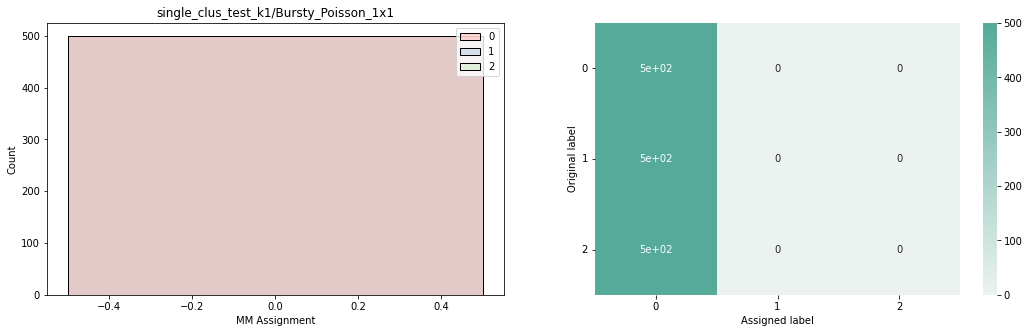

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


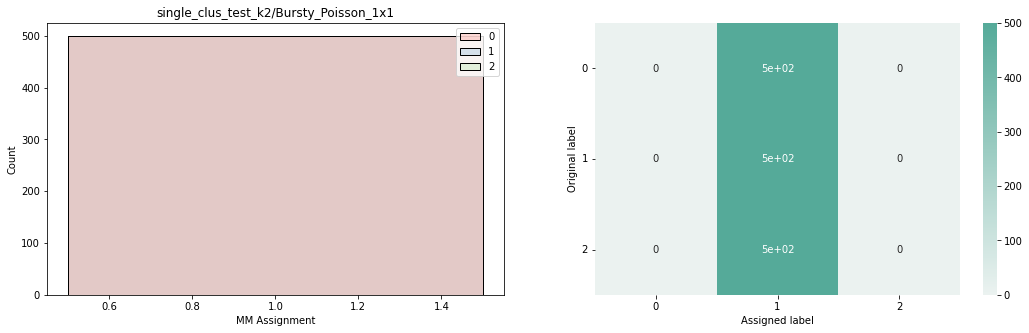

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


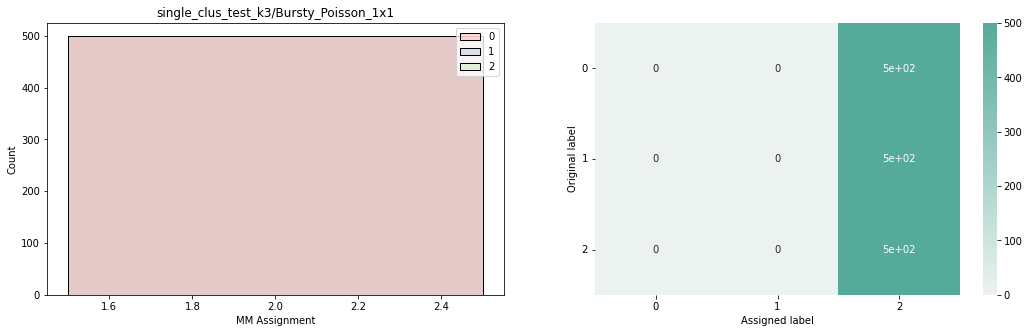

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


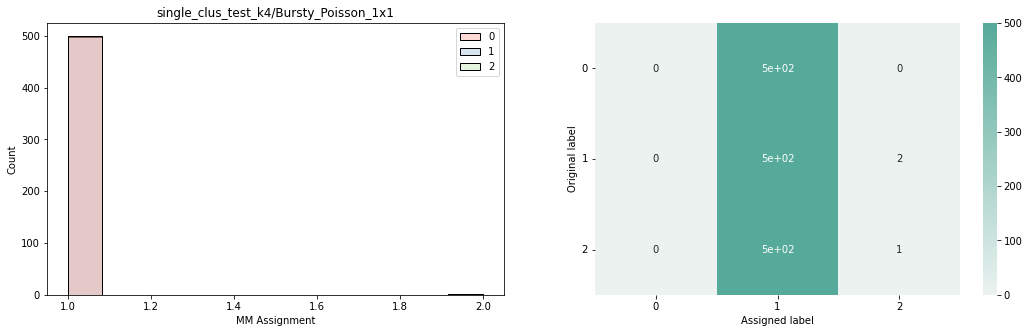

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(4, 4)


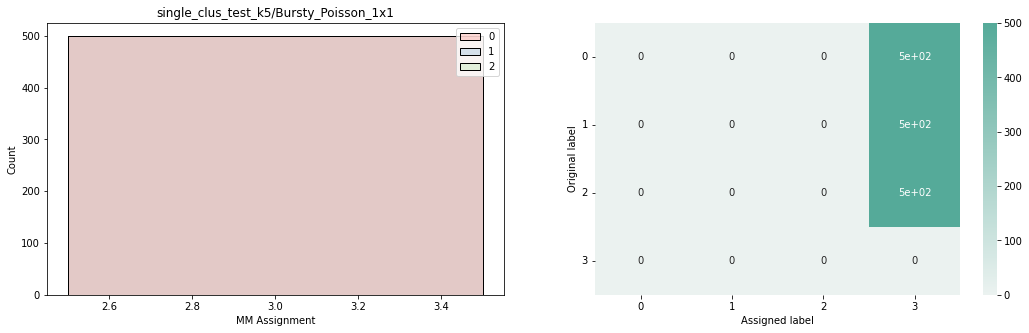

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


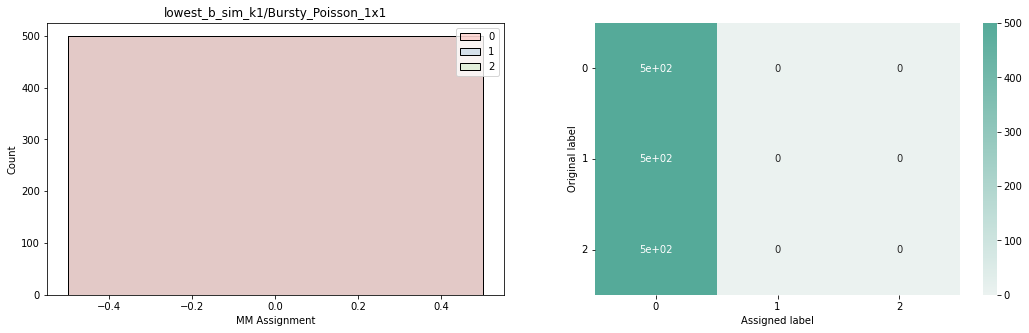

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


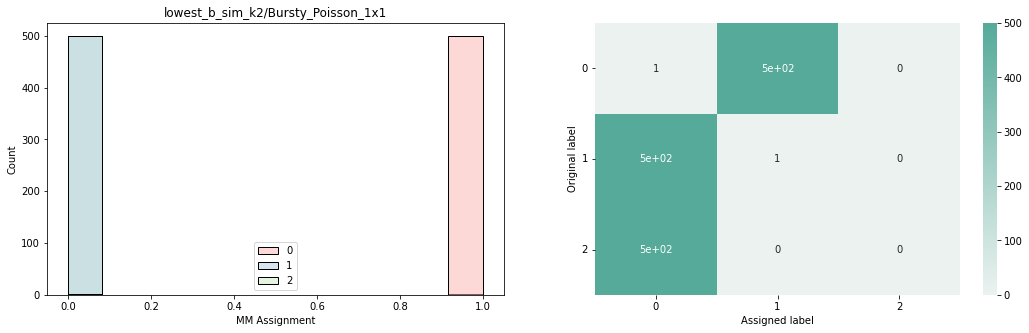

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


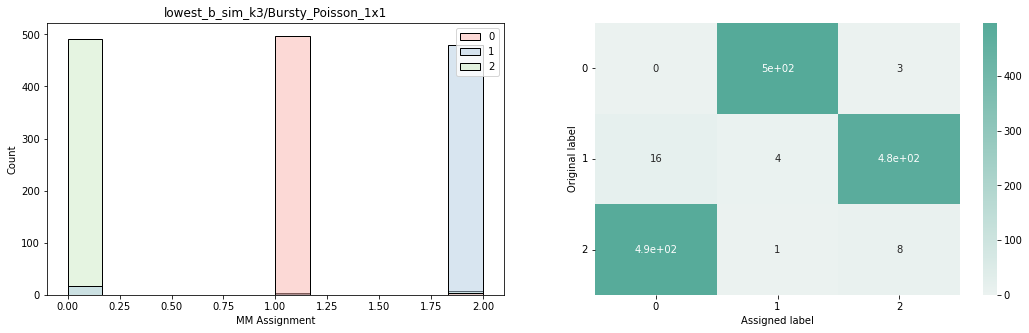

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(4, 4)


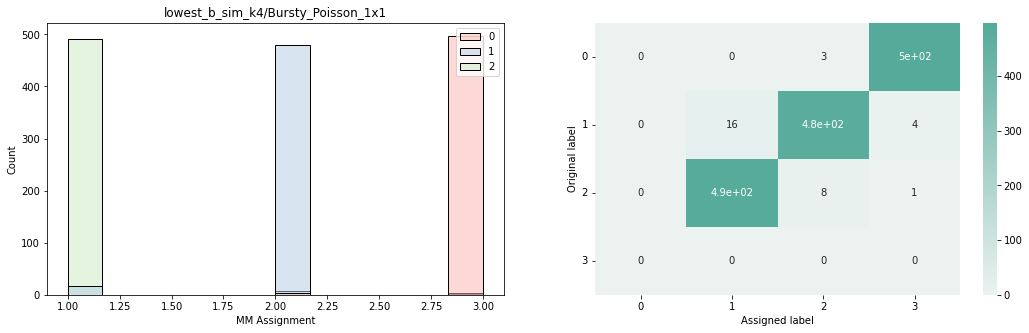

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(4, 4)


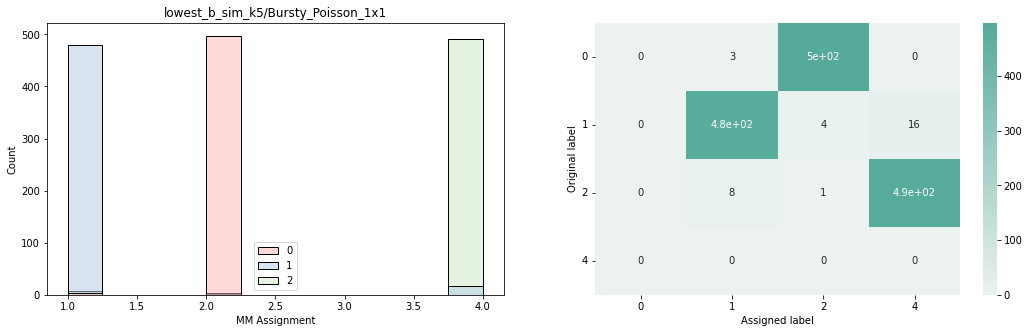

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


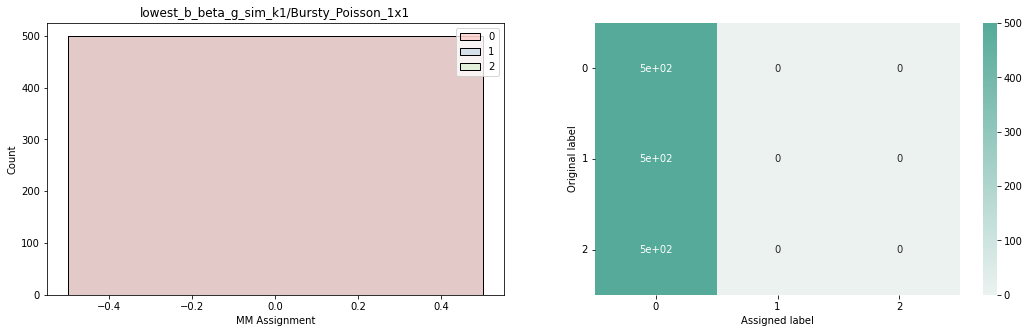

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


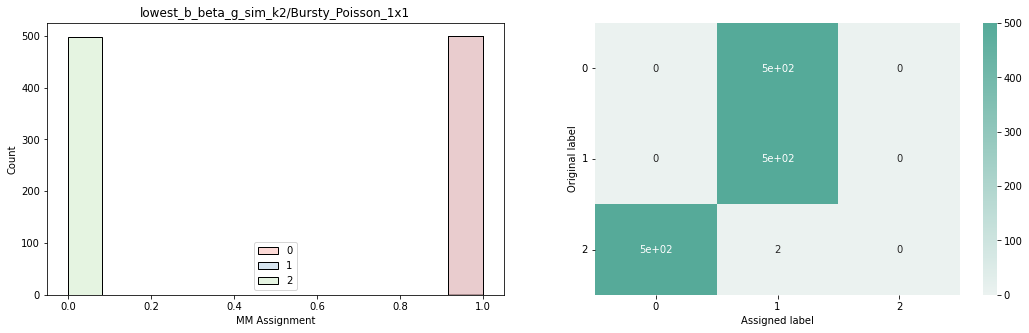

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


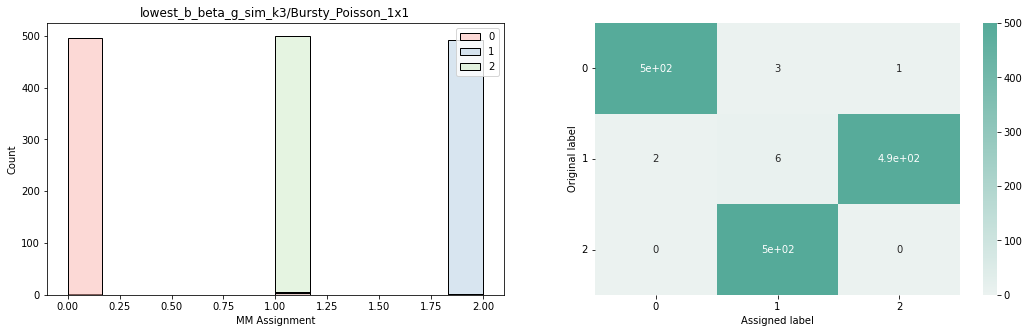

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(4, 4)


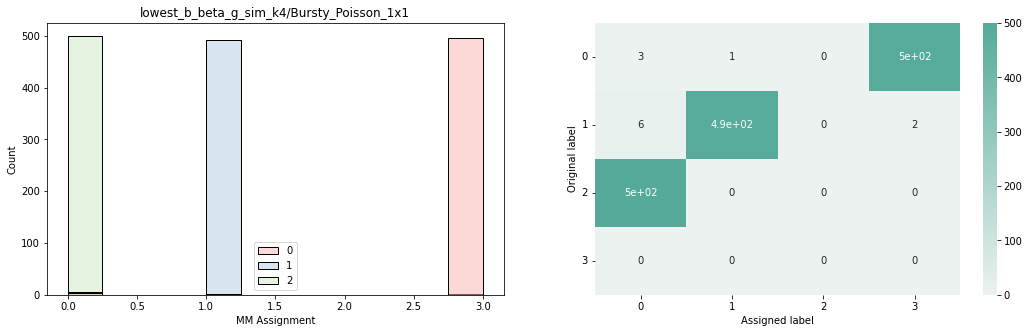

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


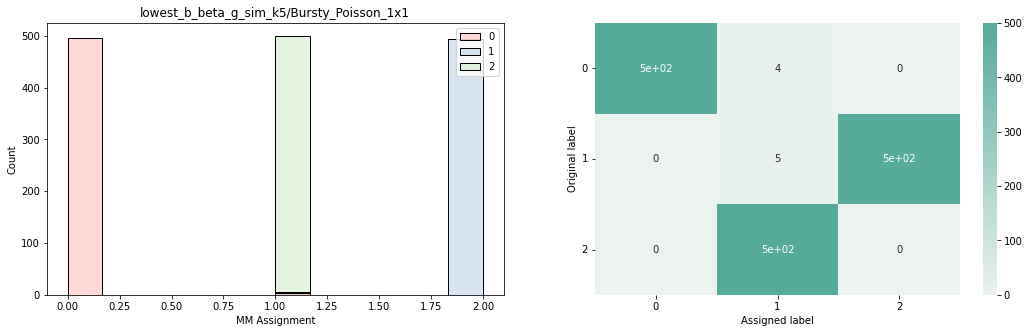

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


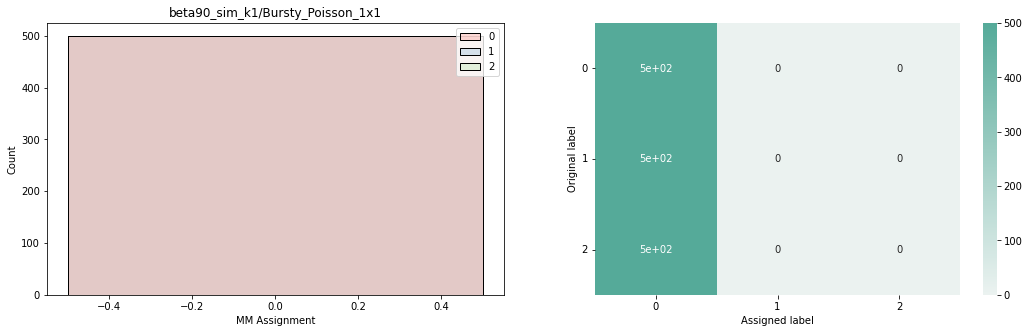

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


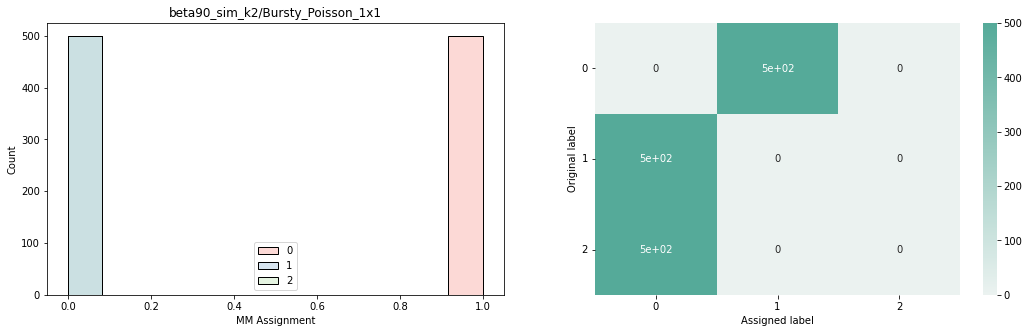

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


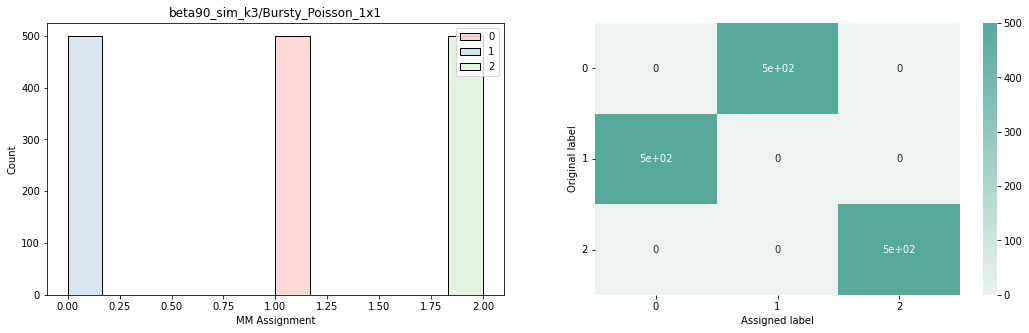

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(4, 4)


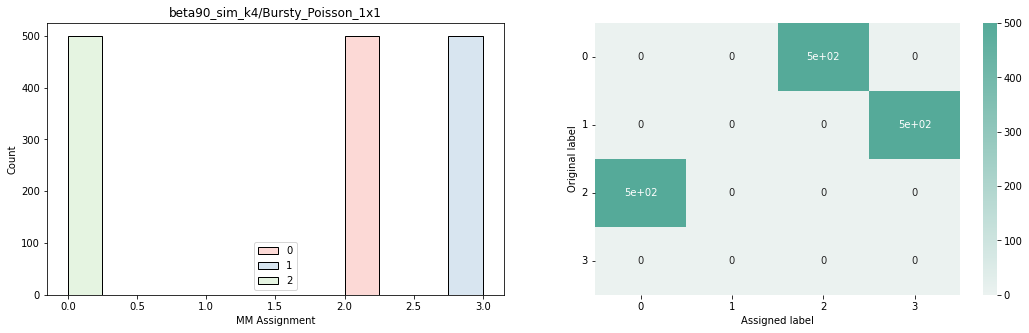

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(5, 5)
(5, 5)


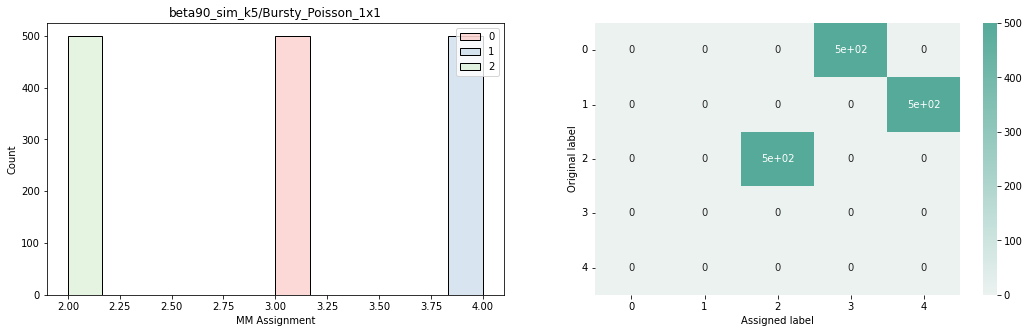

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


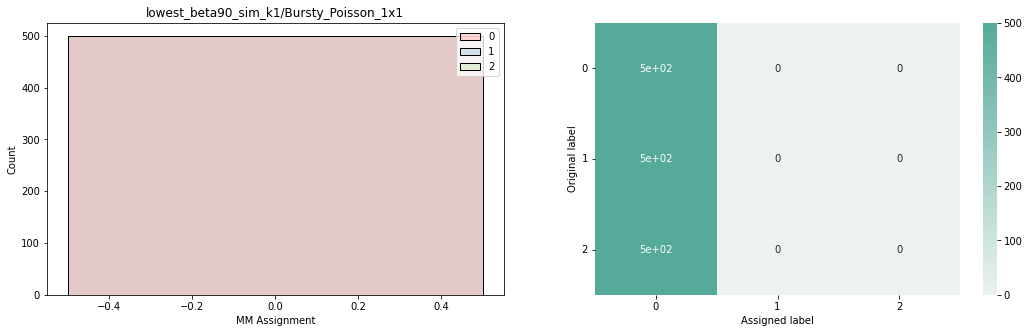

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


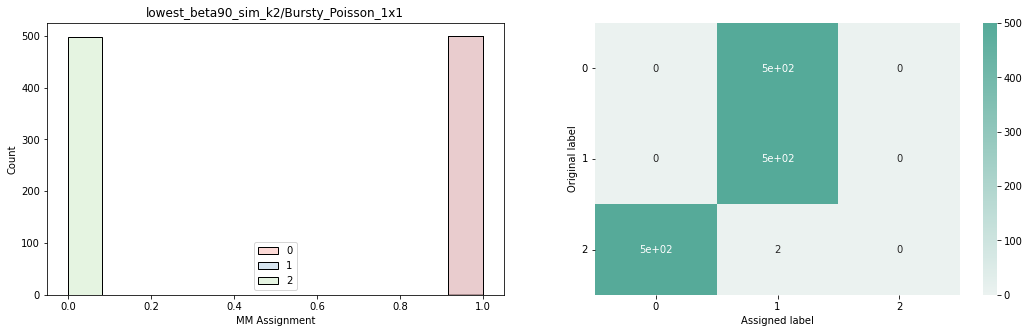

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


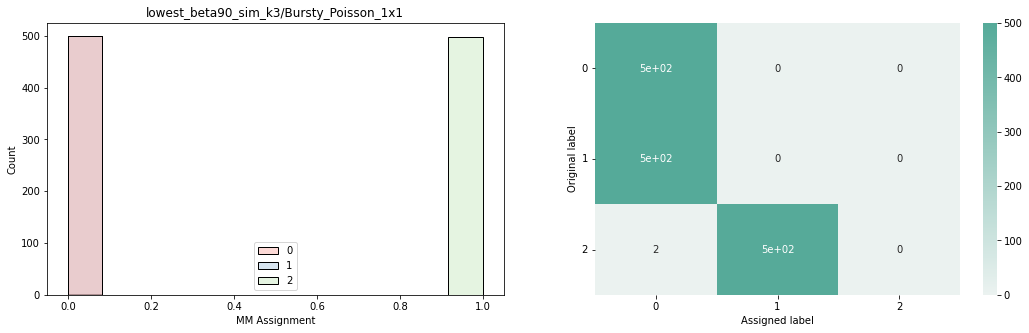

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(4, 4)


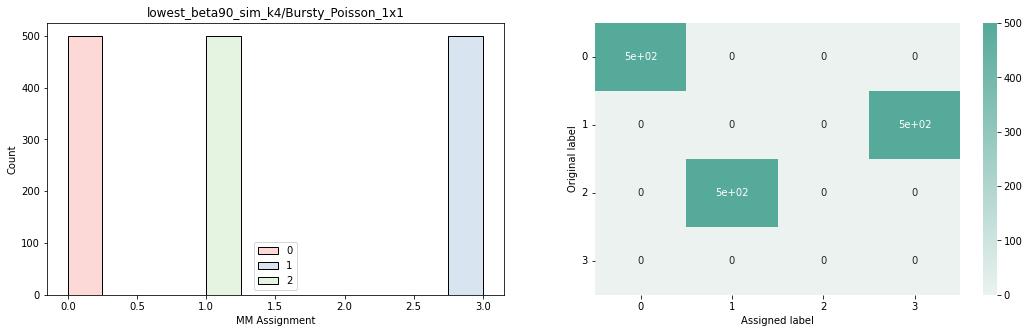

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(4, 4)


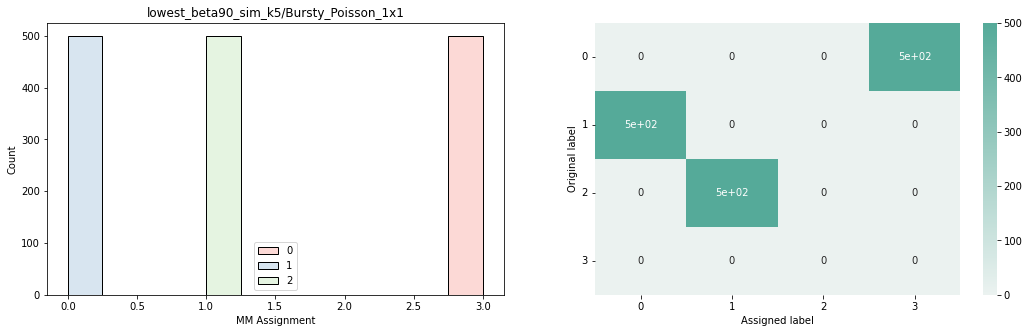

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


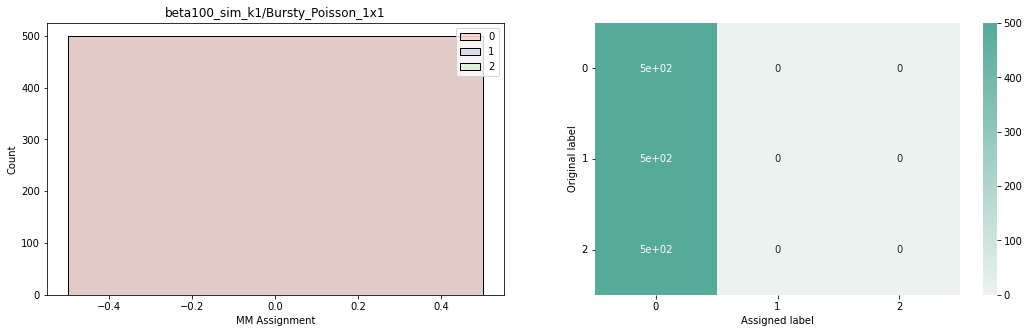

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


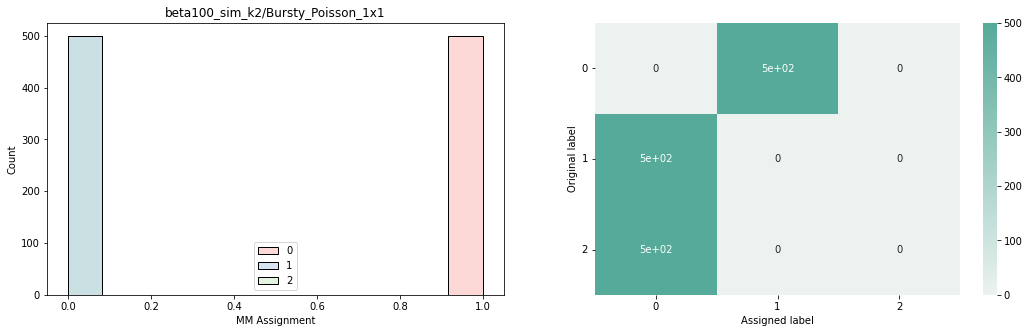

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


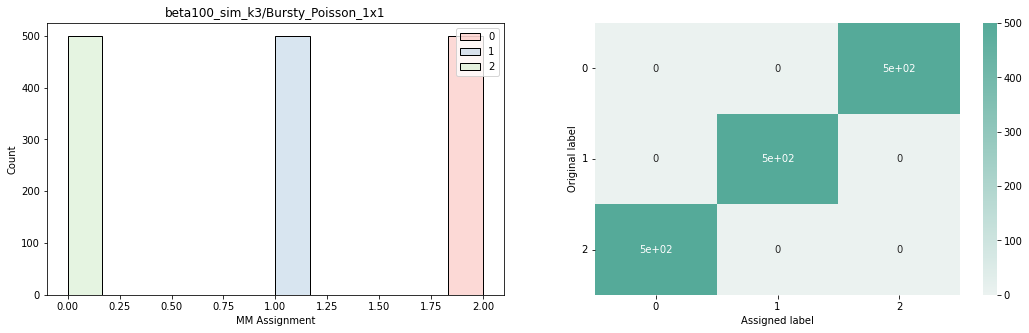

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


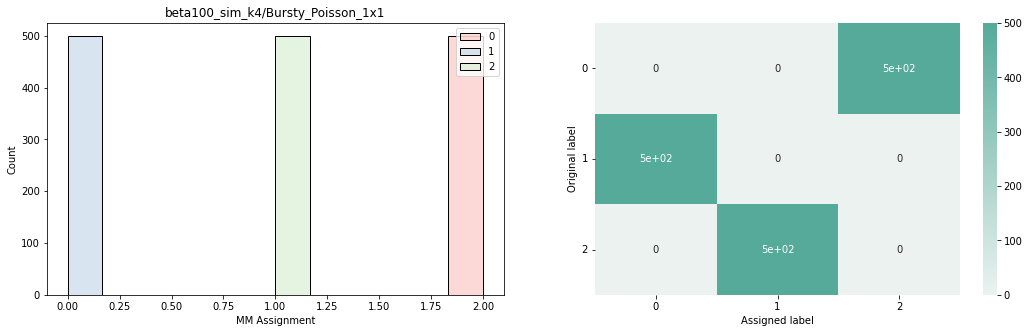

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(4, 4)


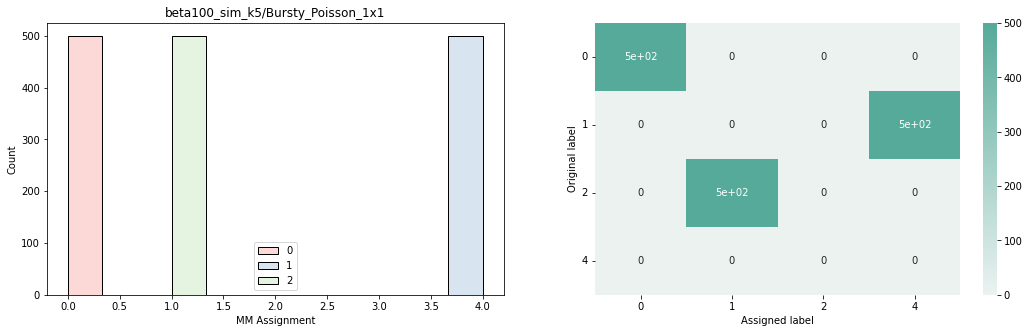

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


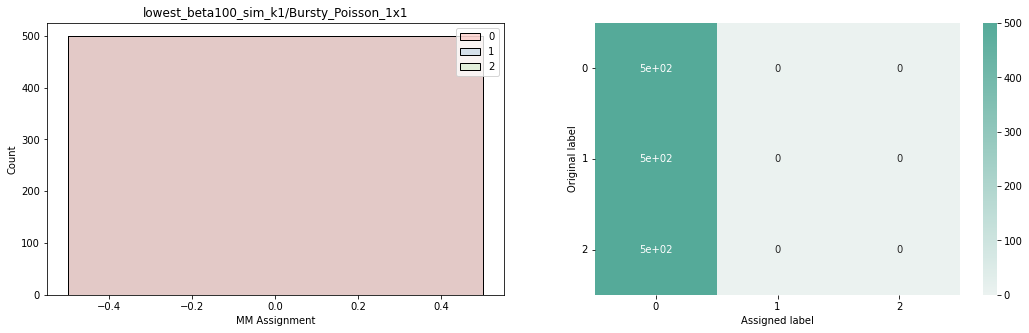

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


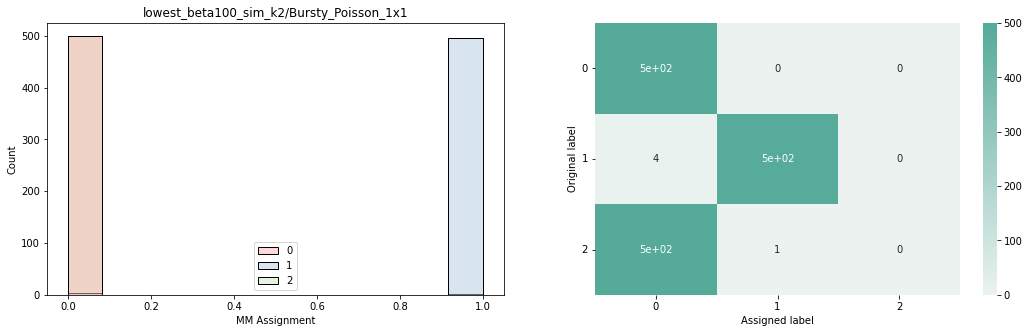

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


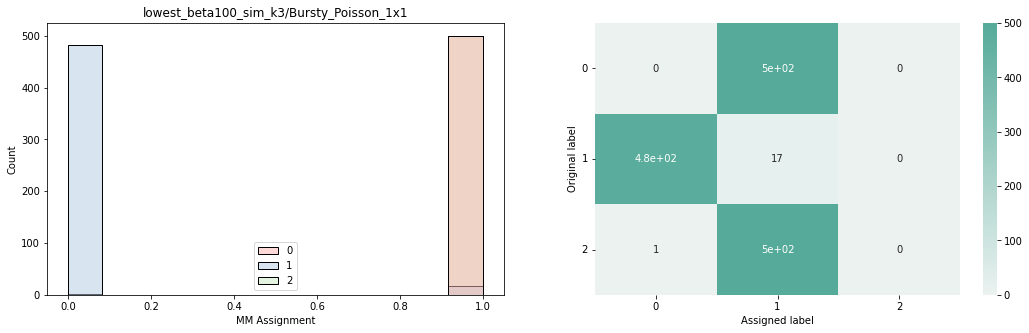

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


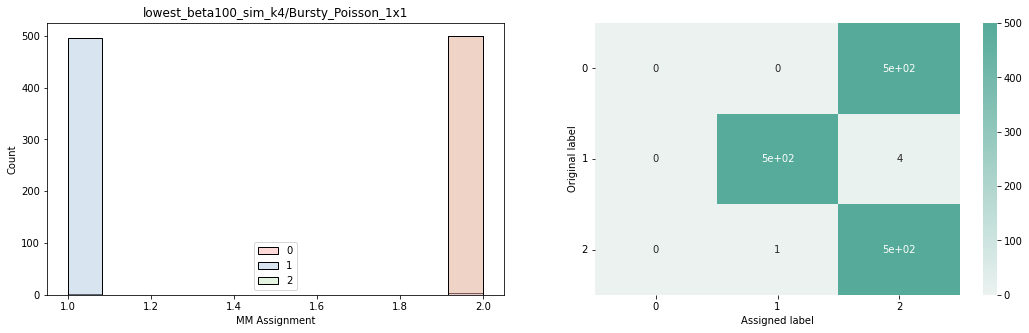

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(5, 5)
(5, 5)


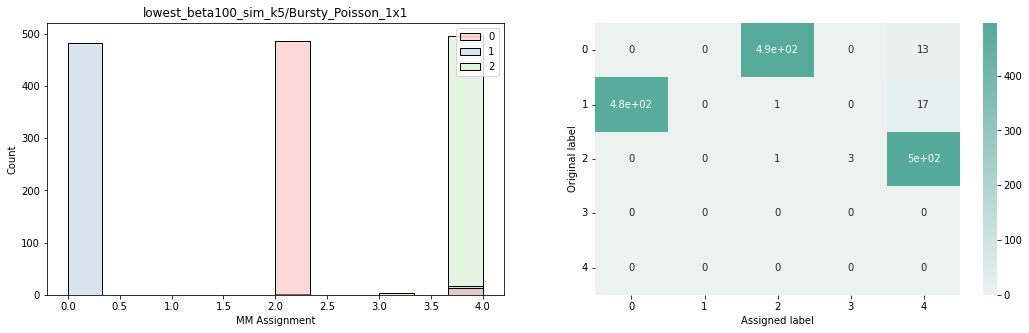

In [85]:
for r in grid_point_results:
    title = r.inference_string.replace('./fits/gg_230412_025_simTests_MM_1/','') #./fits/gg_230411_025_simTests_MM_1/
    vis_assign(np.array(all_assigns),r.assigns,title)


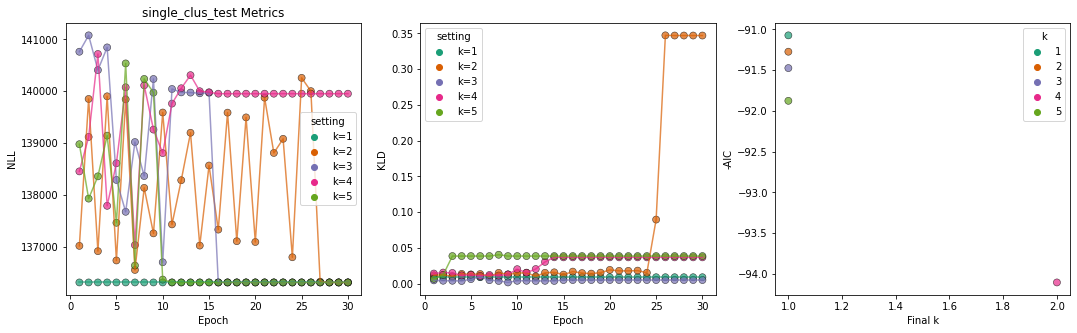

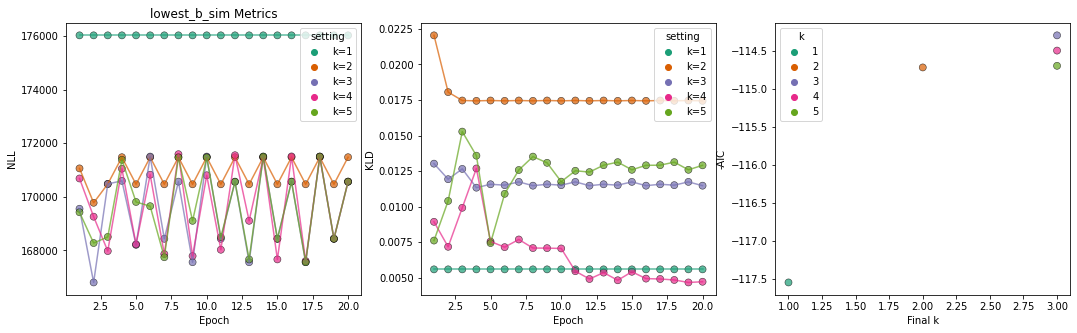

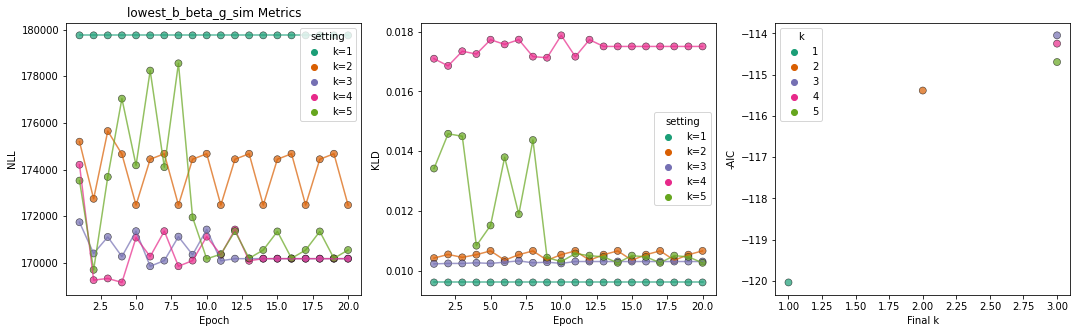

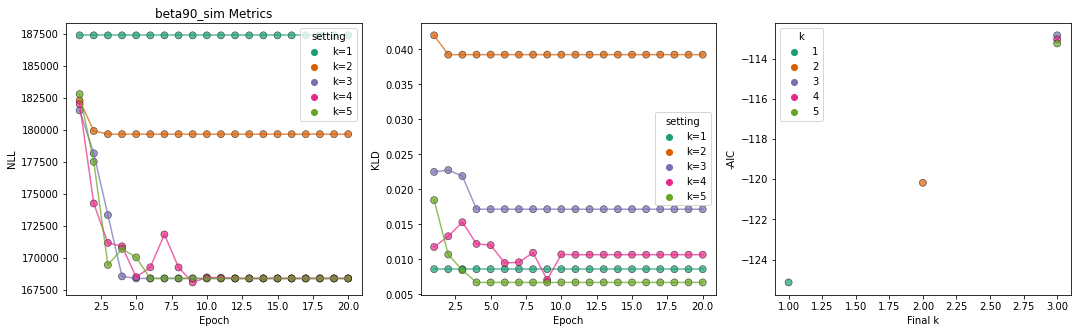

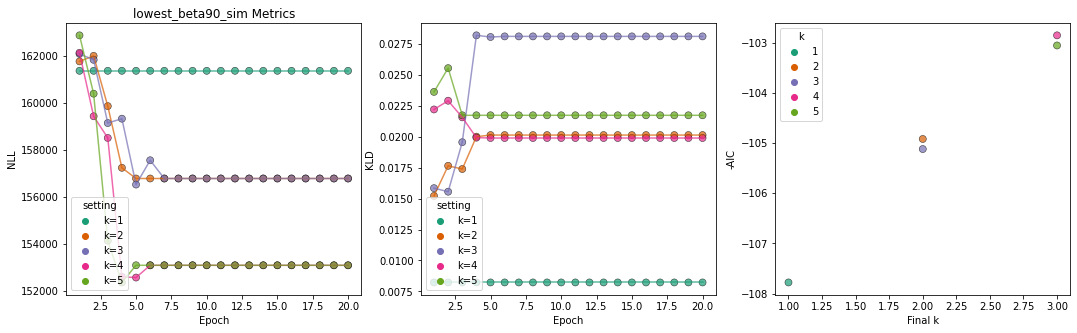

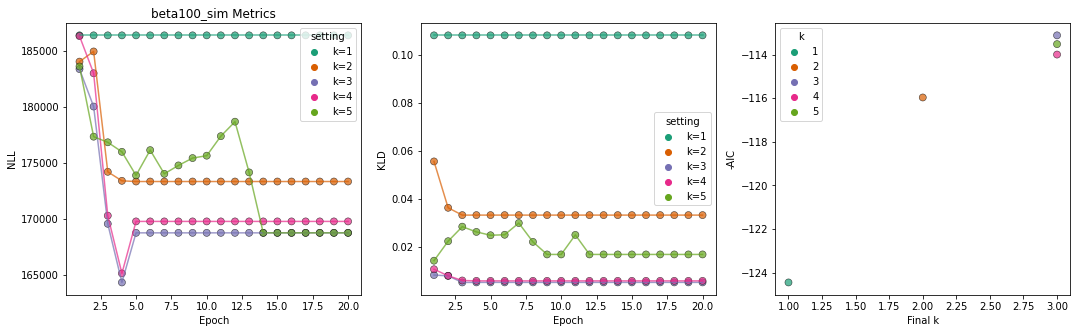

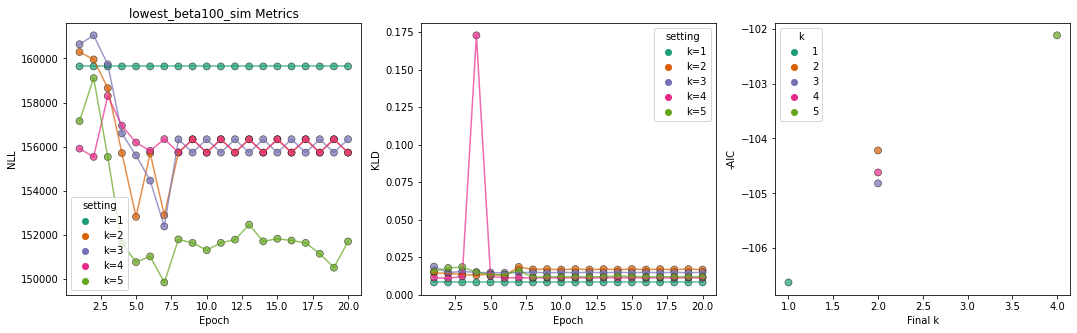

In [86]:
for i in range(0, len(grid_point_results), 5):
    r = grid_point_results[i:i+5]
    title = dataset_meta[i]+' Metrics'
    vis_metrics(r,title)

In [236]:
for i in range(len(dataset_names)):
    print(str(i)+': '+dataset_names[i])

0: lowest_b_sim_k1
1: lowest_b_sim_k2
2: lowest_b_sim_k3
3: lowest_b_sim_k4
4: lowest_b_sim_k5
5: lowest_b_beta_g_sim_k1
6: lowest_b_beta_g_sim_k2
7: lowest_b_beta_g_sim_k3
8: lowest_b_beta_g_sim_k4
9: lowest_b_beta_g_sim_k5
10: beta90_sim_k1
11: beta90_sim_k2
12: beta90_sim_k3
13: beta90_sim_k4
14: beta90_sim_k5
15: lowest_beta90_sim_k1
16: lowest_beta90_sim_k2
17: lowest_beta90_sim_k3
18: lowest_beta90_sim_k4
19: lowest_beta90_sim_k5
20: beta100_sim_k1
21: beta100_sim_k2
22: beta100_sim_k3
23: beta100_sim_k4
24: beta100_sim_k5
25: lowest_beta100_sim_k1
26: lowest_beta100_sim_k2
27: lowest_beta100_sim_k3
28: lowest_beta100_sim_k4
29: lowest_beta100_sim_k5
30: oneClus_lowest_b_sim_k1
31: oneClus_lowest_b_beta_g_sim_k1
32: oneClus_lowest_beta90_sim_k1


(array([ 1.,  3., 10., 14., 23., 21., 10.,  9.,  7.,  2.]),
 array([-0.7320736 , -0.48348184, -0.23489008,  0.01370168,  0.26229344,
         0.5108852 ,  0.75947697,  1.00806873,  1.25666049,  1.50525225,
         1.75384401]),
 <BarContainer object of 10 artists>)

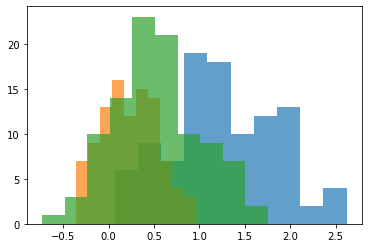

In [81]:
plt.hist(all_params[0][2,:,0],alpha=0.7)
plt.hist(all_params[0][2,:,2],alpha=0.7)
plt.hist(all_params[0][2,:,3],alpha=0.7)

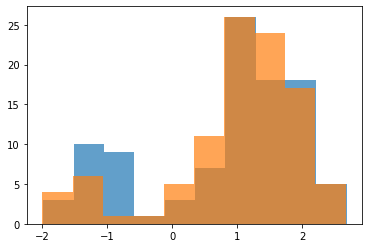

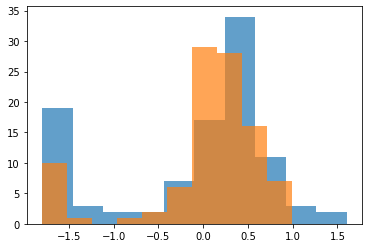

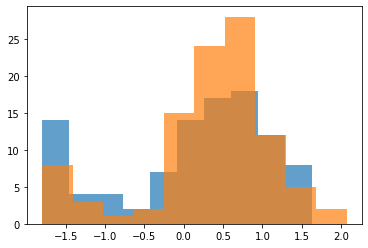

In [82]:
for p_ind in range(3):
    plt.figure()
    plt.hist(grid_point_results[2].param_estimates[:,p_ind,0],alpha=0.7)
    plt.hist(grid_point_results[2].param_estimates[:,p_ind,1],alpha=0.7)

In [172]:
search_data.M[:,0].shape

(2,)

### **Compare Monod Fits to Simulation and MM Fits**

In [91]:
#Check results for burst size > 1
def get_logL(ps,counts,search_data):
    bs = ps[:,0]
    betas = ps[:,1]
    gammas = ps[:,2]
    
    EPS=1e-15
    
    logL = 0
    
    for g in range(n_genes):
        

        x = counts[:,g,:].T
        x = x.astype(int)
        
        b = 10**bs[g]
        beta = 10**betas[g]
        gamma = 10**gammas[g]
        
        
        
        g_len = lens_sub[g]

        lam_n = 10**((glob_samp[0]) + np.log10(g_len))
        lam_m = 10**(glob_samp[1])

        p = np.log10(np.asarray([b,beta,gamma])) #[b,beta,gamma]
        burst_model = BurstModel('Poisson')

        #max_mean = b*np.asarray([lam_n/beta,lam_m/gamma]) #np.array(samp)*
        #max_std = np.sqrt(max_mean*(1+ b*np.asarray([1,beta/(beta+gamma)])))

        #max_std = np.sqrt(max_mean*(1+np.asarray([lam_n*(1+b), lam_m*(1+b*beta/(beta+gamma))])))

#         max_domain = np.array([np.amax(x[0,:])+10,np.amax(x[1,:])+10])
#         print(max_domain)
        #max_domain = [int(i) for i in max_domain]

        proposal = burst_model.get_Pss(p,search_data.M[:, g],np.log10([lam_n,lam_m]))

        proposal[proposal < EPS] = EPS

        proposal = proposal[tuple(x)]
        logL += np.sum(np.log(proposal))
        
    return logL

In [92]:
len(sr)

3

In [93]:
#b_sim
#0,0,2or7     0,0,2
def plot_params(search_data,all_counts,sr,all_params,grid_point_results,res_inds=[0,0,0],clus_inds=[0,0,0]):
    
    b_sim_monod = sr[res_inds[0]].param_estimates[clus_inds[0]]
    b_sim_true = all_params[res_inds[1]][clus_inds[1],:,:] #kxgenex6 -->0,2,3 b,beta,gamma
    b_sim_mm = grid_point_results[res_inds[2]].param_estimates[:,:,clus_inds[2]]
    
    
    #Get true counts + print likelihoods
    true_counts = all_counts[res_inds[1]][0:500,:,:]
    
    print('True Param LogL: ',get_logL(b_sim_true[:,[0,2,3]],true_counts,search_data))
    print('Monod Param LogL: ',get_logL(b_sim_monod,true_counts,search_data))
    print('MM Param LogL: ',get_logL(b_sim_mm,true_counts,search_data))
    
    
    
    
    
    rho =[]
    p = []   
    
    

    comps = pd.DataFrame()
    comps['b'] = list(b_sim_monod[:,0])+list(b_sim_true[:,0])+list(b_sim_mm[:,0])
    comps['beta'] = list(b_sim_monod[:,1])+list(b_sim_true[:,2])+list(b_sim_mm[:,1])
    comps['gamma'] = list(b_sim_monod[:,2])+list(b_sim_true[:,3])+list(b_sim_mm[:,2])
    comps['setting'] = ['Monod']*n_genes + ['Sim']*n_genes + ['MM']*n_genes


    #Plot param histograms
    fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(18,18))

    #b,beta,gamma histograms
    sns.histplot(data=comps,x='b',hue='setting',kde=True,ax=ax[0,0])
    sns.histplot(data=comps,x='beta',hue='setting',kde=True,ax=ax[0,1])
    sns.histplot(data=comps,x='gamma',hue='setting',kde=True,ax=ax[0,2])
    



    #Plot correlations
    comps_monod = comps[comps.setting.isin(['Monod'])]
    comps_true = comps[comps.setting.isin(['Sim'])]
    comps_mm = comps[comps.setting.isin(['MM'])]
    sns.scatterplot(x=list(comps_monod['b']),y=list(comps_true['b']),hue=list(comps_true['b']),
                    s=50,edgecolor='black',color='cornflowerblue', alpha=0.7,ax=ax[1,0])
    #ax[1,0].text(x=-1, y=2, s=np.corrcoef(list(comps_monod['b']),list(comps_true['b']))[0,1])
    
    rho += [np.corrcoef(list(comps_monod['b']),y=list(comps_true['b']))[0,1]]
    p += [scipy.stats.spearmanr(list(comps_monod['b']),list(comps_true['b']))[0]]

    sns.scatterplot(x=list(comps_monod['beta']),y=list(comps_true['beta']),hue=list(comps_true['b']),
                    s=50,edgecolor='black',color='cornflowerblue', alpha=0.7,ax=ax[1,1],legend=False)
    #ax[1,1].text(x=-1, y=0.5, s=np.corrcoef(list(comps_monod['beta']),list(comps_true['beta']))[0,1])
    
    rho += [np.corrcoef(list(comps_monod['beta']),list(comps_true['beta']))[0,1]]
    p += [scipy.stats.spearmanr(list(comps_monod['beta']),list(comps_true['beta']))[0]]


    sns.scatterplot(x=list(comps_monod['gamma']),y=list(comps_true['gamma']),hue=list(comps_true['b']),
                    s=50,edgecolor='black',color='cornflowerblue', alpha=0.7,ax=ax[1,2],legend=False)
    #ax[1,2].text(x=-1, y=0.5, s=np.corrcoef(list(comps_monod['gamma']),list(comps_true['gamma']))[0,1])
    rho += [np.corrcoef(list(comps_monod['gamma']),list(comps_true['gamma']))[0,1]]
    p += [scipy.stats.spearmanr(list(comps_monod['gamma']),list(comps_true['gamma']))[0]]
    
    ax[1,0].set_xlabel('Monod')
    ax[1,0].set_ylabel('True')



    #monod v mm
    sns.scatterplot(x=list(comps_monod['b']),y=list(comps_mm['b']),hue=list(comps_true['b']),
                    s=50,edgecolor='black',color='cornflowerblue', alpha=0.7,ax=ax[2,0])
    #ax[2,0].text(x=-1, y=2, s=np.corrcoef(list(comps_monod['b']),list(comps_mm['b']))[0,1])
    
    rho += [np.corrcoef(list(comps_monod['b']),list(comps_mm['b']))[0,1]]
    p += [scipy.stats.spearmanr(list(comps_monod['b']),list(comps_mm['b']))[0]]
    

    sns.scatterplot(x=list(comps_monod['beta']),y=list(comps_mm['beta']),hue=list(comps_true['b']),
                    s=50,edgecolor='black',color='cornflowerblue', alpha=0.7,ax=ax[2,1],legend=False)
    #ax[2,1].text(x=-1, y=0.5, s=np.corrcoef(list(comps_monod['beta']),list(comps_mm['beta']))[0,1])
    rho += [np.corrcoef(list(comps_monod['beta']),list(comps_mm['beta']))[0,1]]
    p += [scipy.stats.spearmanr(list(comps_monod['beta']),list(comps_mm['beta']))[0]]


    sns.scatterplot(x=list(comps_monod['gamma']),y=list(comps_mm['gamma']),hue=list(comps_true['b']),
                    s=50,edgecolor='black',color='cornflowerblue', alpha=0.7,ax=ax[2,2],legend=False)
    #ax[2,2].text(x=-1, y=0.5, s=np.corrcoef(list(comps_monod['gamma']),list(comps_mm['gamma']))[0,1])
    rho += [np.corrcoef(list(comps_monod['gamma']),list(comps_mm['gamma']))[0,1]]
    p += [scipy.stats.spearmanr(list(comps_monod['gamma']),list(comps_mm['gamma']))[0]]
    
    ax[2,0].set_xlabel('Monod')
    ax[2,0].set_ylabel('MM')


    #mm v true
    sns.scatterplot(x=list(comps_mm['b']),y=list(comps_true['b']),hue=list(comps_true['b']),
                    s=50,edgecolor='black',color='cornflowerblue', alpha=0.7,ax=ax[3,0])
    #ax[3,0].text(x=-1, y=2, s=np.corrcoef(list(comps_mm['b']),list(comps_true['b']))[0,1])
    rho += [np.corrcoef(list(comps_mm['b']),list(comps_true['b']))[0,1]]
    p += [scipy.stats.spearmanr(list(comps_mm['b']),list(comps_true['b']))[0]]

    sns.scatterplot(x=list(comps_mm['beta']),y=list(comps_true['beta']),hue=list(comps_true['b']),
                    s=50,edgecolor='black',color='cornflowerblue', alpha=0.7,ax=ax[3,1],legend=False)
    #ax[3,1].text(x=-1, y=0.5, s=np.corrcoef(list(comps_mm['beta']),list(comps_true['beta']))[0,1])
    rho += [np.corrcoef(list(comps_mm['beta']),list(comps_true['beta']))[0,1]]
    p += [scipy.stats.spearmanr(list(comps_mm['beta']),list(comps_true['beta']))[0]]


    sns.scatterplot(x=list(comps_mm['gamma']),y=list(comps_true['gamma']),hue=list(comps_true['b']),
                    s=50,edgecolor='black',color='cornflowerblue', alpha=0.7,ax=ax[3,2],legend=False)
    #ax[3,2].text(x=-1, y=0.5, s=np.corrcoef(list(comps_mm['gamma']),list(comps_true['gamma']))[0,1])
    rho += [np.corrcoef(list(comps_mm['gamma']),list(comps_true['gamma']))[0,1]]
    p += [scipy.stats.spearmanr(list(comps_mm['gamma']),list(comps_true['gamma']))[0]]
    
    ax[3,0].set_xlabel('MM')
    ax[3,0].set_ylabel('True')
    
    
    for i, a in enumerate(ax.flat):

        if i not in [0,1,2]:
            bot,top = a.get_ylim()
            l,r = a.get_xlim()

            newl = np.min([bot,l])
            newr = np.max([top,r])

            a.set_xlim((newl,newr))
            a.set_ylim((newl,newr))
            
            a.text(.05,.7,r'$r$ = {:.2f}'.format(rho[i-3]),fontsize=14,transform=a.transAxes)
            a.text(.05,.8,r'$\rho$ = {:.2f}'.format(p[i-3]),fontsize=14,transform=a.transAxes)
            
            a.plot(a.get_xlim(),a.get_xlim(),'--',color=[116/255,112/255,113/255],linewidth=3,alpha=0.4)
        
        

    
    plt.show()

In [96]:
dataset_names[7]

'lowest_b_sim_k3'

INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_b_sim_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/lowest_b_sim_k3/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/lowest_b_sim_k3/raw.sd.
True Param LogL:  -55138.17914472037
Monod Param LogL:  -54986.29498705643
MM Param LogL:  -54992.08195514626


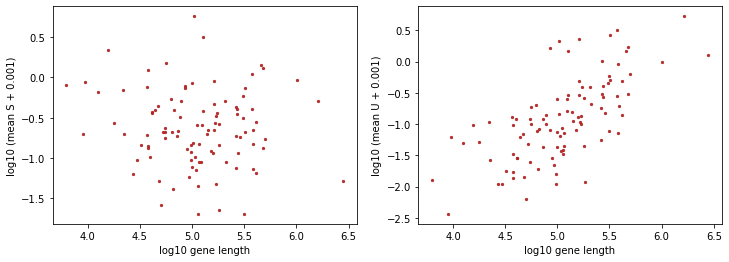

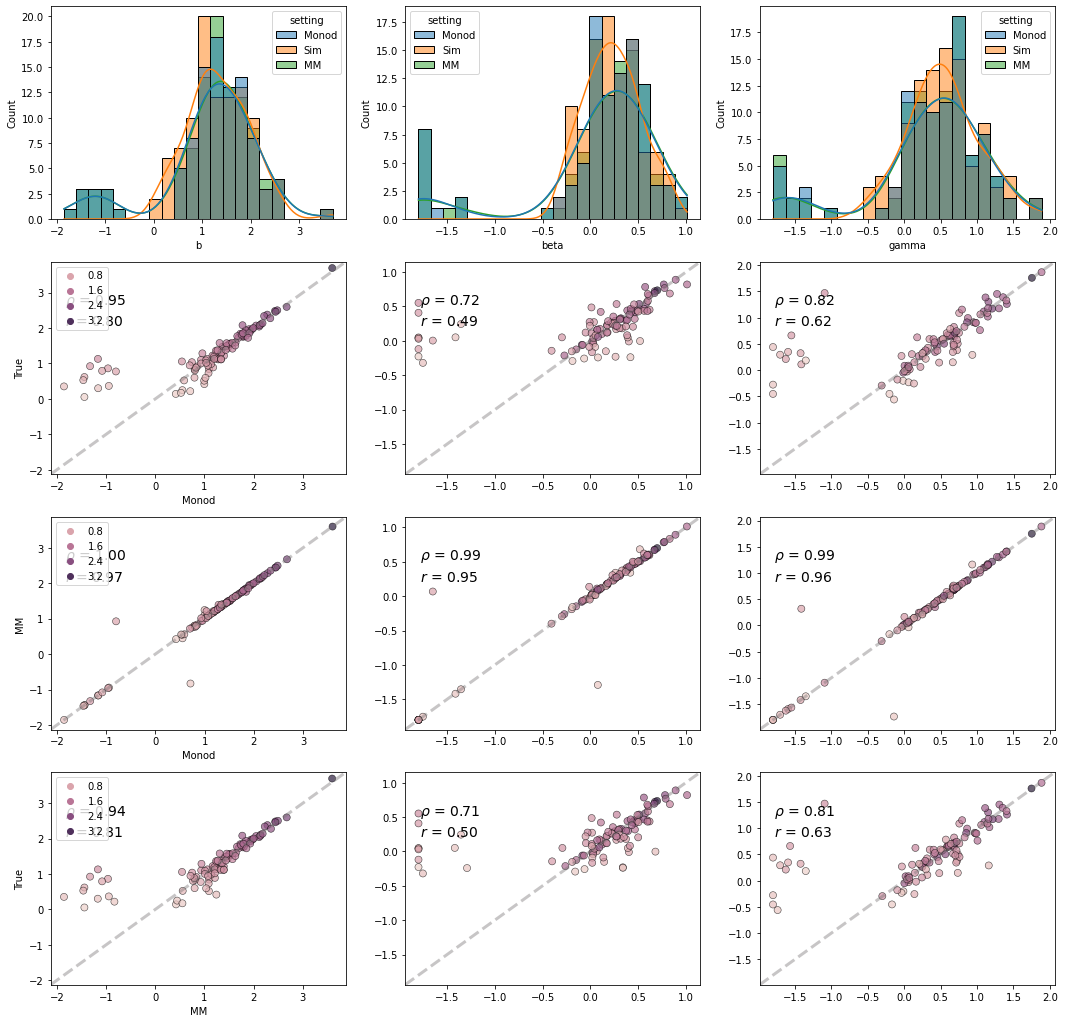

In [97]:
#0,1,7 lowest_b_sim_k3
search_data = monod.extract_data.extract_data(loom_filepaths[7], transcriptome_filepath, dataset_names[7],
                dataset_strings[7], dir_string, dataset_attr_names=attribute_names,cf=cf[7])
    
plot_params(search_data,all_counts,sr,all_params,grid_point_results,res_inds=[0,1,7],clus_inds=[0,0,1])

INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_b_sim_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/lowest_b_sim_k3/diagnostic_figures already exists.
INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/lowest_b_sim_k3/raw.sd.
True Param LogL:  -55138.17914472037
Monod Param LogL:  -54986.29498705643
MM Param LogL:  -59472.89240945395


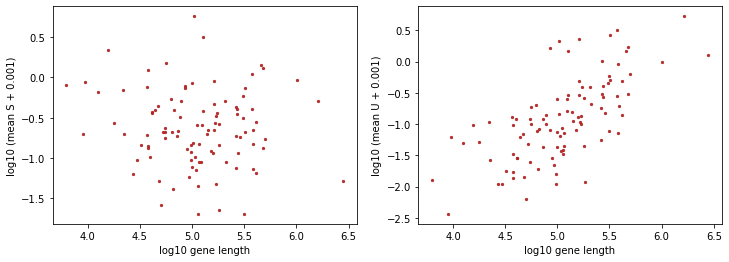

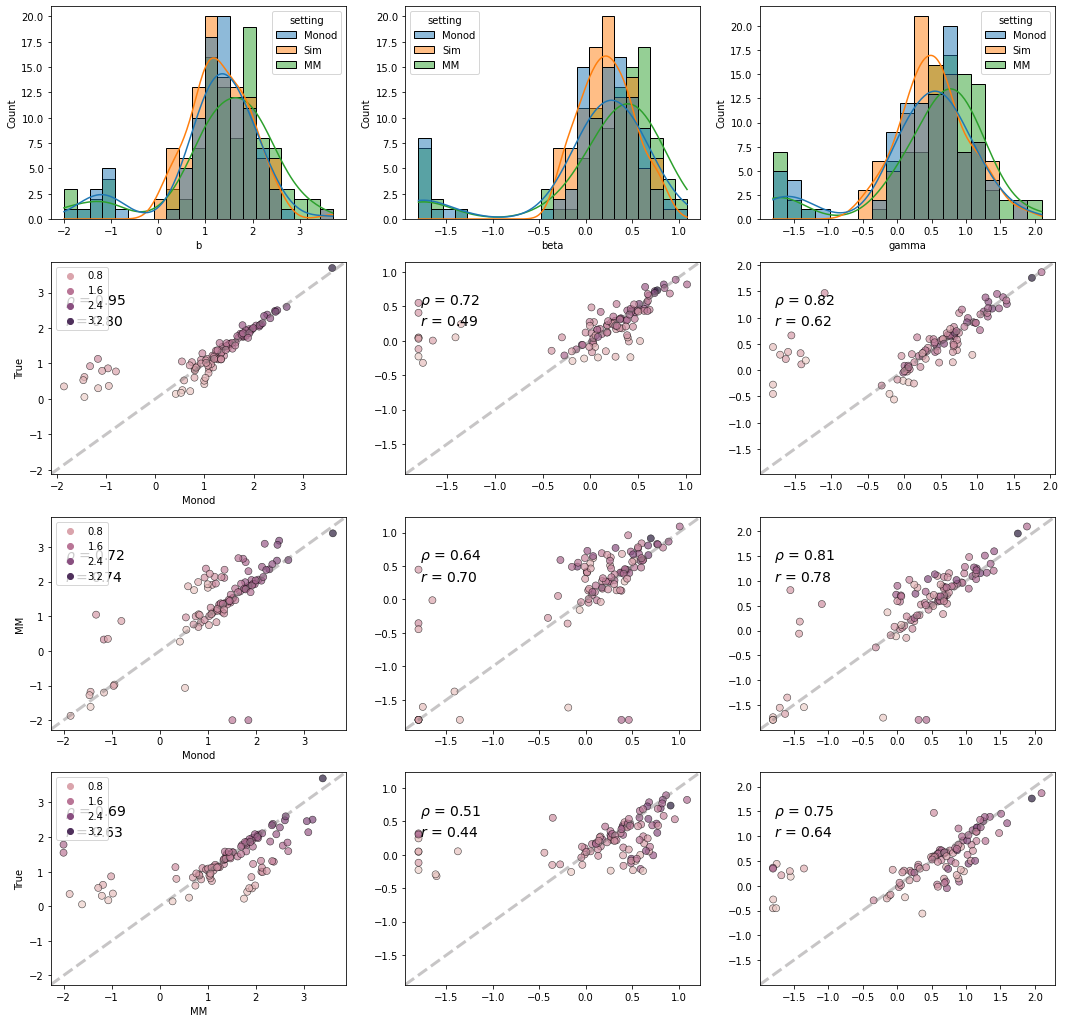

In [98]:
#0,1,7 lowest_b_sim_k3
search_data = monod.extract_data.extract_data(loom_filepaths[7], transcriptome_filepath, dataset_names[7],
                dataset_strings[7], dir_string, dataset_attr_names=attribute_names,cf=cf[7])
    
plot_params(search_data,all_counts,sr,all_params,grid_point_results,res_inds=[0,1,5],clus_inds=[0,0,0])

INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_b_beta_g_sim_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/lowest_b_beta_g_sim_k3/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/lowest_b_beta_g_sim_k3/raw.sd.
True Param LogL:  -55032.60954169864
Monod Param LogL:  -55005.89126054454
MM Param LogL:  -55968.52515938721


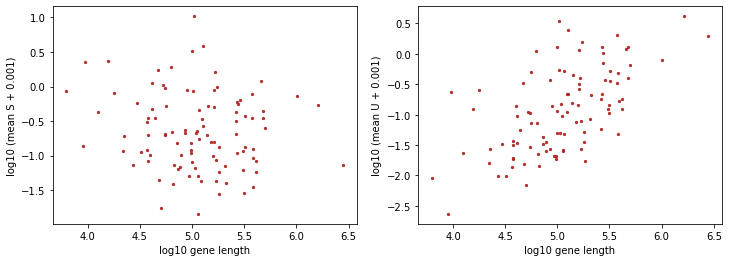

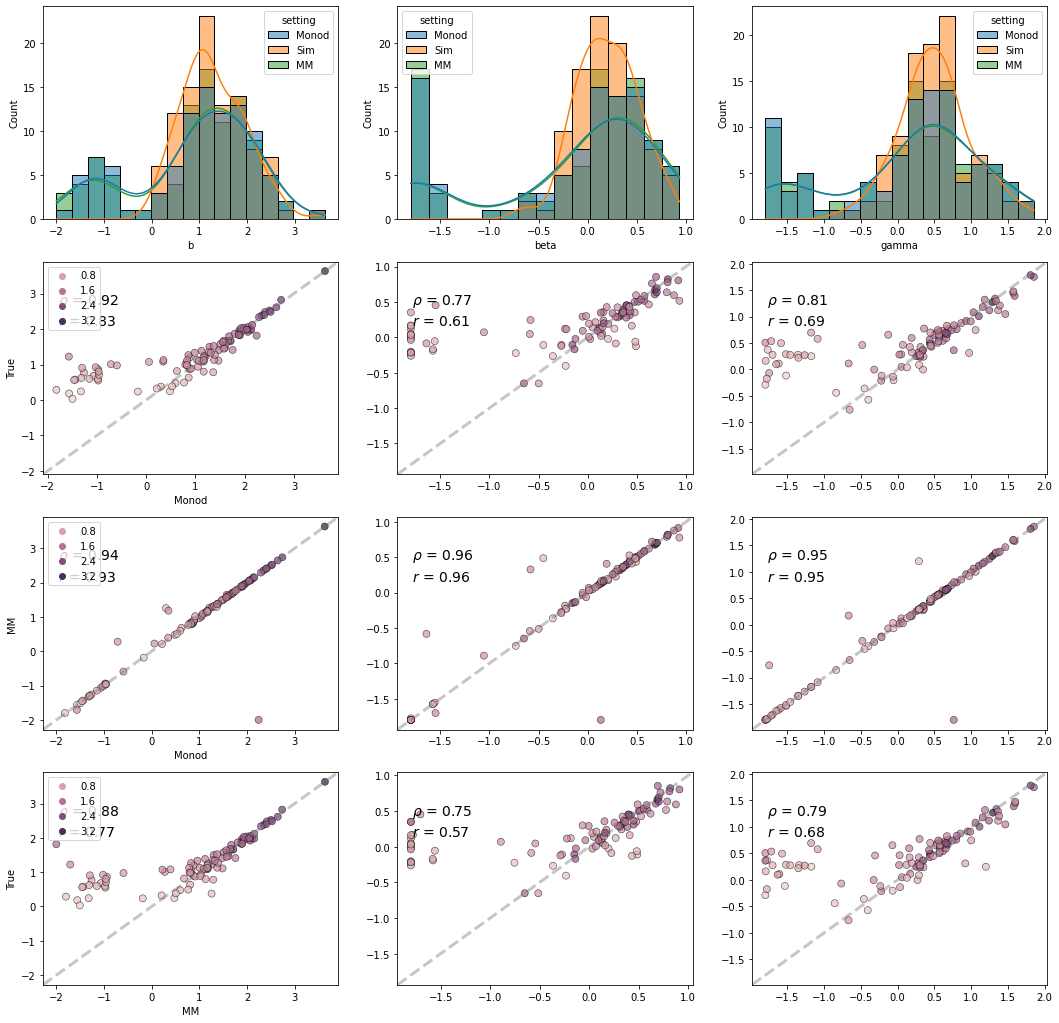

In [99]:
#1,2,12   lowest_b_beta_g_sim_k3
search_data = monod.extract_data.extract_data(loom_filepaths[12], transcriptome_filepath, dataset_names[12],
                dataset_strings[12], dir_string, dataset_attr_names=attribute_names,cf=cf[12])
    
plot_params(search_data,all_counts,sr,all_params,grid_point_results,res_inds=[1,2,12],clus_inds=[0,0,0])


INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_b_beta_g_sim_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/lowest_b_beta_g_sim_k3/diagnostic_figures already exists.
INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/lowest_b_beta_g_sim_k3/raw.sd.
True Param LogL:  -55032.60954169864
Monod Param LogL:  -55005.89126054454
MM Param LogL:  -59495.53354431104


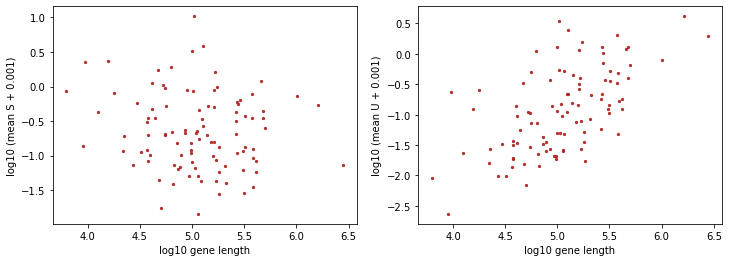

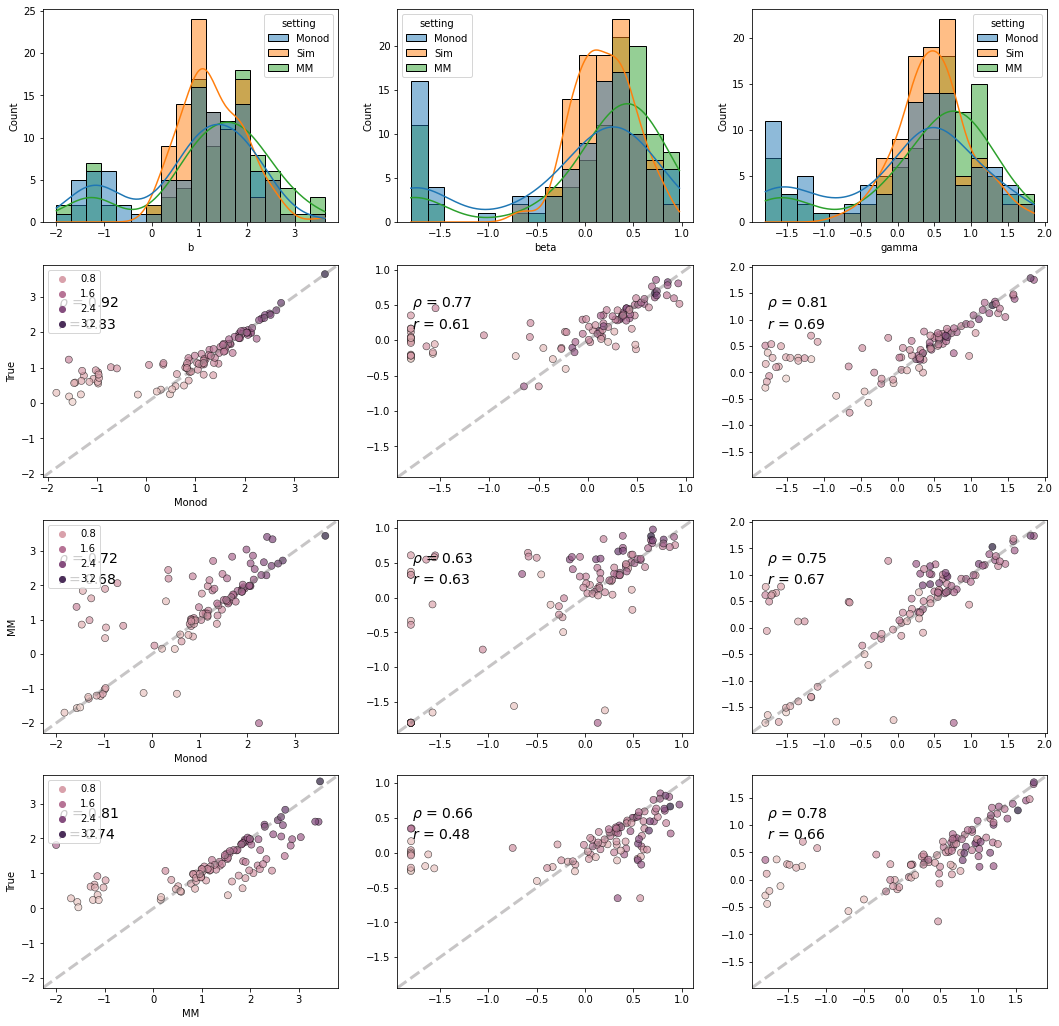

In [100]:
#1,2,12   lowest_b_beta_g_sim_k3
search_data = monod.extract_data.extract_data(loom_filepaths[12], transcriptome_filepath, dataset_names[12],
                dataset_strings[12], dir_string, dataset_attr_names=attribute_names,cf=cf[12])
    
plot_params(search_data,all_counts,sr,all_params,grid_point_results,res_inds=[1,2,10],clus_inds=[0,0,0])


In [111]:
dataset_names[17]

'beta90_sim_k3'

INFO:root:Beginning data extraction.
INFO:root:Dataset: beta90_sim_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/beta90_sim_k3/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/beta90_sim_k3/raw.sd.
True Param LogL:  -53492.40848004077
Monod Param LogL:  -57272.80457805495
MM Param LogL:  -57272.80457805495


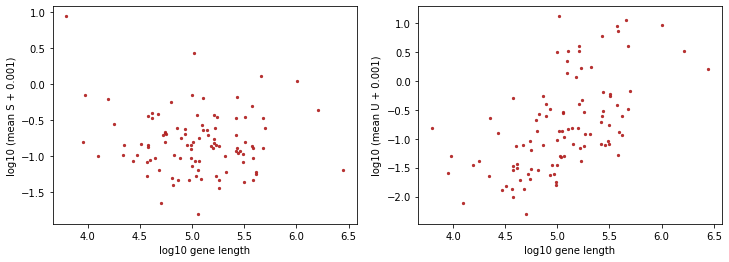

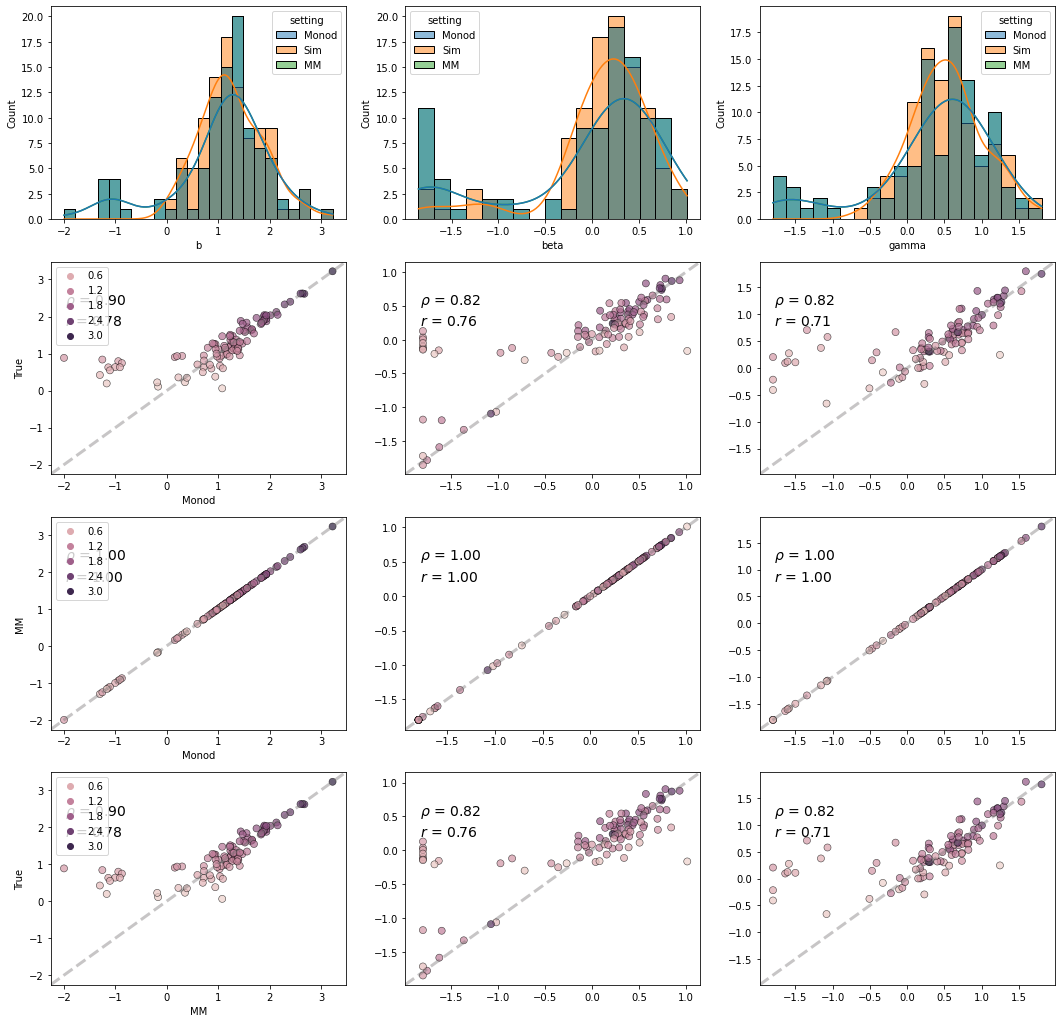

In [112]:
#2,3,17 lowest_beta90_sim_k3

search_data = monod.extract_data.extract_data(loom_filepaths[17], transcriptome_filepath, dataset_names[17],
                dataset_strings[17], dir_string, dataset_attr_names=attribute_names,cf=cf[17])
    
plot_params(search_data,all_counts,sr,all_params,grid_point_results,res_inds=[2,3,17],clus_inds=[0,0,1])



INFO:root:Beginning data extraction.
INFO:root:Dataset: beta90_sim_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230412_025_simTests_MM_1/beta90_sim_k3/diagnostic_figures already exists.
INFO:root:Search data stored to ./fits/gg_230412_025_simTests_MM_1/beta90_sim_k3/raw.sd.
True Param LogL:  -53492.40848004077
Monod Param LogL:  -57272.80457805495
MM Param LogL:  -61914.631223785385


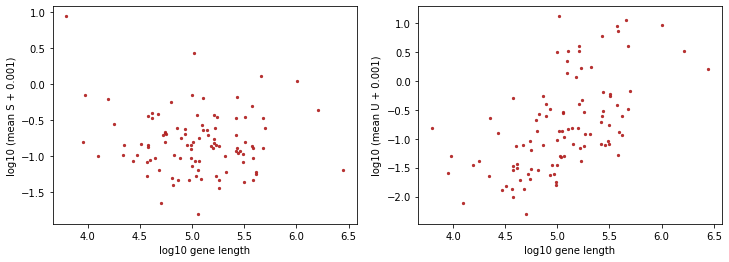

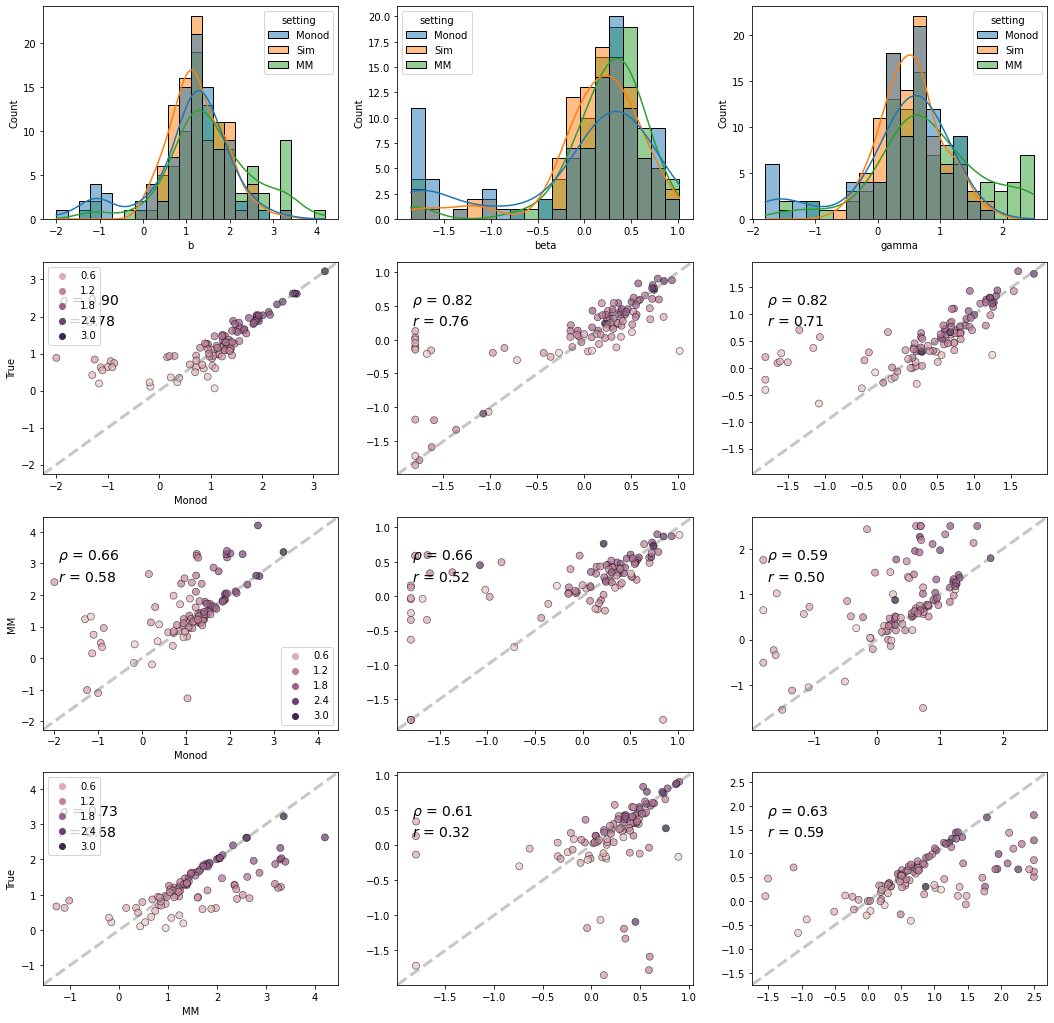

In [113]:
search_data = monod.extract_data.extract_data(loom_filepaths[17], transcriptome_filepath, dataset_names[17],
                dataset_strings[17], dir_string, dataset_attr_names=attribute_names,cf=cf[17])
    
plot_params(search_data,all_counts,sr,all_params,grid_point_results,res_inds=[2,3,15],clus_inds=[0,0,0])



In [ ]:
#Plot mean correlations
k1 = all_counts[0][0:500,:,:]
u_means = np.mean(k1[:,:,0],axis=0)
s_means = np.mean(k1[:,:,1],axis=0)

u_monod = 
s_monod =

u_mm = 
s_mm =



In [ ]:
pred_mean = (sr.param_estimates[0][:,0]-sr.param_estimates[0][:,1])+all_params[0][0,:,4]
plt.scatter(np.log10(np.mean(k1[:,:,0],axis=0)),pred_mean)

### **Old Compare params to control Monod, single-cluster test**

In [776]:
sr.param_estimates[0].shape

(100, 3)

In [778]:
true_b0 = all_params[0][0,:,0]

In [780]:
k1 = all_counts[0][0:500,:,:]
k1.shape

(500, 100, 2)

[[1.         0.99994398]
 [0.99994398 1.        ]]


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


Text(0, 0.5, 'fit mean U')

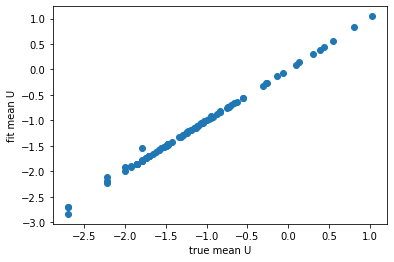

In [781]:
pred_mean = (sr.param_estimates[0][:,0]-sr.param_estimates[0][:,1])+all_params[0][0,:,4]
plt.scatter(np.log10(np.mean(k1[:,:,0],axis=0)),pred_mean)
print(np.corrcoef(np.mean(k1[:,:,0],axis=0),10**pred_mean))

plt.xlabel('true mean U')
plt.ylabel('fit mean U')

[[nan nan]
 [nan  1.]]


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'Fit Fano - 1')

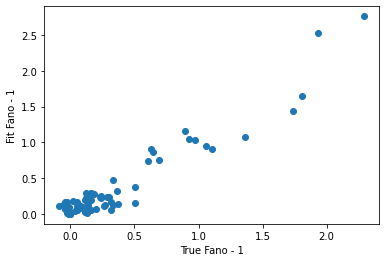

In [532]:
fano = np.var(k1[:,:,0],axis=0)/np.mean(k1[:,:,0],axis=0) - 1
pred_fano = 10**(params[0,:,4])*(1+10**params[0,:,0])

plt.scatter(fano,pred_fano)
print(np.corrcoef(fano,pred_fano))

plt.xlabel('True Fano - 1')
plt.ylabel('Fit Fano - 1')

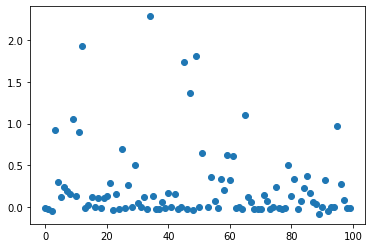

In [533]:
plt.scatter(range(len(fano)),fano)

(array([ 2.,  5.,  5., 14., 21., 17., 17., 10.,  3.,  6.]),
 array([-0.44154022, -0.14843812,  0.14466398,  0.43776608,  0.73086818,
         1.02397027,  1.31707237,  1.61017447,  1.90327657,  2.19637867,
         2.48948077]),
 <BarContainer object of 10 artists>)

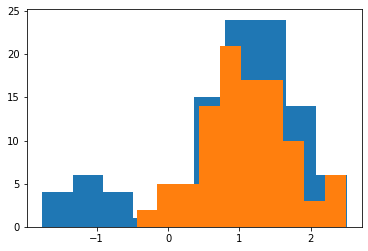

In [588]:
#Monod b dist overlap with true b dist
plt.hist(sr.param_estimates[0][:,0]) #Monod also not getting params right without EM
plt.hist(true_b0)

array([[1.        , 0.94245049],
       [0.94245049, 1.        ]])

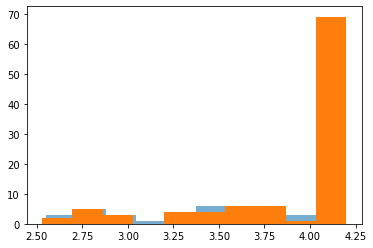

In [257]:
pred_b0 = grid_point_results[0].param_estimates[:,0,0]
plt.hist(sr.param_estimates[0][:,0],alpha=0.6)
plt.hist(pred_b0)
np.corrcoef(sr.param_estimates[0][:,0],pred_b0)

array([[1.        , 0.87494348],
       [0.87494348, 1.        ]])

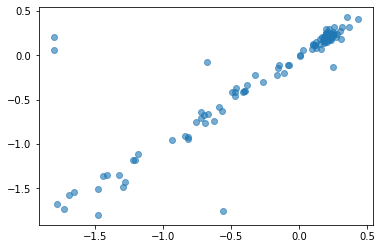

In [258]:
pred_b0 = grid_point_results_k3.param_estimates[:,1,0]
plt.scatter(sr.param_estimates[0][:,1],pred_b0,alpha=0.6)
np.corrcoef(sr.param_estimates[0][:,1],pred_b0)

array([[1.        , 0.49130319],
       [0.49130319, 1.        ]])

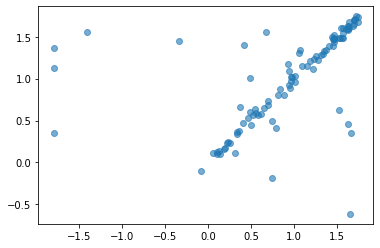

In [259]:
pred_b0 = grid_point_results_k3.param_estimates[:,2,0]
plt.scatter(sr.param_estimates[0][:,2],pred_b0,alpha=0.6)
np.corrcoef(sr.param_estimates[0][:,2],pred_b0)